# Vision Transformer for Skin Cancer Detection with HAM 10000


## Vision Transformer

Vision Transformers (ViT) revolutionised image recognition by applying the transformer architecture to computer vision models, initially developed for natural language processing (Dosovitskiy et al., 2021). ViT treats images as sequences of fixed-size patches, akin to tokens in natural language processing. By dividing an image into patches (e.g., 16x16 pixels), flattening them, and embedding them linearly, ViT processes images without relying on convolutional layers.

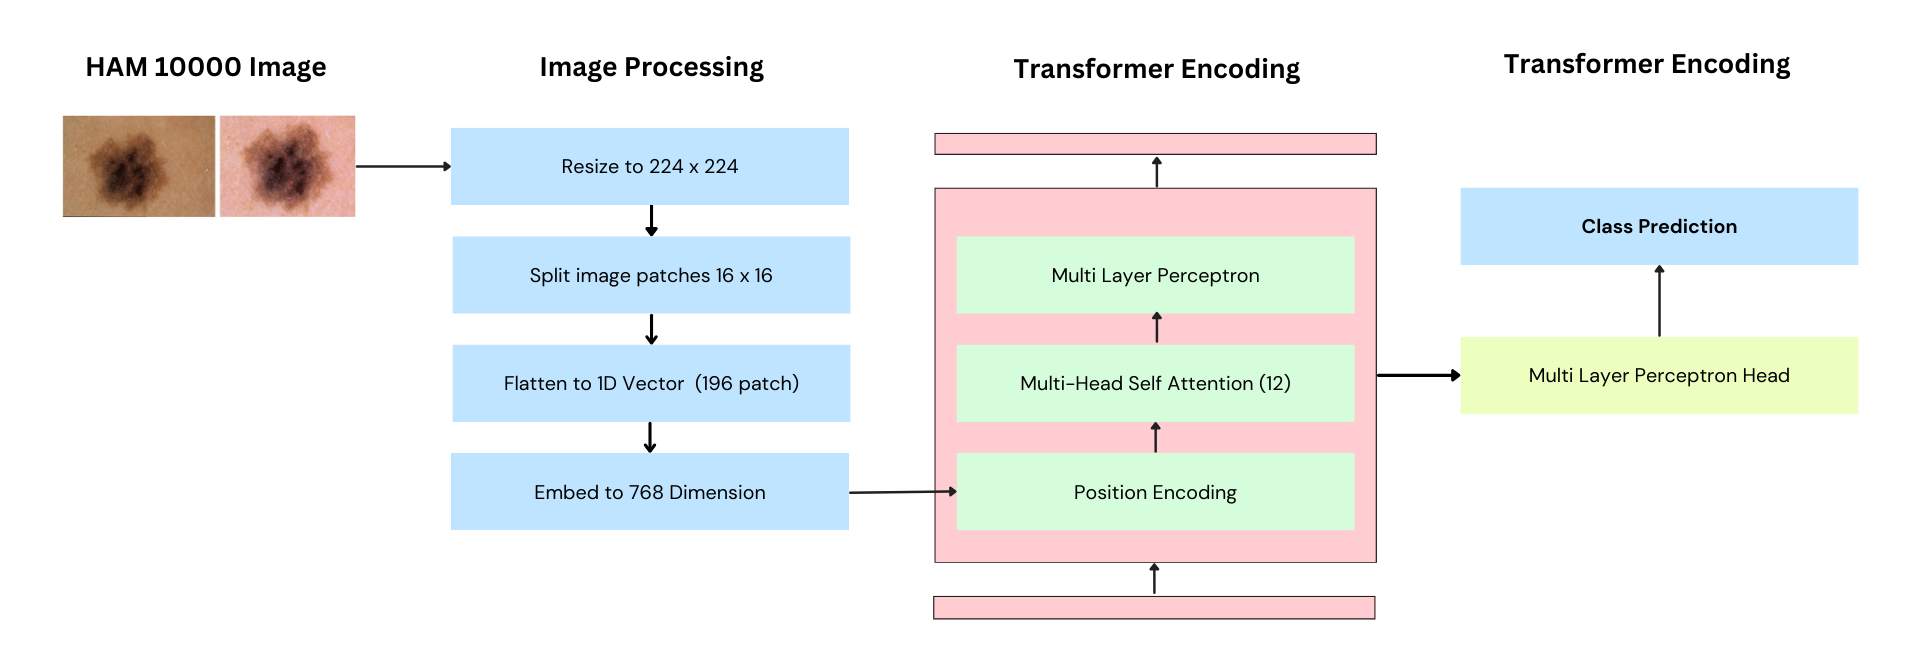

As shown in the image above, this architecture leverages self-attention mechanisms to capture global relationships across an image, enabling the model to understand complex patterns that span distant regions. Compared to traditional Convolutional Neural Networks (CNNs), ViT shows higher performance when trained on large datasets due to its scalability and capacity to model long-range dependencies.

## Prepare Dataset and Packages


### Mount Google Drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare HAM 10000 Dataset from Kaggle

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
! mkdir data
! unzip -q skin-cancer-mnist-ham10000.zip -d data

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [00:22<00:00, 252MB/s]
100% 5.20G/5.20G [00:22<00:00, 245MB/s]


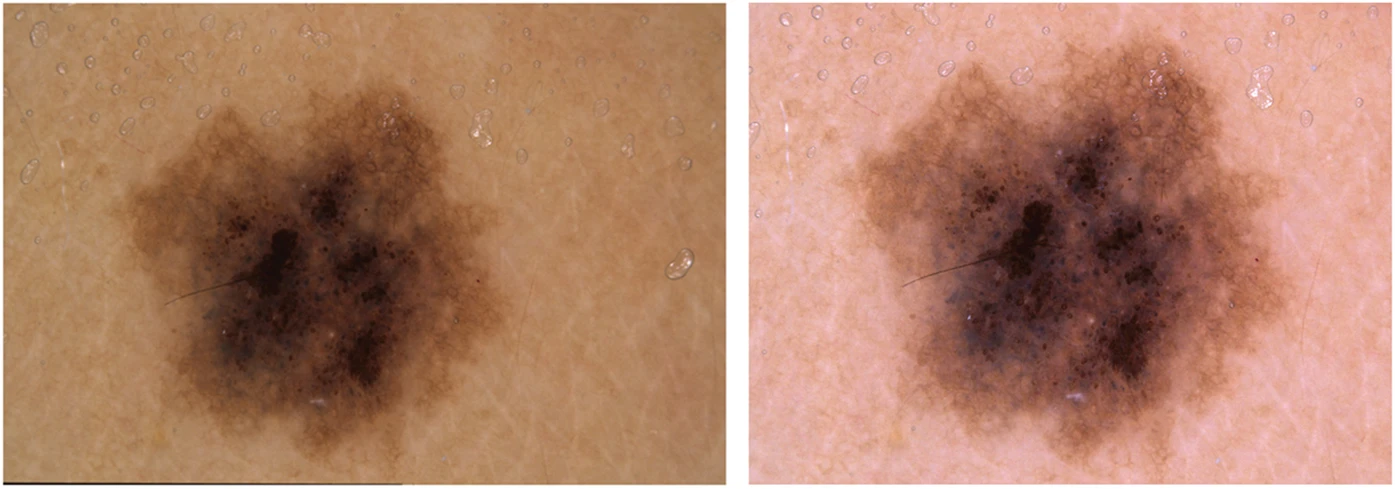

Sample image of HAM 10000

### Install and Import Packages

In [ ]:
!pip install tqdm
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision import transforms
from torch import nn, optim
from collections import defaultdict
from PIL import Image
import pandas as pd
from tqdm import tqdm  # For progress bar
from sklearn.preprocessing import LabelEncoder

## Create Directories and Variables

In [ ]:
# Prepare dataset directories
DATA_DIR = 'data/'
METADATA_FILE = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
IMAGE_DIRS = [os.path.join(DATA_DIR, 'HAM10000_images_part_1'),
              os.path.join(DATA_DIR, 'HAM10000_images_part_2')]

# Load Metadata
metadata = pd.read_csv(METADATA_FILE)

# Encode the string labels into numeric values
label_encoder = LabelEncoder()
metadata['dx_encoded'] = label_encoder.fit_transform(metadata['dx'])

### Prepare Pretrained Vision Transformer model

In [ ]:
# Initialize Feature Extractor
MODEL_NAME = 'google/vit-base-patch32-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

### Load Cuda for Usage

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Augmentation and Loading

### Image Augmentation

3 Augmentation tools used for our image dataset:

1.   Horizontal Flip
2.   Rotation
3.   Normalize



In [ ]:
# Augmentation Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

### Dataset Class for loading

In [ ]:
# Custom Dataset (Using Encoded Labels)
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dirs, feature_extractor, transform=None):
        self.dataframe = dataframe
        self.image_dirs = image_dirs
        self.feature_extractor = feature_extractor
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_id = row['image_id']
        # Search for the image in the provided directories
        for directory in self.image_dirs:
            image_path = os.path.join(directory, f"{image_id}.jpg")
            if os.path.exists(image_path):
                break
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['dx_encoded'])
        return image, label

## Built-from-Scratch Codes for K-fold Cross Validation


### Stratified K Fold for Equal Separation

In [ ]:
# stratifiedKFold class to separate dataset into K fold equaly
class stratifiedKFold:
    def __init__(self, n_split, shuffle, random_state):
        self.n_split = n_split
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y):
        if (self.shuffle and self.random_state) is not None:
            np.random.seed(self.random_state)

        idx = np.arange(len(y))
        if self.shuffle:
            np.random.shuffle(idx)

        y_idx = defaultdict(list)
        for i, label in zip(idx, y):
            y_idx[label].append(i)

        splits = [[] for _ in range(self.n_split)]

        for label, i in y_idx.items():
            np.random.shuffle(i)
            split_portions = [len(i) // self.n_split] * self.n_split
            for j in range(len(i) % self.n_split):
                split_portions[j] += 1

            first = 0
            for k in range(self.n_split):
                last = first + split_portions[k]
                splits[k].extend(i[first:last])
                first = last

        for i in range(self.n_split):
            test_idx = splits[i]
            train_idx = np.concatenate([splits[j] for j in range(self.n_split) if j != i])
            yield train_idx, test_idx

    def get_n_splits(self):
        return self.n_split

# Stratified sampling to get 50% of the data
def stratified_sample(dataframe, labels, sample_size=0.5, random_state=42):
    n_samples = int(sample_size * len(dataframe))
    skf = stratifiedKFold(n_split=int(1 / sample_size), shuffle=True, random_state=random_state)

    # We only need the first split for 50% sampling
    for train_idx, test_idx in skf.split(dataframe, labels):
        return dataframe.iloc[test_idx[:n_samples]]

### Training and Evaluation Process

In [ ]:
# Training and evaluation loops with progress bar
def train_epoch(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=False)

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({'Batch Loss': loss.item(), 'Batch Acc': 100 * correct / total})

    return running_loss / total, correct / total

def eval_epoch(model, val_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation", leave=False)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({'Batch Loss': loss.item(), 'Batch Acc': 100 * correct / total})

    return running_loss / total, correct / total

# Cross-validation function with 3x3 nested cross-validation
def nested_cross_validation(X, y, hyperparameter_combos, device, outer_folds=5, inner_folds=3):
    outer_fold = stratifiedKFold(n_split=outer_folds, shuffle=True, random_state=42)
    outer_results = []

    # Outer loop: 5-fold cross-validation
    for outer_fold_num, (train_idx, test_idx) in enumerate(outer_fold.split(X, y), 1):
        X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

        print(f"\n=== Outer Fold {outer_fold_num}/{outer_folds} ===")

        # Inner loop: 3-fold cross-validation for hyperparameter tuning
        inner_fold = stratifiedKFold(n_split=inner_folds, shuffle=True, random_state=42)
        best_hyperparam_combo = None
        best_inner_val_acc = 0

        for inner_fold_num, (inner_train_idx, inner_val_idx) in enumerate(inner_fold.split(X_train_outer, y_train_outer), 1):
            X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_val_idx]
            y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_val_idx]

            print(f"--- Inner Fold {inner_fold_num}/{inner_folds} ---")

            for combo_num, param in enumerate(hyperparameter_combos, 1):
                LEARNING_RATE = param['lr']
                BATCH_SIZE = param['batch_size']
                WEIGHT_DECAY = param['weight_decay']
                EPOCHS = param['epochs']

                # Initialize model
                model = ViTForImageClassification.from_pretrained(
                    MODEL_NAME, num_labels=len(label_encoder.classes_)
                )
                model.to(device)

                optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
                criterion = nn.CrossEntropyLoss()

                best_val_loss = np.inf

                # Early stopping counter for inner loop
                epochs_no_improve_inner = 0

                print(f"Inner Fold {inner_fold_num}, Hyperparameter Combo {combo_num}: lr={LEARNING_RATE}, batch_size={BATCH_SIZE}, weight_decay={WEIGHT_DECAY}")

                # Train model on inner training data
                for epoch in range(EPOCHS):
                    train_dataset = SkinCancerDataset(X_train_inner, IMAGE_DIRS, feature_extractor, transform=train_transform)
                    val_dataset = SkinCancerDataset(X_val_inner, IMAGE_DIRS, feature_extractor, transform=val_test_transform)

                    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

                    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, epoch)
                    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device, epoch)

                    print(f'Epoch {epoch + 1}/{EPOCHS} (Inner Fold {inner_fold_num}, Combo {combo_num}): Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss

                        # Reset counter if validation improves
                        epochs_no_improve_inner = 0
                    else:
                        epochs_no_improve_inner += 1

                    if epochs_no_improve_inner == PATIENCE:
                        print(f"Early stopping at epoch {epoch + 1} (Inner Fold {inner_fold_num}, Combo {combo_num})")
                        break

                # Track best hyperparameter combination based on inner validation accuracy
                if val_acc > best_inner_val_acc:
                    best_inner_val_acc = val_acc
                    best_hyperparam_combo = param

        # Now train the model on the outer fold with the best hyperparameters
        print(f"Best hyperparameters for Outer Fold {outer_fold_num}: {best_hyperparam_combo}")

        LEARNING_RATE = best_hyperparam_combo['lr']
        BATCH_SIZE = best_hyperparam_combo['batch_size']
        WEIGHT_DECAY = best_hyperparam_combo['weight_decay']
        EPOCHS = best_hyperparam_combo['epochs']

        # Initialize model for outer training with best hyperparameters
        model = ViTForImageClassification.from_pretrained(
            MODEL_NAME, num_labels=len(label_encoder.classes_)
        )
        model.to(device)

        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        criterion = nn.CrossEntropyLoss()

        best_outer_val_loss = np.inf

        # Early stopping counter for outer loop
        epochs_no_improve_outer = 0

        # Train and validate the model on outer fold
        for epoch in range(EPOCHS):
            train_dataset = SkinCancerDataset(X_train_outer, IMAGE_DIRS, feature_extractor, transform=train_transform)
            test_dataset = SkinCancerDataset(X_test_outer, IMAGE_DIRS, feature_extractor, transform=val_test_transform)

            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, epoch)
            val_loss, val_acc = eval_epoch(model, test_loader, criterion, device, epoch)

            print(f'Epoch {epoch + 1}/{EPOCHS} (Outer Fold {outer_fold_num}): Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

            # Outer loop early stopping logic
            if val_loss < best_outer_val_loss:
                best_outer_val_loss = val_loss
                # Reset counter if validation improves
                epochs_no_improve_outer = 0
            else:
                epochs_no_improve_outer += 1

            if epochs_no_improve_outer == PATIENCE:
                print(f"Early stopping at epoch {epoch + 1} (Outer Fold {outer_fold_num})")
                break

        # Save results for outer fold
        outer_results.append((best_hyperparam_combo, val_acc))

    return outer_results


### Prepare Training Dataset and Hyper parameter combos for Testing

In [ ]:
# Sample 50% of the data
metadata_sample = stratified_sample(metadata, metadata['dx_encoded'], sample_size=0.5)

# Reset index for the sampled data
metadata_sample = metadata_sample.reset_index(drop=True)

# Early stopping patience
PATIENCE = 5

# Hyperparameter combinations with varying learning behavior
hyperparameter_combos = [
    {'lr': 1e-3, 'batch_size': 256, 'weight_decay': 1e-4, 'epochs': 15},  # Aggressive learning
    {'lr': 1e-4, 'batch_size': 256, 'weight_decay': 1e-4, 'epochs': 25},  # Conservative learning
    {'lr': 1e-4, 'batch_size': 512, 'weight_decay': 5e-4, 'epochs': 40},  # Balanced learning
    {'lr': 5e-4, 'batch_size': 512, 'weight_decay': 1e-3, 'epochs': 20}   # Exploratory learning
]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Run K fold Cross Validation for  Hyper Parameter Tuning

In [ ]:
# Running the 5x3 Nested Cross-Validation
nested_results = nested_cross_validation(metadata, metadata['dx_encoded'], hyperparameter_combos, device)

# Output the best hyperparameters and accuracy for the nested cross-validation
best_nested_result = max(nested_results, key=lambda x: x[1])
print("Best Nested Cross-Validation Hyperparameters:", best_nested_result[0])
print("Best Nested Cross-Validation Accuracy:", best_nested_result[1])


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



=== Outer Fold 1/5 ===
--- Inner Fold 1/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 1, Combo 1): Train Loss: 1.1107, Train Acc: 64.35%, Val Loss: 0.9237, Val Acc: 68.04%


Epoch 2/15 (Inner Fold 1, Combo 1): Train Loss: 0.9256, Train Acc: 66.90%, Val Loss: 0.8943, Val Acc: 68.04%


Epoch 3/15 (Inner Fold 1, Combo 1): Train Loss: 0.8681, Train Acc: 69.18%, Val Loss: 0.8559, Val Acc: 69.87%


Epoch 4/15 (Inner Fold 1, Combo 1): Train Loss: 0.8126, Train Acc: 69.97%, Val Loss: 0.7764, Val Acc: 70.85%


Epoch 5/15 (Inner Fold 1, Combo 1): Train Loss: 0.7612, Train Acc: 71.58%, Val Loss: 0.8093, Val Acc: 70.88%


Epoch 6/15 (Inner Fold 1, Combo 1): Train Loss: 0.7695, Train Acc: 71.62%, Val Loss: 0.7999, Val Acc: 70.70%


Epoch 7/15 (Inner Fold 1, Combo 1): Train Loss: 0.6995, Train Acc: 74.04%, Val Loss: 0.7171, Val Acc: 74.06%


Epoch 8/15 (Inner Fold 1, Combo 1): Train Loss: 0.6838, Train Acc: 74.39%, Val Loss: 0.7091, Val Acc: 73.69%


Epoch 9/15 (Inner Fold 1, Combo 1): Train Loss: 0.6677, Train Acc: 75.18%, Val Loss: 0.7344, Val Acc: 73.09%


Epoch 10/15 (Inner Fold 1, Combo 1): Train Loss: 0.6543, Train Acc: 74.48%, Val Loss: 0.6597, Val Acc: 74.93%


Epoch 11/15 (Inner Fold 1, Combo 1): Train Loss: 0.6261, Train Acc: 76.11%, Val Loss: 0.6590, Val Acc: 75.82%


Epoch 12/15 (Inner Fold 1, Combo 1): Train Loss: 0.6140, Train Acc: 76.36%, Val Loss: 0.6505, Val Acc: 76.09%


Epoch 13/15 (Inner Fold 1, Combo 1): Train Loss: 0.5861, Train Acc: 77.74%, Val Loss: 0.6377, Val Acc: 75.67%


Epoch 14/15 (Inner Fold 1, Combo 1): Train Loss: 0.5491, Train Acc: 79.19%, Val Loss: 0.6939, Val Acc: 73.95%


Epoch 15/15 (Inner Fold 1, Combo 1): Train Loss: 0.5650, Train Acc: 78.18%, Val Loss: 0.6333, Val Acc: 76.05%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 1, Combo 2): Train Loss: 1.1251, Train Acc: 65.98%, Val Loss: 0.8875, Val Acc: 70.66%


Epoch 2/25 (Inner Fold 1, Combo 2): Train Loss: 0.7967, Train Acc: 74.24%, Val Loss: 0.7533, Val Acc: 76.09%


Epoch 3/25 (Inner Fold 1, Combo 2): Train Loss: 0.6618, Train Acc: 78.77%, Val Loss: 0.6323, Val Acc: 79.75%


Epoch 4/25 (Inner Fold 1, Combo 2): Train Loss: 0.5337, Train Acc: 84.21%, Val Loss: 0.5873, Val Acc: 80.61%


Epoch 5/25 (Inner Fold 1, Combo 2): Train Loss: 0.4685, Train Acc: 86.16%, Val Loss: 0.5288, Val Acc: 82.75%


Epoch 6/25 (Inner Fold 1, Combo 2): Train Loss: 0.3579, Train Acc: 90.30%, Val Loss: 0.5134, Val Acc: 82.67%


Epoch 7/25 (Inner Fold 1, Combo 2): Train Loss: 0.3035, Train Acc: 91.68%, Val Loss: 0.4935, Val Acc: 83.31%


Epoch 8/25 (Inner Fold 1, Combo 2): Train Loss: 0.2612, Train Acc: 93.09%, Val Loss: 0.5084, Val Acc: 83.83%


Epoch 9/25 (Inner Fold 1, Combo 2): Train Loss: 0.2173, Train Acc: 94.49%, Val Loss: 0.5069, Val Acc: 83.42%


Epoch 10/25 (Inner Fold 1, Combo 2): Train Loss: 0.1603, Train Acc: 96.03%, Val Loss: 0.4925, Val Acc: 84.51%


Epoch 11/25 (Inner Fold 1, Combo 2): Train Loss: 0.1399, Train Acc: 96.76%, Val Loss: 0.5337, Val Acc: 84.17%


Epoch 12/25 (Inner Fold 1, Combo 2): Train Loss: 0.1508, Train Acc: 95.86%, Val Loss: 0.5080, Val Acc: 84.32%


Epoch 13/25 (Inner Fold 1, Combo 2): Train Loss: 0.1031, Train Acc: 97.51%, Val Loss: 0.5106, Val Acc: 84.62%


Epoch 14/25 (Inner Fold 1, Combo 2): Train Loss: 0.0758, Train Acc: 98.43%, Val Loss: 0.5056, Val Acc: 85.52%


Epoch 15/25 (Inner Fold 1, Combo 2): Train Loss: 0.0812, Train Acc: 97.98%, Val Loss: 0.5088, Val Acc: 85.25%
Early stopping at epoch 15 (Inner Fold 1, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 1, Combo 3): Train Loss: 1.3059, Train Acc: 61.20%, Val Loss: 1.0370, Val Acc: 67.22%


Epoch 2/40 (Inner Fold 1, Combo 3): Train Loss: 0.9481, Train Acc: 69.28%, Val Loss: 0.8810, Val Acc: 71.93%


Epoch 3/40 (Inner Fold 1, Combo 3): Train Loss: 0.8269, Train Acc: 72.78%, Val Loss: 0.8261, Val Acc: 73.99%


Epoch 4/40 (Inner Fold 1, Combo 3): Train Loss: 0.7290, Train Acc: 77.01%, Val Loss: 0.7147, Val Acc: 77.62%


Epoch 5/40 (Inner Fold 1, Combo 3): Train Loss: 0.6449, Train Acc: 79.58%, Val Loss: 0.6654, Val Acc: 78.41%


Epoch 6/40 (Inner Fold 1, Combo 3): Train Loss: 0.5592, Train Acc: 83.40%, Val Loss: 0.6156, Val Acc: 79.60%


Epoch 7/40 (Inner Fold 1, Combo 3): Train Loss: 0.4859, Train Acc: 86.16%, Val Loss: 0.5633, Val Acc: 81.89%


Epoch 8/40 (Inner Fold 1, Combo 3): Train Loss: 0.4410, Train Acc: 87.37%, Val Loss: 0.5584, Val Acc: 80.84%


Epoch 9/40 (Inner Fold 1, Combo 3): Train Loss: 0.3825, Train Acc: 89.83%, Val Loss: 0.5503, Val Acc: 82.00%


Epoch 10/40 (Inner Fold 1, Combo 3): Train Loss: 0.3162, Train Acc: 92.17%, Val Loss: 0.5361, Val Acc: 82.52%


Epoch 11/40 (Inner Fold 1, Combo 3): Train Loss: 0.2899, Train Acc: 92.60%, Val Loss: 0.5379, Val Acc: 82.82%


Epoch 12/40 (Inner Fold 1, Combo 3): Train Loss: 0.2386, Train Acc: 94.45%, Val Loss: 0.5238, Val Acc: 83.35%


Epoch 13/40 (Inner Fold 1, Combo 3): Train Loss: 0.1973, Train Acc: 95.43%, Val Loss: 0.5263, Val Acc: 83.46%


Epoch 14/40 (Inner Fold 1, Combo 3): Train Loss: 0.1660, Train Acc: 96.55%, Val Loss: 0.5039, Val Acc: 84.24%


Epoch 15/40 (Inner Fold 1, Combo 3): Train Loss: 0.1672, Train Acc: 96.12%, Val Loss: 0.5428, Val Acc: 83.53%


Epoch 16/40 (Inner Fold 1, Combo 3): Train Loss: 0.1481, Train Acc: 96.59%, Val Loss: 0.5000, Val Acc: 84.96%


Epoch 17/40 (Inner Fold 1, Combo 3): Train Loss: 0.1107, Train Acc: 97.88%, Val Loss: 0.5383, Val Acc: 83.65%


Epoch 18/40 (Inner Fold 1, Combo 3): Train Loss: 0.1023, Train Acc: 97.96%, Val Loss: 0.5455, Val Acc: 84.39%


Epoch 19/40 (Inner Fold 1, Combo 3): Train Loss: 0.0945, Train Acc: 98.28%, Val Loss: 0.5712, Val Acc: 82.45%


Epoch 20/40 (Inner Fold 1, Combo 3): Train Loss: 0.0914, Train Acc: 98.09%, Val Loss: 0.5931, Val Acc: 83.05%


Epoch 21/40 (Inner Fold 1, Combo 3): Train Loss: 0.0716, Train Acc: 98.71%, Val Loss: 0.5361, Val Acc: 84.39%
Early stopping at epoch 21 (Inner Fold 1, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 1, Combo 4): Train Loss: 1.2726, Train Acc: 61.48%, Val Loss: 1.0546, Val Acc: 67.22%


Epoch 2/20 (Inner Fold 1, Combo 4): Train Loss: 1.0325, Train Acc: 67.18%, Val Loss: 0.9164, Val Acc: 68.60%


Epoch 3/20 (Inner Fold 1, Combo 4): Train Loss: 0.8523, Train Acc: 70.34%, Val Loss: 0.8335, Val Acc: 68.34%


Epoch 4/20 (Inner Fold 1, Combo 4): Train Loss: 0.7841, Train Acc: 72.16%, Val Loss: 0.7689, Val Acc: 73.43%


Epoch 5/20 (Inner Fold 1, Combo 4): Train Loss: 0.7035, Train Acc: 75.08%, Val Loss: 0.6855, Val Acc: 75.67%


Epoch 6/20 (Inner Fold 1, Combo 4): Train Loss: 0.6608, Train Acc: 76.15%, Val Loss: 0.6525, Val Acc: 75.94%


Epoch 7/20 (Inner Fold 1, Combo 4): Train Loss: 0.6007, Train Acc: 78.19%, Val Loss: 0.7180, Val Acc: 72.94%


Epoch 8/20 (Inner Fold 1, Combo 4): Train Loss: 0.5492, Train Acc: 80.55%, Val Loss: 0.5750, Val Acc: 79.42%


Epoch 9/20 (Inner Fold 1, Combo 4): Train Loss: 0.4716, Train Acc: 83.18%, Val Loss: 0.5400, Val Acc: 80.50%


Epoch 10/20 (Inner Fold 1, Combo 4): Train Loss: 0.3983, Train Acc: 85.71%, Val Loss: 0.5704, Val Acc: 80.69%


Epoch 11/20 (Inner Fold 1, Combo 4): Train Loss: 0.3505, Train Acc: 87.64%, Val Loss: 0.6048, Val Acc: 79.94%


Epoch 12/20 (Inner Fold 1, Combo 4): Train Loss: 0.3146, Train Acc: 89.02%, Val Loss: 0.5867, Val Acc: 81.14%


Epoch 13/20 (Inner Fold 1, Combo 4): Train Loss: 0.2662, Train Acc: 90.54%, Val Loss: 0.5322, Val Acc: 82.56%


Epoch 14/20 (Inner Fold 1, Combo 4): Train Loss: 0.2214, Train Acc: 92.60%, Val Loss: 0.5356, Val Acc: 82.11%


Epoch 15/20 (Inner Fold 1, Combo 4): Train Loss: 0.1993, Train Acc: 93.76%, Val Loss: 0.6618, Val Acc: 79.08%


Epoch 16/20 (Inner Fold 1, Combo 4): Train Loss: 0.1982, Train Acc: 93.20%, Val Loss: 0.6432, Val Acc: 79.04%


Epoch 17/20 (Inner Fold 1, Combo 4): Train Loss: 0.1711, Train Acc: 94.08%, Val Loss: 0.5896, Val Acc: 82.00%


Epoch 18/20 (Inner Fold 1, Combo 4): Train Loss: 0.1313, Train Acc: 95.75%, Val Loss: 0.7930, Val Acc: 78.89%
Early stopping at epoch 18 (Inner Fold 1, Combo 4)
--- Inner Fold 2/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 2, Combo 1): Train Loss: 1.1485, Train Acc: 63.84%, Val Loss: 1.0825, Val Acc: 66.29%


Epoch 2/15 (Inner Fold 2, Combo 1): Train Loss: 0.9534, Train Acc: 67.38%, Val Loss: 0.9554, Val Acc: 66.89%


Epoch 3/15 (Inner Fold 2, Combo 1): Train Loss: 0.8865, Train Acc: 68.13%, Val Loss: 0.8904, Val Acc: 67.15%


Epoch 4/15 (Inner Fold 2, Combo 1): Train Loss: 0.8556, Train Acc: 69.61%, Val Loss: 0.8308, Val Acc: 69.81%


Epoch 5/15 (Inner Fold 2, Combo 1): Train Loss: 0.8266, Train Acc: 70.21%, Val Loss: 0.7872, Val Acc: 70.94%


Epoch 6/15 (Inner Fold 2, Combo 1): Train Loss: 0.7745, Train Acc: 71.10%, Val Loss: 0.7514, Val Acc: 71.50%


Epoch 7/15 (Inner Fold 2, Combo 1): Train Loss: 0.7665, Train Acc: 71.67%, Val Loss: 0.7312, Val Acc: 73.37%


Epoch 8/15 (Inner Fold 2, Combo 1): Train Loss: 0.7194, Train Acc: 72.87%, Val Loss: 0.7445, Val Acc: 72.66%


Epoch 9/15 (Inner Fold 2, Combo 1): Train Loss: 0.7186, Train Acc: 73.16%, Val Loss: 0.7040, Val Acc: 72.62%


Epoch 10/15 (Inner Fold 2, Combo 1): Train Loss: 0.6977, Train Acc: 73.73%, Val Loss: 0.6890, Val Acc: 73.63%


Epoch 11/15 (Inner Fold 2, Combo 1): Train Loss: 0.6561, Train Acc: 75.32%, Val Loss: 0.6894, Val Acc: 74.12%


Epoch 12/15 (Inner Fold 2, Combo 1): Train Loss: 0.6274, Train Acc: 76.12%, Val Loss: 0.6695, Val Acc: 74.83%


Epoch 13/15 (Inner Fold 2, Combo 1): Train Loss: 0.6071, Train Acc: 77.06%, Val Loss: 0.6818, Val Acc: 75.24%


Epoch 14/15 (Inner Fold 2, Combo 1): Train Loss: 0.5863, Train Acc: 77.70%, Val Loss: 0.6478, Val Acc: 75.73%


Epoch 15/15 (Inner Fold 2, Combo 1): Train Loss: 0.5899, Train Acc: 77.81%, Val Loss: 0.6352, Val Acc: 76.37%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 2, Combo 2): Train Loss: 1.1412, Train Acc: 64.83%, Val Loss: 0.9472, Val Acc: 67.90%


Epoch 2/25 (Inner Fold 2, Combo 2): Train Loss: 0.8357, Train Acc: 72.66%, Val Loss: 0.7805, Val Acc: 75.32%


Epoch 3/25 (Inner Fold 2, Combo 2): Train Loss: 0.6804, Train Acc: 78.05%, Val Loss: 0.6615, Val Acc: 78.65%


Epoch 4/25 (Inner Fold 2, Combo 2): Train Loss: 0.5663, Train Acc: 82.51%, Val Loss: 0.5733, Val Acc: 82.02%


Epoch 5/25 (Inner Fold 2, Combo 2): Train Loss: 0.4705, Train Acc: 86.18%, Val Loss: 0.5207, Val Acc: 83.00%


Epoch 6/25 (Inner Fold 2, Combo 2): Train Loss: 0.4283, Train Acc: 87.15%, Val Loss: 0.5064, Val Acc: 83.11%


Epoch 7/25 (Inner Fold 2, Combo 2): Train Loss: 0.3432, Train Acc: 90.24%, Val Loss: 0.5238, Val Acc: 81.39%


Epoch 8/25 (Inner Fold 2, Combo 2): Train Loss: 0.2788, Train Acc: 92.47%, Val Loss: 0.4706, Val Acc: 84.98%


Epoch 9/25 (Inner Fold 2, Combo 2): Train Loss: 0.2285, Train Acc: 94.27%, Val Loss: 0.4756, Val Acc: 84.79%


Epoch 10/25 (Inner Fold 2, Combo 2): Train Loss: 0.1956, Train Acc: 94.79%, Val Loss: 0.5248, Val Acc: 83.63%


Epoch 11/25 (Inner Fold 2, Combo 2): Train Loss: 0.1706, Train Acc: 95.51%, Val Loss: 0.6153, Val Acc: 82.51%


Epoch 12/25 (Inner Fold 2, Combo 2): Train Loss: 0.1967, Train Acc: 94.63%, Val Loss: 0.4713, Val Acc: 85.51%


Epoch 13/25 (Inner Fold 2, Combo 2): Train Loss: 0.1216, Train Acc: 97.30%, Val Loss: 0.4881, Val Acc: 85.58%
Early stopping at epoch 13 (Inner Fold 2, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 2, Combo 3): Train Loss: 1.2948, Train Acc: 62.36%, Val Loss: 1.0691, Val Acc: 66.29%


Epoch 2/40 (Inner Fold 2, Combo 3): Train Loss: 0.9426, Train Acc: 68.43%, Val Loss: 0.8930, Val Acc: 70.90%


Epoch 3/40 (Inner Fold 2, Combo 3): Train Loss: 0.8184, Train Acc: 72.64%, Val Loss: 0.7948, Val Acc: 75.92%


Epoch 4/40 (Inner Fold 2, Combo 3): Train Loss: 0.7234, Train Acc: 77.42%, Val Loss: 0.7120, Val Acc: 77.72%


Epoch 5/40 (Inner Fold 2, Combo 3): Train Loss: 0.6393, Train Acc: 79.61%, Val Loss: 0.6612, Val Acc: 79.44%


Epoch 6/40 (Inner Fold 2, Combo 3): Train Loss: 0.5586, Train Acc: 83.05%, Val Loss: 0.6031, Val Acc: 81.39%


Epoch 7/40 (Inner Fold 2, Combo 3): Train Loss: 0.4948, Train Acc: 85.37%, Val Loss: 0.5555, Val Acc: 82.55%


Epoch 8/40 (Inner Fold 2, Combo 3): Train Loss: 0.4492, Train Acc: 86.91%, Val Loss: 0.5466, Val Acc: 81.50%


Epoch 9/40 (Inner Fold 2, Combo 3): Train Loss: 0.3808, Train Acc: 90.00%, Val Loss: 0.5054, Val Acc: 83.97%


Epoch 10/40 (Inner Fold 2, Combo 3): Train Loss: 0.3291, Train Acc: 91.42%, Val Loss: 0.5083, Val Acc: 83.78%


Epoch 11/40 (Inner Fold 2, Combo 3): Train Loss: 0.2780, Train Acc: 93.20%, Val Loss: 0.4850, Val Acc: 84.12%


Epoch 12/40 (Inner Fold 2, Combo 3): Train Loss: 0.2479, Train Acc: 93.88%, Val Loss: 0.4882, Val Acc: 84.49%


Epoch 13/40 (Inner Fold 2, Combo 3): Train Loss: 0.2099, Train Acc: 95.00%, Val Loss: 0.5060, Val Acc: 84.57%


Epoch 14/40 (Inner Fold 2, Combo 3): Train Loss: 0.1860, Train Acc: 95.51%, Val Loss: 0.5377, Val Acc: 84.23%


Epoch 15/40 (Inner Fold 2, Combo 3): Train Loss: 0.1572, Train Acc: 96.70%, Val Loss: 0.5275, Val Acc: 83.78%


Epoch 16/40 (Inner Fold 2, Combo 3): Train Loss: 0.1347, Train Acc: 97.12%, Val Loss: 0.4958, Val Acc: 84.87%
Early stopping at epoch 16 (Inner Fold 2, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 2, Combo 4): Train Loss: 1.2571, Train Acc: 61.27%, Val Loss: 1.0425, Val Acc: 66.29%


Epoch 2/20 (Inner Fold 2, Combo 4): Train Loss: 0.9733, Train Acc: 68.56%, Val Loss: 0.8925, Val Acc: 68.58%


Epoch 3/20 (Inner Fold 2, Combo 4): Train Loss: 0.8487, Train Acc: 70.73%, Val Loss: 0.7816, Val Acc: 73.18%


Epoch 4/20 (Inner Fold 2, Combo 4): Train Loss: 0.7111, Train Acc: 74.94%, Val Loss: 0.6923, Val Acc: 75.69%


Epoch 5/20 (Inner Fold 2, Combo 4): Train Loss: 0.6765, Train Acc: 75.88%, Val Loss: 0.7002, Val Acc: 74.27%


Epoch 6/20 (Inner Fold 2, Combo 4): Train Loss: 0.6209, Train Acc: 77.83%, Val Loss: 0.6672, Val Acc: 75.69%


Epoch 7/20 (Inner Fold 2, Combo 4): Train Loss: 0.5554, Train Acc: 80.71%, Val Loss: 0.5638, Val Acc: 79.96%


Epoch 8/20 (Inner Fold 2, Combo 4): Train Loss: 0.4836, Train Acc: 82.64%, Val Loss: 0.5768, Val Acc: 78.43%


Epoch 9/20 (Inner Fold 2, Combo 4): Train Loss: 0.4155, Train Acc: 85.02%, Val Loss: 0.5656, Val Acc: 79.63%


Epoch 10/20 (Inner Fold 2, Combo 4): Train Loss: 0.3678, Train Acc: 87.25%, Val Loss: 0.5858, Val Acc: 78.13%


Epoch 11/20 (Inner Fold 2, Combo 4): Train Loss: 0.3422, Train Acc: 87.98%, Val Loss: 0.6503, Val Acc: 76.07%


Epoch 12/20 (Inner Fold 2, Combo 4): Train Loss: 0.3015, Train Acc: 89.68%, Val Loss: 0.5423, Val Acc: 80.52%


Epoch 13/20 (Inner Fold 2, Combo 4): Train Loss: 0.2434, Train Acc: 91.91%, Val Loss: 0.6157, Val Acc: 77.34%


Epoch 14/20 (Inner Fold 2, Combo 4): Train Loss: 0.2290, Train Acc: 91.93%, Val Loss: 0.5539, Val Acc: 80.90%


Epoch 15/20 (Inner Fold 2, Combo 4): Train Loss: 0.1682, Train Acc: 94.48%, Val Loss: 0.5977, Val Acc: 80.71%


Epoch 16/20 (Inner Fold 2, Combo 4): Train Loss: 0.1445, Train Acc: 95.24%, Val Loss: 0.5582, Val Acc: 82.88%


Epoch 17/20 (Inner Fold 2, Combo 4): Train Loss: 0.1202, Train Acc: 95.90%, Val Loss: 0.6133, Val Acc: 82.28%
Early stopping at epoch 17 (Inner Fold 2, Combo 4)
--- Inner Fold 3/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 3, Combo 1): Train Loss: 1.1668, Train Acc: 63.20%, Val Loss: 1.2564, Val Acc: 52.02%


Epoch 2/15 (Inner Fold 3, Combo 1): Train Loss: 1.0693, Train Acc: 66.12%, Val Loss: 0.9666, Val Acc: 67.35%


Epoch 3/15 (Inner Fold 3, Combo 1): Train Loss: 0.9501, Train Acc: 67.62%, Val Loss: 0.9126, Val Acc: 68.52%


Epoch 4/15 (Inner Fold 3, Combo 1): Train Loss: 0.8730, Train Acc: 68.49%, Val Loss: 0.8350, Val Acc: 70.35%


Epoch 5/15 (Inner Fold 3, Combo 1): Train Loss: 0.8508, Train Acc: 69.49%, Val Loss: 0.8187, Val Acc: 70.43%


Epoch 6/15 (Inner Fold 3, Combo 1): Train Loss: 0.8083, Train Acc: 70.03%, Val Loss: 0.7892, Val Acc: 70.46%


Epoch 7/15 (Inner Fold 3, Combo 1): Train Loss: 0.7707, Train Acc: 70.69%, Val Loss: 0.7387, Val Acc: 72.23%


Epoch 8/15 (Inner Fold 3, Combo 1): Train Loss: 0.7201, Train Acc: 73.23%, Val Loss: 0.7515, Val Acc: 72.60%


Epoch 9/15 (Inner Fold 3, Combo 1): Train Loss: 0.7029, Train Acc: 73.90%, Val Loss: 0.7889, Val Acc: 69.34%


Epoch 10/15 (Inner Fold 3, Combo 1): Train Loss: 0.6793, Train Acc: 75.03%, Val Loss: 0.6975, Val Acc: 74.36%


Epoch 11/15 (Inner Fold 3, Combo 1): Train Loss: 0.6532, Train Acc: 75.50%, Val Loss: 0.6945, Val Acc: 74.59%


Epoch 12/15 (Inner Fold 3, Combo 1): Train Loss: 0.6311, Train Acc: 76.24%, Val Loss: 0.7571, Val Acc: 71.85%


Epoch 13/15 (Inner Fold 3, Combo 1): Train Loss: 0.6261, Train Acc: 76.45%, Val Loss: 0.6936, Val Acc: 74.33%


Epoch 14/15 (Inner Fold 3, Combo 1): Train Loss: 0.6102, Train Acc: 77.14%, Val Loss: 0.6894, Val Acc: 74.14%


Epoch 15/15 (Inner Fold 3, Combo 1): Train Loss: 0.5849, Train Acc: 78.06%, Val Loss: 0.6725, Val Acc: 75.37%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 3, Combo 2): Train Loss: 1.1593, Train Acc: 65.56%, Val Loss: 0.9145, Val Acc: 70.84%


Epoch 2/25 (Inner Fold 3, Combo 2): Train Loss: 0.8096, Train Acc: 73.42%, Val Loss: 0.7432, Val Acc: 76.69%


Epoch 3/25 (Inner Fold 3, Combo 2): Train Loss: 0.6578, Train Acc: 79.02%, Val Loss: 0.6487, Val Acc: 79.35%


Epoch 4/25 (Inner Fold 3, Combo 2): Train Loss: 0.5470, Train Acc: 83.26%, Val Loss: 0.5782, Val Acc: 81.75%


Epoch 5/25 (Inner Fold 3, Combo 2): Train Loss: 0.4421, Train Acc: 87.12%, Val Loss: 0.5533, Val Acc: 82.12%


Epoch 6/25 (Inner Fold 3, Combo 2): Train Loss: 0.3777, Train Acc: 89.09%, Val Loss: 0.5449, Val Acc: 82.08%


Epoch 7/25 (Inner Fold 3, Combo 2): Train Loss: 0.3318, Train Acc: 90.00%, Val Loss: 0.5083, Val Acc: 83.28%


Epoch 8/25 (Inner Fold 3, Combo 2): Train Loss: 0.2713, Train Acc: 92.74%, Val Loss: 0.5262, Val Acc: 83.21%


Epoch 9/25 (Inner Fold 3, Combo 2): Train Loss: 0.2122, Train Acc: 94.52%, Val Loss: 0.4814, Val Acc: 84.90%


Epoch 10/25 (Inner Fold 3, Combo 2): Train Loss: 0.1584, Train Acc: 96.26%, Val Loss: 0.5359, Val Acc: 83.40%


Epoch 11/25 (Inner Fold 3, Combo 2): Train Loss: 0.1217, Train Acc: 97.38%, Val Loss: 0.5139, Val Acc: 84.00%


Epoch 12/25 (Inner Fold 3, Combo 2): Train Loss: 0.1030, Train Acc: 97.64%, Val Loss: 0.5150, Val Acc: 85.16%


Epoch 13/25 (Inner Fold 3, Combo 2): Train Loss: 0.1060, Train Acc: 97.14%, Val Loss: 0.5189, Val Acc: 84.41%


Epoch 14/25 (Inner Fold 3, Combo 2): Train Loss: 0.0712, Train Acc: 98.69%, Val Loss: 0.5545, Val Acc: 85.16%
Early stopping at epoch 14 (Inner Fold 3, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 3, Combo 3): Train Loss: 1.3103, Train Acc: 62.73%, Val Loss: 1.0438, Val Acc: 67.35%


Epoch 2/40 (Inner Fold 3, Combo 3): Train Loss: 0.9578, Train Acc: 68.14%, Val Loss: 0.8917, Val Acc: 71.36%


Epoch 3/40 (Inner Fold 3, Combo 3): Train Loss: 0.8426, Train Acc: 71.96%, Val Loss: 0.8090, Val Acc: 74.59%


Epoch 4/40 (Inner Fold 3, Combo 3): Train Loss: 0.7363, Train Acc: 76.66%, Val Loss: 0.7318, Val Acc: 78.26%


Epoch 5/40 (Inner Fold 3, Combo 3): Train Loss: 0.6575, Train Acc: 78.94%, Val Loss: 0.6707, Val Acc: 78.60%


Epoch 6/40 (Inner Fold 3, Combo 3): Train Loss: 0.5707, Train Acc: 82.85%, Val Loss: 0.6261, Val Acc: 80.10%


Epoch 7/40 (Inner Fold 3, Combo 3): Train Loss: 0.5184, Train Acc: 84.59%, Val Loss: 0.6025, Val Acc: 80.13%


Epoch 8/40 (Inner Fold 3, Combo 3): Train Loss: 0.4575, Train Acc: 86.37%, Val Loss: 0.5598, Val Acc: 82.46%


Epoch 9/40 (Inner Fold 3, Combo 3): Train Loss: 0.3922, Train Acc: 88.94%, Val Loss: 0.5237, Val Acc: 82.57%


Epoch 10/40 (Inner Fold 3, Combo 3): Train Loss: 0.3342, Train Acc: 91.22%, Val Loss: 0.5193, Val Acc: 83.10%


Epoch 11/40 (Inner Fold 3, Combo 3): Train Loss: 0.2924, Train Acc: 92.74%, Val Loss: 0.5227, Val Acc: 82.95%


Epoch 12/40 (Inner Fold 3, Combo 3): Train Loss: 0.2356, Train Acc: 94.16%, Val Loss: 0.5008, Val Acc: 83.21%


Epoch 13/40 (Inner Fold 3, Combo 3): Train Loss: 0.1992, Train Acc: 95.43%, Val Loss: 0.5512, Val Acc: 83.51%


Epoch 14/40 (Inner Fold 3, Combo 3): Train Loss: 0.2016, Train Acc: 94.96%, Val Loss: 0.4955, Val Acc: 84.60%


Epoch 15/40 (Inner Fold 3, Combo 3): Train Loss: 0.1444, Train Acc: 97.00%, Val Loss: 0.5066, Val Acc: 84.45%


Epoch 16/40 (Inner Fold 3, Combo 3): Train Loss: 0.1190, Train Acc: 97.81%, Val Loss: 0.5147, Val Acc: 84.90%


Epoch 17/40 (Inner Fold 3, Combo 3): Train Loss: 0.1195, Train Acc: 97.44%, Val Loss: 0.5136, Val Acc: 84.45%


Epoch 18/40 (Inner Fold 3, Combo 3): Train Loss: 0.0889, Train Acc: 98.52%, Val Loss: 0.5297, Val Acc: 84.33%


Epoch 19/40 (Inner Fold 3, Combo 3): Train Loss: 0.0824, Train Acc: 98.54%, Val Loss: 0.5366, Val Acc: 83.96%
Early stopping at epoch 19 (Inner Fold 3, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 3, Combo 4): Train Loss: 1.1867, Train Acc: 61.42%, Val Loss: 0.9058, Val Acc: 69.68%


Epoch 2/20 (Inner Fold 3, Combo 4): Train Loss: 0.9570, Train Acc: 68.10%, Val Loss: 0.8501, Val Acc: 70.61%


Epoch 3/20 (Inner Fold 3, Combo 4): Train Loss: 0.8040, Train Acc: 71.56%, Val Loss: 0.8019, Val Acc: 71.93%


Epoch 4/20 (Inner Fold 3, Combo 4): Train Loss: 0.7265, Train Acc: 74.41%, Val Loss: 0.7159, Val Acc: 75.26%


Epoch 5/20 (Inner Fold 3, Combo 4): Train Loss: 0.6372, Train Acc: 77.95%, Val Loss: 0.6574, Val Acc: 77.21%


Epoch 6/20 (Inner Fold 3, Combo 4): Train Loss: 0.5563, Train Acc: 79.95%, Val Loss: 0.5912, Val Acc: 79.65%


Epoch 7/20 (Inner Fold 3, Combo 4): Train Loss: 0.4739, Train Acc: 83.43%, Val Loss: 0.6291, Val Acc: 78.45%


Epoch 8/20 (Inner Fold 3, Combo 4): Train Loss: 0.4389, Train Acc: 84.37%, Val Loss: 0.5610, Val Acc: 80.06%


Epoch 9/20 (Inner Fold 3, Combo 4): Train Loss: 0.3611, Train Acc: 87.38%, Val Loss: 0.5766, Val Acc: 79.99%


Epoch 10/20 (Inner Fold 3, Combo 4): Train Loss: 0.3581, Train Acc: 87.31%, Val Loss: 0.5679, Val Acc: 79.84%


Epoch 11/20 (Inner Fold 3, Combo 4): Train Loss: 0.2920, Train Acc: 89.85%, Val Loss: 0.5739, Val Acc: 81.41%


Epoch 12/20 (Inner Fold 3, Combo 4): Train Loss: 0.2333, Train Acc: 91.80%, Val Loss: 0.5553, Val Acc: 82.35%


Epoch 13/20 (Inner Fold 3, Combo 4): Train Loss: 0.1827, Train Acc: 93.90%, Val Loss: 0.5679, Val Acc: 82.05%


Epoch 14/20 (Inner Fold 3, Combo 4): Train Loss: 0.1493, Train Acc: 95.26%, Val Loss: 0.6918, Val Acc: 77.89%


Epoch 15/20 (Inner Fold 3, Combo 4): Train Loss: 0.1461, Train Acc: 95.13%, Val Loss: 0.6254, Val Acc: 82.53%


Epoch 16/20 (Inner Fold 3, Combo 4): Train Loss: 0.1247, Train Acc: 95.92%, Val Loss: 0.6096, Val Acc: 82.87%


Epoch 17/20 (Inner Fold 3, Combo 4): Train Loss: 0.0863, Train Acc: 97.30%, Val Loss: 0.6663, Val Acc: 80.51%
Early stopping at epoch 17 (Inner Fold 3, Combo 4)
Best hyperparameters for Outer Fold 1: {'lr': 0.0001, 'batch_size': 256, 'weight_decay': 0.0001, 'epochs': 25}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 (Outer Fold 1): Train Loss: 1.0516, Train Acc: 66.92%, Val Loss: 0.8102, Val Acc: 74.96%


Epoch 2/25 (Outer Fold 1): Train Loss: 0.7044, Train Acc: 77.10%, Val Loss: 0.6829, Val Acc: 77.26%


Epoch 3/25 (Outer Fold 1): Train Loss: 0.5528, Train Acc: 82.46%, Val Loss: 0.5729, Val Acc: 81.50%


Epoch 4/25 (Outer Fold 1): Train Loss: 0.4722, Train Acc: 85.43%, Val Loss: 0.5654, Val Acc: 81.35%


Epoch 5/25 (Outer Fold 1): Train Loss: 0.3882, Train Acc: 88.20%, Val Loss: 0.4814, Val Acc: 84.69%


Epoch 6/25 (Outer Fold 1): Train Loss: 0.3085, Train Acc: 90.90%, Val Loss: 0.4791, Val Acc: 82.59%


Epoch 7/25 (Outer Fold 1): Train Loss: 0.2423, Train Acc: 93.11%, Val Loss: 0.4276, Val Acc: 85.49%


Epoch 8/25 (Outer Fold 1): Train Loss: 0.2110, Train Acc: 93.82%, Val Loss: 0.4478, Val Acc: 85.39%


Epoch 9/25 (Outer Fold 1): Train Loss: 0.1729, Train Acc: 95.22%, Val Loss: 0.4743, Val Acc: 84.64%


Epoch 10/25 (Outer Fold 1): Train Loss: 0.1344, Train Acc: 96.37%, Val Loss: 0.4549, Val Acc: 85.89%


Epoch 11/25 (Outer Fold 1): Train Loss: 0.0963, Train Acc: 97.45%, Val Loss: 0.4904, Val Acc: 85.34%


Epoch 12/25 (Outer Fold 1): Train Loss: 0.0989, Train Acc: 97.12%, Val Loss: 0.5324, Val Acc: 84.89%
Early stopping at epoch 12 (Outer Fold 1)

=== Outer Fold 2/5 ===
--- Inner Fold 1/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 1, Combo 1): Train Loss: 1.1490, Train Acc: 65.25%, Val Loss: 1.0162, Val Acc: 67.14%


Epoch 2/15 (Inner Fold 1, Combo 1): Train Loss: 0.9605, Train Acc: 66.86%, Val Loss: 0.9116, Val Acc: 68.19%


Epoch 3/15 (Inner Fold 1, Combo 1): Train Loss: 0.8987, Train Acc: 67.65%, Val Loss: 0.8566, Val Acc: 68.64%


Epoch 4/15 (Inner Fold 1, Combo 1): Train Loss: 0.8511, Train Acc: 68.57%, Val Loss: 0.8521, Val Acc: 69.42%


Epoch 5/15 (Inner Fold 1, Combo 1): Train Loss: 0.8412, Train Acc: 69.18%, Val Loss: 0.8343, Val Acc: 68.97%


Epoch 6/15 (Inner Fold 1, Combo 1): Train Loss: 0.8421, Train Acc: 69.90%, Val Loss: 0.8401, Val Acc: 69.61%


Epoch 7/15 (Inner Fold 1, Combo 1): Train Loss: 0.8179, Train Acc: 69.97%, Val Loss: 0.8102, Val Acc: 70.58%


Epoch 8/15 (Inner Fold 1, Combo 1): Train Loss: 0.7664, Train Acc: 71.81%, Val Loss: 0.7422, Val Acc: 72.23%


Epoch 9/15 (Inner Fold 1, Combo 1): Train Loss: 0.7229, Train Acc: 72.80%, Val Loss: 0.7083, Val Acc: 72.19%


Epoch 10/15 (Inner Fold 1, Combo 1): Train Loss: 0.7077, Train Acc: 73.15%, Val Loss: 0.6992, Val Acc: 72.94%


Epoch 11/15 (Inner Fold 1, Combo 1): Train Loss: 0.7053, Train Acc: 73.64%, Val Loss: 0.7157, Val Acc: 72.01%


Epoch 12/15 (Inner Fold 1, Combo 1): Train Loss: 0.6690, Train Acc: 74.92%, Val Loss: 0.6862, Val Acc: 73.13%


Epoch 13/15 (Inner Fold 1, Combo 1): Train Loss: 0.6284, Train Acc: 76.08%, Val Loss: 0.7019, Val Acc: 74.14%


Epoch 14/15 (Inner Fold 1, Combo 1): Train Loss: 0.6138, Train Acc: 76.68%, Val Loss: 0.7312, Val Acc: 73.20%


Epoch 15/15 (Inner Fold 1, Combo 1): Train Loss: 0.6141, Train Acc: 76.73%, Val Loss: 0.6570, Val Acc: 75.49%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 1, Combo 2): Train Loss: 1.1501, Train Acc: 63.86%, Val Loss: 0.9248, Val Acc: 67.59%


Epoch 2/25 (Inner Fold 1, Combo 2): Train Loss: 0.8349, Train Acc: 71.71%, Val Loss: 0.8264, Val Acc: 74.10%


Epoch 3/25 (Inner Fold 1, Combo 2): Train Loss: 0.7026, Train Acc: 77.65%, Val Loss: 0.7022, Val Acc: 76.91%


Epoch 4/25 (Inner Fold 1, Combo 2): Train Loss: 0.5785, Train Acc: 81.75%, Val Loss: 0.6083, Val Acc: 80.09%


Epoch 5/25 (Inner Fold 1, Combo 2): Train Loss: 0.4934, Train Acc: 84.81%, Val Loss: 0.5981, Val Acc: 79.68%


Epoch 6/25 (Inner Fold 1, Combo 2): Train Loss: 0.4281, Train Acc: 87.04%, Val Loss: 0.5639, Val Acc: 80.20%


Epoch 7/25 (Inner Fold 1, Combo 2): Train Loss: 0.3463, Train Acc: 90.13%, Val Loss: 0.5334, Val Acc: 81.77%


Epoch 8/25 (Inner Fold 1, Combo 2): Train Loss: 0.2606, Train Acc: 93.46%, Val Loss: 0.5505, Val Acc: 81.21%


Epoch 9/25 (Inner Fold 1, Combo 2): Train Loss: 0.2588, Train Acc: 92.64%, Val Loss: 0.5198, Val Acc: 83.27%


Epoch 10/25 (Inner Fold 1, Combo 2): Train Loss: 0.1948, Train Acc: 95.20%, Val Loss: 0.4830, Val Acc: 84.81%


Epoch 11/25 (Inner Fold 1, Combo 2): Train Loss: 0.1480, Train Acc: 96.74%, Val Loss: 0.5246, Val Acc: 84.02%


Epoch 12/25 (Inner Fold 1, Combo 2): Train Loss: 0.1290, Train Acc: 96.97%, Val Loss: 0.5037, Val Acc: 84.66%


Epoch 13/25 (Inner Fold 1, Combo 2): Train Loss: 0.1055, Train Acc: 97.75%, Val Loss: 0.5291, Val Acc: 84.58%


Epoch 14/25 (Inner Fold 1, Combo 2): Train Loss: 0.1071, Train Acc: 97.43%, Val Loss: 0.5437, Val Acc: 83.76%


Epoch 15/25 (Inner Fold 1, Combo 2): Train Loss: 0.0911, Train Acc: 97.83%, Val Loss: 0.5691, Val Acc: 83.27%
Early stopping at epoch 15 (Inner Fold 1, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 1, Combo 3): Train Loss: 1.2758, Train Acc: 65.47%, Val Loss: 1.0305, Val Acc: 67.22%


Epoch 2/40 (Inner Fold 1, Combo 3): Train Loss: 0.9289, Train Acc: 69.00%, Val Loss: 0.8571, Val Acc: 72.79%


Epoch 3/40 (Inner Fold 1, Combo 3): Train Loss: 0.7972, Train Acc: 75.12%, Val Loss: 0.7667, Val Acc: 75.37%


Epoch 4/40 (Inner Fold 1, Combo 3): Train Loss: 0.7012, Train Acc: 77.99%, Val Loss: 0.6860, Val Acc: 78.33%


Epoch 5/40 (Inner Fold 1, Combo 3): Train Loss: 0.6135, Train Acc: 82.07%, Val Loss: 0.6859, Val Acc: 77.77%


Epoch 6/40 (Inner Fold 1, Combo 3): Train Loss: 0.5547, Train Acc: 83.18%, Val Loss: 0.5899, Val Acc: 81.36%


Epoch 7/40 (Inner Fold 1, Combo 3): Train Loss: 0.4782, Train Acc: 86.06%, Val Loss: 0.5735, Val Acc: 81.81%


Epoch 8/40 (Inner Fold 1, Combo 3): Train Loss: 0.4227, Train Acc: 88.59%, Val Loss: 0.5466, Val Acc: 82.75%


Epoch 9/40 (Inner Fold 1, Combo 3): Train Loss: 0.3500, Train Acc: 91.14%, Val Loss: 0.5134, Val Acc: 83.68%


Epoch 10/40 (Inner Fold 1, Combo 3): Train Loss: 0.3003, Train Acc: 92.62%, Val Loss: 0.5044, Val Acc: 84.47%


Epoch 11/40 (Inner Fold 1, Combo 3): Train Loss: 0.2522, Train Acc: 94.12%, Val Loss: 0.6626, Val Acc: 76.42%


Epoch 12/40 (Inner Fold 1, Combo 3): Train Loss: 0.2473, Train Acc: 93.56%, Val Loss: 0.5048, Val Acc: 83.61%


Epoch 13/40 (Inner Fold 1, Combo 3): Train Loss: 0.1892, Train Acc: 95.84%, Val Loss: 0.4725, Val Acc: 85.22%


Epoch 14/40 (Inner Fold 1, Combo 3): Train Loss: 0.1545, Train Acc: 97.10%, Val Loss: 0.4670, Val Acc: 85.33%


Epoch 15/40 (Inner Fold 1, Combo 3): Train Loss: 0.1311, Train Acc: 97.55%, Val Loss: 0.5066, Val Acc: 85.44%


Epoch 16/40 (Inner Fold 1, Combo 3): Train Loss: 0.1246, Train Acc: 97.51%, Val Loss: 0.5084, Val Acc: 84.62%


Epoch 17/40 (Inner Fold 1, Combo 3): Train Loss: 0.1193, Train Acc: 97.38%, Val Loss: 0.4896, Val Acc: 84.88%


Epoch 18/40 (Inner Fold 1, Combo 3): Train Loss: 0.0948, Train Acc: 98.43%, Val Loss: 0.4886, Val Acc: 85.89%


Epoch 19/40 (Inner Fold 1, Combo 3): Train Loss: 0.0738, Train Acc: 99.01%, Val Loss: 0.5062, Val Acc: 85.22%
Early stopping at epoch 19 (Inner Fold 1, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 1, Combo 4): Train Loss: 1.2624, Train Acc: 60.57%, Val Loss: 1.0560, Val Acc: 67.22%


Epoch 2/20 (Inner Fold 1, Combo 4): Train Loss: 0.9651, Train Acc: 68.43%, Val Loss: 0.8763, Val Acc: 70.17%


Epoch 3/20 (Inner Fold 1, Combo 4): Train Loss: 0.8036, Train Acc: 72.69%, Val Loss: 0.7519, Val Acc: 73.35%


Epoch 4/20 (Inner Fold 1, Combo 4): Train Loss: 0.7196, Train Acc: 75.03%, Val Loss: 0.6627, Val Acc: 76.46%


Epoch 5/20 (Inner Fold 1, Combo 4): Train Loss: 0.6095, Train Acc: 78.81%, Val Loss: 0.6390, Val Acc: 77.32%


Epoch 6/20 (Inner Fold 1, Combo 4): Train Loss: 0.5640, Train Acc: 80.05%, Val Loss: 0.6027, Val Acc: 78.07%


Epoch 7/20 (Inner Fold 1, Combo 4): Train Loss: 0.4882, Train Acc: 83.27%, Val Loss: 0.5554, Val Acc: 80.09%


Epoch 8/20 (Inner Fold 1, Combo 4): Train Loss: 0.4214, Train Acc: 84.98%, Val Loss: 0.5180, Val Acc: 81.32%


Epoch 9/20 (Inner Fold 1, Combo 4): Train Loss: 0.3530, Train Acc: 88.72%, Val Loss: 0.5494, Val Acc: 80.46%


Epoch 10/20 (Inner Fold 1, Combo 4): Train Loss: 0.3227, Train Acc: 88.68%, Val Loss: 0.5328, Val Acc: 81.74%


Epoch 11/20 (Inner Fold 1, Combo 4): Train Loss: 0.3026, Train Acc: 89.21%, Val Loss: 0.5854, Val Acc: 80.76%


Epoch 12/20 (Inner Fold 1, Combo 4): Train Loss: 0.2570, Train Acc: 90.86%, Val Loss: 0.5274, Val Acc: 82.04%


Epoch 13/20 (Inner Fold 1, Combo 4): Train Loss: 0.1752, Train Acc: 94.34%, Val Loss: 0.7042, Val Acc: 78.07%
Early stopping at epoch 13 (Inner Fold 1, Combo 4)
--- Inner Fold 2/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 2, Combo 1): Train Loss: 1.1684, Train Acc: 63.69%, Val Loss: 1.0353, Val Acc: 66.89%


Epoch 2/15 (Inner Fold 2, Combo 1): Train Loss: 1.0077, Train Acc: 66.84%, Val Loss: 0.9537, Val Acc: 66.40%


Epoch 3/15 (Inner Fold 2, Combo 1): Train Loss: 0.9682, Train Acc: 66.97%, Val Loss: 0.9596, Val Acc: 67.04%


Epoch 4/15 (Inner Fold 2, Combo 1): Train Loss: 0.8947, Train Acc: 67.83%, Val Loss: 0.8472, Val Acc: 69.70%


Epoch 5/15 (Inner Fold 2, Combo 1): Train Loss: 0.8555, Train Acc: 68.37%, Val Loss: 0.8306, Val Acc: 68.91%


Epoch 6/15 (Inner Fold 2, Combo 1): Train Loss: 0.8393, Train Acc: 69.38%, Val Loss: 0.8192, Val Acc: 69.63%


Epoch 7/15 (Inner Fold 2, Combo 1): Train Loss: 0.8040, Train Acc: 70.07%, Val Loss: 0.7644, Val Acc: 70.15%


Epoch 8/15 (Inner Fold 2, Combo 1): Train Loss: 0.7482, Train Acc: 71.80%, Val Loss: 0.7496, Val Acc: 71.57%


Epoch 9/15 (Inner Fold 2, Combo 1): Train Loss: 0.7334, Train Acc: 72.73%, Val Loss: 0.7257, Val Acc: 72.85%


Epoch 10/15 (Inner Fold 2, Combo 1): Train Loss: 0.7256, Train Acc: 72.98%, Val Loss: 0.7483, Val Acc: 72.92%


Epoch 11/15 (Inner Fold 2, Combo 1): Train Loss: 0.6891, Train Acc: 73.71%, Val Loss: 0.7515, Val Acc: 71.69%


Epoch 12/15 (Inner Fold 2, Combo 1): Train Loss: 0.6639, Train Acc: 74.81%, Val Loss: 0.6887, Val Acc: 73.37%


Epoch 13/15 (Inner Fold 2, Combo 1): Train Loss: 0.6604, Train Acc: 74.74%, Val Loss: 0.7204, Val Acc: 72.06%


Epoch 14/15 (Inner Fold 2, Combo 1): Train Loss: 0.6658, Train Acc: 74.66%, Val Loss: 0.7170, Val Acc: 73.18%


Epoch 15/15 (Inner Fold 2, Combo 1): Train Loss: 0.6315, Train Acc: 75.86%, Val Loss: 0.6757, Val Acc: 73.56%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 2, Combo 2): Train Loss: 1.1622, Train Acc: 64.85%, Val Loss: 0.9174, Val Acc: 70.15%


Epoch 2/25 (Inner Fold 2, Combo 2): Train Loss: 0.8153, Train Acc: 73.48%, Val Loss: 0.7462, Val Acc: 76.55%


Epoch 3/25 (Inner Fold 2, Combo 2): Train Loss: 0.6564, Train Acc: 79.59%, Val Loss: 0.6333, Val Acc: 80.04%


Epoch 4/25 (Inner Fold 2, Combo 2): Train Loss: 0.5415, Train Acc: 83.37%, Val Loss: 0.5637, Val Acc: 82.88%


Epoch 5/25 (Inner Fold 2, Combo 2): Train Loss: 0.4598, Train Acc: 86.74%, Val Loss: 0.5184, Val Acc: 84.16%


Epoch 6/25 (Inner Fold 2, Combo 2): Train Loss: 0.3777, Train Acc: 89.16%, Val Loss: 0.4861, Val Acc: 84.04%


Epoch 7/25 (Inner Fold 2, Combo 2): Train Loss: 0.2909, Train Acc: 92.36%, Val Loss: 0.5022, Val Acc: 83.48%


Epoch 8/25 (Inner Fold 2, Combo 2): Train Loss: 0.2461, Train Acc: 93.48%, Val Loss: 0.4970, Val Acc: 84.46%


Epoch 9/25 (Inner Fold 2, Combo 2): Train Loss: 0.1992, Train Acc: 94.94%, Val Loss: 0.5727, Val Acc: 82.73%


Epoch 10/25 (Inner Fold 2, Combo 2): Train Loss: 0.1726, Train Acc: 95.88%, Val Loss: 0.5131, Val Acc: 83.30%


Epoch 11/25 (Inner Fold 2, Combo 2): Train Loss: 0.1336, Train Acc: 97.02%, Val Loss: 0.5276, Val Acc: 83.37%
Early stopping at epoch 11 (Inner Fold 2, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 2, Combo 3): Train Loss: 1.3409, Train Acc: 61.01%, Val Loss: 1.0817, Val Acc: 66.89%


Epoch 2/40 (Inner Fold 2, Combo 3): Train Loss: 0.9835, Train Acc: 68.00%, Val Loss: 0.9054, Val Acc: 70.64%


Epoch 3/40 (Inner Fold 2, Combo 3): Train Loss: 0.8500, Train Acc: 71.74%, Val Loss: 0.7914, Val Acc: 76.03%


Epoch 4/40 (Inner Fold 2, Combo 3): Train Loss: 0.7344, Train Acc: 76.59%, Val Loss: 0.6980, Val Acc: 78.28%


Epoch 5/40 (Inner Fold 2, Combo 3): Train Loss: 0.6408, Train Acc: 79.72%, Val Loss: 0.6310, Val Acc: 80.37%


Epoch 6/40 (Inner Fold 2, Combo 3): Train Loss: 0.5530, Train Acc: 83.43%, Val Loss: 0.6100, Val Acc: 80.37%


Epoch 7/40 (Inner Fold 2, Combo 3): Train Loss: 0.4942, Train Acc: 85.47%, Val Loss: 0.5441, Val Acc: 83.03%


Epoch 8/40 (Inner Fold 2, Combo 3): Train Loss: 0.4409, Train Acc: 87.02%, Val Loss: 0.5092, Val Acc: 84.23%


Epoch 9/40 (Inner Fold 2, Combo 3): Train Loss: 0.3825, Train Acc: 89.51%, Val Loss: 0.5460, Val Acc: 81.27%


Epoch 10/40 (Inner Fold 2, Combo 3): Train Loss: 0.3184, Train Acc: 91.63%, Val Loss: 0.4849, Val Acc: 84.98%


Epoch 11/40 (Inner Fold 2, Combo 3): Train Loss: 0.2742, Train Acc: 93.09%, Val Loss: 0.4875, Val Acc: 84.38%


Epoch 12/40 (Inner Fold 2, Combo 3): Train Loss: 0.2315, Train Acc: 94.36%, Val Loss: 0.4629, Val Acc: 84.72%


Epoch 13/40 (Inner Fold 2, Combo 3): Train Loss: 0.1849, Train Acc: 96.09%, Val Loss: 0.4619, Val Acc: 85.47%


Epoch 14/40 (Inner Fold 2, Combo 3): Train Loss: 0.1485, Train Acc: 97.04%, Val Loss: 0.4973, Val Acc: 84.46%


Epoch 15/40 (Inner Fold 2, Combo 3): Train Loss: 0.1669, Train Acc: 96.16%, Val Loss: 0.5252, Val Acc: 83.26%


Epoch 16/40 (Inner Fold 2, Combo 3): Train Loss: 0.1529, Train Acc: 96.39%, Val Loss: 0.5070, Val Acc: 83.60%


Epoch 17/40 (Inner Fold 2, Combo 3): Train Loss: 0.1173, Train Acc: 97.55%, Val Loss: 0.4988, Val Acc: 85.24%


Epoch 18/40 (Inner Fold 2, Combo 3): Train Loss: 0.0996, Train Acc: 98.18%, Val Loss: 0.5074, Val Acc: 84.49%
Early stopping at epoch 18 (Inner Fold 2, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 2, Combo 4): Train Loss: 1.2494, Train Acc: 60.77%, Val Loss: 1.0224, Val Acc: 67.75%


Epoch 2/20 (Inner Fold 2, Combo 4): Train Loss: 0.9863, Train Acc: 67.38%, Val Loss: 0.8673, Val Acc: 69.81%


Epoch 3/20 (Inner Fold 2, Combo 4): Train Loss: 0.8583, Train Acc: 69.85%, Val Loss: 0.8065, Val Acc: 70.86%


Epoch 4/20 (Inner Fold 2, Combo 4): Train Loss: 0.7933, Train Acc: 71.74%, Val Loss: 0.7558, Val Acc: 72.55%


Epoch 5/20 (Inner Fold 2, Combo 4): Train Loss: 0.7195, Train Acc: 74.16%, Val Loss: 0.7228, Val Acc: 74.27%


Epoch 6/20 (Inner Fold 2, Combo 4): Train Loss: 0.6465, Train Acc: 76.69%, Val Loss: 0.6327, Val Acc: 77.94%


Epoch 7/20 (Inner Fold 2, Combo 4): Train Loss: 0.5775, Train Acc: 79.53%, Val Loss: 0.6571, Val Acc: 75.99%


Epoch 8/20 (Inner Fold 2, Combo 4): Train Loss: 0.5196, Train Acc: 81.22%, Val Loss: 0.6350, Val Acc: 78.16%


Epoch 9/20 (Inner Fold 2, Combo 4): Train Loss: 0.4984, Train Acc: 81.72%, Val Loss: 0.5492, Val Acc: 80.11%


Epoch 10/20 (Inner Fold 2, Combo 4): Train Loss: 0.4054, Train Acc: 85.92%, Val Loss: 0.5338, Val Acc: 81.09%


Epoch 11/20 (Inner Fold 2, Combo 4): Train Loss: 0.3418, Train Acc: 88.18%, Val Loss: 0.5483, Val Acc: 81.16%


Epoch 12/20 (Inner Fold 2, Combo 4): Train Loss: 0.3407, Train Acc: 87.47%, Val Loss: 0.5263, Val Acc: 82.02%


Epoch 13/20 (Inner Fold 2, Combo 4): Train Loss: 0.2661, Train Acc: 90.88%, Val Loss: 0.4981, Val Acc: 82.81%


Epoch 14/20 (Inner Fold 2, Combo 4): Train Loss: 0.2232, Train Acc: 92.15%, Val Loss: 0.5556, Val Acc: 81.54%


Epoch 15/20 (Inner Fold 2, Combo 4): Train Loss: 0.2084, Train Acc: 92.62%, Val Loss: 0.6833, Val Acc: 77.45%


Epoch 16/20 (Inner Fold 2, Combo 4): Train Loss: 0.2193, Train Acc: 92.43%, Val Loss: 0.5775, Val Acc: 81.12%


Epoch 17/20 (Inner Fold 2, Combo 4): Train Loss: 0.1537, Train Acc: 94.49%, Val Loss: 0.5758, Val Acc: 81.54%


Epoch 18/20 (Inner Fold 2, Combo 4): Train Loss: 0.1260, Train Acc: 95.67%, Val Loss: 0.6171, Val Acc: 82.06%
Early stopping at epoch 18 (Inner Fold 2, Combo 4)
--- Inner Fold 3/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 3, Combo 1): Train Loss: 1.1359, Train Acc: 65.84%, Val Loss: 1.0156, Val Acc: 66.64%


Epoch 2/15 (Inner Fold 3, Combo 1): Train Loss: 0.9257, Train Acc: 67.35%, Val Loss: 0.9901, Val Acc: 66.57%


Epoch 3/15 (Inner Fold 3, Combo 1): Train Loss: 0.8792, Train Acc: 68.31%, Val Loss: 0.8894, Val Acc: 68.44%


Epoch 4/15 (Inner Fold 3, Combo 1): Train Loss: 0.8393, Train Acc: 68.87%, Val Loss: 0.8673, Val Acc: 67.17%


Epoch 5/15 (Inner Fold 3, Combo 1): Train Loss: 0.7961, Train Acc: 69.88%, Val Loss: 0.7901, Val Acc: 70.99%


Epoch 6/15 (Inner Fold 3, Combo 1): Train Loss: 0.7590, Train Acc: 71.32%, Val Loss: 0.7880, Val Acc: 71.55%


Epoch 7/15 (Inner Fold 3, Combo 1): Train Loss: 0.7296, Train Acc: 72.71%, Val Loss: 0.7507, Val Acc: 71.10%


Epoch 8/15 (Inner Fold 3, Combo 1): Train Loss: 0.7231, Train Acc: 72.74%, Val Loss: 0.7260, Val Acc: 72.34%


Epoch 9/15 (Inner Fold 3, Combo 1): Train Loss: 0.6751, Train Acc: 74.60%, Val Loss: 0.7299, Val Acc: 73.31%


Epoch 10/15 (Inner Fold 3, Combo 1): Train Loss: 0.6603, Train Acc: 75.18%, Val Loss: 0.7425, Val Acc: 72.86%


Epoch 11/15 (Inner Fold 3, Combo 1): Train Loss: 0.6261, Train Acc: 75.89%, Val Loss: 0.7118, Val Acc: 73.91%


Epoch 12/15 (Inner Fold 3, Combo 1): Train Loss: 0.6181, Train Acc: 76.88%, Val Loss: 0.7435, Val Acc: 71.18%


Epoch 13/15 (Inner Fold 3, Combo 1): Train Loss: 0.6005, Train Acc: 77.29%, Val Loss: 0.7119, Val Acc: 74.36%


Epoch 14/15 (Inner Fold 3, Combo 1): Train Loss: 0.5758, Train Acc: 77.69%, Val Loss: 0.6933, Val Acc: 75.15%


Epoch 15/15 (Inner Fold 3, Combo 1): Train Loss: 0.5459, Train Acc: 78.85%, Val Loss: 0.6811, Val Acc: 75.49%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 3, Combo 2): Train Loss: 1.1129, Train Acc: 67.24%, Val Loss: 0.9231, Val Acc: 70.65%


Epoch 2/25 (Inner Fold 3, Combo 2): Train Loss: 0.7979, Train Acc: 73.70%, Val Loss: 0.7739, Val Acc: 75.52%


Epoch 3/25 (Inner Fold 3, Combo 2): Train Loss: 0.6604, Train Acc: 79.05%, Val Loss: 0.6653, Val Acc: 78.60%


Epoch 4/25 (Inner Fold 3, Combo 2): Train Loss: 0.5365, Train Acc: 83.83%, Val Loss: 0.5874, Val Acc: 81.37%


Epoch 5/25 (Inner Fold 3, Combo 2): Train Loss: 0.4574, Train Acc: 85.94%, Val Loss: 0.5789, Val Acc: 80.28%


Epoch 6/25 (Inner Fold 3, Combo 2): Train Loss: 0.3817, Train Acc: 88.64%, Val Loss: 0.5812, Val Acc: 79.99%


Epoch 7/25 (Inner Fold 3, Combo 2): Train Loss: 0.3224, Train Acc: 91.30%, Val Loss: 0.5537, Val Acc: 82.08%


Epoch 8/25 (Inner Fold 3, Combo 2): Train Loss: 0.2605, Train Acc: 93.00%, Val Loss: 0.5883, Val Acc: 82.08%


Epoch 9/25 (Inner Fold 3, Combo 2): Train Loss: 0.2142, Train Acc: 94.59%, Val Loss: 0.5743, Val Acc: 80.47%


Epoch 10/25 (Inner Fold 3, Combo 2): Train Loss: 0.1675, Train Acc: 95.66%, Val Loss: 0.5423, Val Acc: 82.38%


Epoch 11/25 (Inner Fold 3, Combo 2): Train Loss: 0.1330, Train Acc: 97.00%, Val Loss: 0.5384, Val Acc: 83.51%


Epoch 12/25 (Inner Fold 3, Combo 2): Train Loss: 0.1295, Train Acc: 96.61%, Val Loss: 0.5719, Val Acc: 83.13%


Epoch 13/25 (Inner Fold 3, Combo 2): Train Loss: 0.1084, Train Acc: 97.44%, Val Loss: 0.5448, Val Acc: 84.33%


Epoch 14/25 (Inner Fold 3, Combo 2): Train Loss: 0.0851, Train Acc: 98.02%, Val Loss: 0.5698, Val Acc: 83.10%


Epoch 15/25 (Inner Fold 3, Combo 2): Train Loss: 0.0769, Train Acc: 98.11%, Val Loss: 0.5459, Val Acc: 83.73%


Epoch 16/25 (Inner Fold 3, Combo 2): Train Loss: 0.0729, Train Acc: 98.26%, Val Loss: 0.5698, Val Acc: 84.82%
Early stopping at epoch 16 (Inner Fold 3, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 3, Combo 3): Train Loss: 1.3475, Train Acc: 61.10%, Val Loss: 1.0384, Val Acc: 66.64%


Epoch 2/40 (Inner Fold 3, Combo 3): Train Loss: 0.9375, Train Acc: 69.08%, Val Loss: 0.8969, Val Acc: 70.76%


Epoch 3/40 (Inner Fold 3, Combo 3): Train Loss: 0.8114, Train Acc: 73.72%, Val Loss: 0.8217, Val Acc: 73.99%


Epoch 4/40 (Inner Fold 3, Combo 3): Train Loss: 0.7219, Train Acc: 77.33%, Val Loss: 0.7550, Val Acc: 76.31%


Epoch 5/40 (Inner Fold 3, Combo 3): Train Loss: 0.6364, Train Acc: 81.11%, Val Loss: 0.7245, Val Acc: 75.79%


Epoch 6/40 (Inner Fold 3, Combo 3): Train Loss: 0.5752, Train Acc: 83.23%, Val Loss: 0.6741, Val Acc: 78.41%


Epoch 7/40 (Inner Fold 3, Combo 3): Train Loss: 0.5053, Train Acc: 85.89%, Val Loss: 0.6064, Val Acc: 80.40%


Epoch 8/40 (Inner Fold 3, Combo 3): Train Loss: 0.4268, Train Acc: 88.52%, Val Loss: 0.5653, Val Acc: 82.61%


Epoch 9/40 (Inner Fold 3, Combo 3): Train Loss: 0.3959, Train Acc: 88.96%, Val Loss: 0.5972, Val Acc: 80.70%


Epoch 10/40 (Inner Fold 3, Combo 3): Train Loss: 0.3497, Train Acc: 90.83%, Val Loss: 0.5480, Val Acc: 82.50%


Epoch 11/40 (Inner Fold 3, Combo 3): Train Loss: 0.2866, Train Acc: 93.06%, Val Loss: 0.5439, Val Acc: 82.83%


Epoch 12/40 (Inner Fold 3, Combo 3): Train Loss: 0.2449, Train Acc: 94.27%, Val Loss: 0.6355, Val Acc: 81.48%


Epoch 13/40 (Inner Fold 3, Combo 3): Train Loss: 0.2609, Train Acc: 93.50%, Val Loss: 0.5999, Val Acc: 79.72%


Epoch 14/40 (Inner Fold 3, Combo 3): Train Loss: 0.2056, Train Acc: 95.23%, Val Loss: 0.5430, Val Acc: 82.87%


Epoch 15/40 (Inner Fold 3, Combo 3): Train Loss: 0.1674, Train Acc: 96.44%, Val Loss: 0.5391, Val Acc: 83.47%


Epoch 16/40 (Inner Fold 3, Combo 3): Train Loss: 0.1416, Train Acc: 97.45%, Val Loss: 0.5692, Val Acc: 81.56%


Epoch 17/40 (Inner Fold 3, Combo 3): Train Loss: 0.1361, Train Acc: 97.34%, Val Loss: 0.5443, Val Acc: 82.87%


Epoch 18/40 (Inner Fold 3, Combo 3): Train Loss: 0.1228, Train Acc: 97.36%, Val Loss: 0.5547, Val Acc: 83.43%


Epoch 19/40 (Inner Fold 3, Combo 3): Train Loss: 0.1020, Train Acc: 98.05%, Val Loss: 0.5288, Val Acc: 84.56%


Epoch 20/40 (Inner Fold 3, Combo 3): Train Loss: 0.0821, Train Acc: 98.73%, Val Loss: 0.5663, Val Acc: 83.85%


Epoch 21/40 (Inner Fold 3, Combo 3): Train Loss: 0.0704, Train Acc: 98.99%, Val Loss: 0.5914, Val Acc: 83.85%


Epoch 22/40 (Inner Fold 3, Combo 3): Train Loss: 0.0673, Train Acc: 98.90%, Val Loss: 0.6158, Val Acc: 82.83%


Epoch 23/40 (Inner Fold 3, Combo 3): Train Loss: 0.0795, Train Acc: 98.35%, Val Loss: 0.6363, Val Acc: 83.55%


Epoch 24/40 (Inner Fold 3, Combo 3): Train Loss: 0.0688, Train Acc: 98.52%, Val Loss: 0.6052, Val Acc: 84.33%
Early stopping at epoch 24 (Inner Fold 3, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 3, Combo 4): Train Loss: 1.2219, Train Acc: 62.04%, Val Loss: 0.9429, Val Acc: 69.60%


Epoch 2/20 (Inner Fold 3, Combo 4): Train Loss: 0.8579, Train Acc: 71.17%, Val Loss: 0.8107, Val Acc: 72.08%


Epoch 3/20 (Inner Fold 3, Combo 4): Train Loss: 0.7472, Train Acc: 73.62%, Val Loss: 0.7271, Val Acc: 75.52%


Epoch 4/20 (Inner Fold 3, Combo 4): Train Loss: 0.6547, Train Acc: 77.26%, Val Loss: 0.6834, Val Acc: 75.90%


Epoch 5/20 (Inner Fold 3, Combo 4): Train Loss: 0.5651, Train Acc: 79.45%, Val Loss: 0.6334, Val Acc: 77.21%


Epoch 6/20 (Inner Fold 3, Combo 4): Train Loss: 0.5683, Train Acc: 79.37%, Val Loss: 0.6708, Val Acc: 76.87%


Epoch 7/20 (Inner Fold 3, Combo 4): Train Loss: 0.4841, Train Acc: 83.26%, Val Loss: 0.5875, Val Acc: 78.64%


Epoch 8/20 (Inner Fold 3, Combo 4): Train Loss: 0.3936, Train Acc: 86.05%, Val Loss: 0.6205, Val Acc: 78.64%


Epoch 9/20 (Inner Fold 3, Combo 4): Train Loss: 0.3387, Train Acc: 87.96%, Val Loss: 0.5708, Val Acc: 79.95%


Epoch 10/20 (Inner Fold 3, Combo 4): Train Loss: 0.2673, Train Acc: 91.46%, Val Loss: 0.5652, Val Acc: 80.70%


Epoch 11/20 (Inner Fold 3, Combo 4): Train Loss: 0.2189, Train Acc: 93.15%, Val Loss: 0.5987, Val Acc: 81.00%


Epoch 12/20 (Inner Fold 3, Combo 4): Train Loss: 0.2310, Train Acc: 92.46%, Val Loss: 0.6683, Val Acc: 79.84%


Epoch 13/20 (Inner Fold 3, Combo 4): Train Loss: 0.2296, Train Acc: 92.06%, Val Loss: 0.5974, Val Acc: 79.99%


Epoch 14/20 (Inner Fold 3, Combo 4): Train Loss: 0.1699, Train Acc: 94.27%, Val Loss: 0.6560, Val Acc: 79.72%


Epoch 15/20 (Inner Fold 3, Combo 4): Train Loss: 0.1357, Train Acc: 95.41%, Val Loss: 0.6705, Val Acc: 80.43%
Early stopping at epoch 15 (Inner Fold 3, Combo 4)
Best hyperparameters for Outer Fold 2: {'lr': 0.0001, 'batch_size': 512, 'weight_decay': 0.0005, 'epochs': 40}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40 (Outer Fold 2): Train Loss: 1.2092, Train Acc: 63.18%, Val Loss: 0.9490, Val Acc: 67.38%


Epoch 2/40 (Outer Fold 2): Train Loss: 0.8479, Train Acc: 72.16%, Val Loss: 0.7933, Val Acc: 75.86%


Epoch 3/40 (Outer Fold 2): Train Loss: 0.7022, Train Acc: 78.23%, Val Loss: 0.6936, Val Acc: 77.46%


Epoch 4/40 (Outer Fold 2): Train Loss: 0.5879, Train Acc: 82.22%, Val Loss: 0.6141, Val Acc: 80.15%


Epoch 5/40 (Outer Fold 2): Train Loss: 0.4990, Train Acc: 85.17%, Val Loss: 0.5415, Val Acc: 83.19%


Epoch 6/40 (Outer Fold 2): Train Loss: 0.4436, Train Acc: 86.94%, Val Loss: 0.5007, Val Acc: 84.59%


Epoch 7/40 (Outer Fold 2): Train Loss: 0.3654, Train Acc: 89.98%, Val Loss: 0.4859, Val Acc: 84.19%


Epoch 8/40 (Outer Fold 2): Train Loss: 0.3157, Train Acc: 91.27%, Val Loss: 0.4778, Val Acc: 84.99%


Epoch 9/40 (Outer Fold 2): Train Loss: 0.2892, Train Acc: 92.10%, Val Loss: 0.4931, Val Acc: 82.79%


Epoch 10/40 (Outer Fold 2): Train Loss: 0.2243, Train Acc: 94.39%, Val Loss: 0.4914, Val Acc: 83.59%


Epoch 11/40 (Outer Fold 2): Train Loss: 0.1913, Train Acc: 95.16%, Val Loss: 0.4346, Val Acc: 85.99%


Epoch 12/40 (Outer Fold 2): Train Loss: 0.1558, Train Acc: 96.38%, Val Loss: 0.4455, Val Acc: 85.64%


Epoch 13/40 (Outer Fold 2): Train Loss: 0.1287, Train Acc: 97.14%, Val Loss: 0.4660, Val Acc: 85.24%


Epoch 14/40 (Outer Fold 2): Train Loss: 0.1264, Train Acc: 96.99%, Val Loss: 0.4748, Val Acc: 85.14%


Epoch 15/40 (Outer Fold 2): Train Loss: 0.1089, Train Acc: 97.52%, Val Loss: 0.4496, Val Acc: 85.84%


Epoch 16/40 (Outer Fold 2): Train Loss: 0.0877, Train Acc: 98.00%, Val Loss: 0.4446, Val Acc: 85.99%
Early stopping at epoch 16 (Outer Fold 2)

=== Outer Fold 3/5 ===
--- Inner Fold 1/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 1, Combo 1): Train Loss: 1.1794, Train Acc: 63.08%, Val Loss: 1.0555, Val Acc: 67.54%


Epoch 2/15 (Inner Fold 1, Combo 1): Train Loss: 0.9725, Train Acc: 66.77%, Val Loss: 0.8803, Val Acc: 68.70%


Epoch 3/15 (Inner Fold 1, Combo 1): Train Loss: 0.8956, Train Acc: 67.53%, Val Loss: 0.8820, Val Acc: 69.34%


Epoch 4/15 (Inner Fold 1, Combo 1): Train Loss: 0.8528, Train Acc: 68.49%, Val Loss: 0.8816, Val Acc: 67.13%


Epoch 5/15 (Inner Fold 1, Combo 1): Train Loss: 0.8324, Train Acc: 68.77%, Val Loss: 0.8471, Val Acc: 69.67%


Epoch 6/15 (Inner Fold 1, Combo 1): Train Loss: 0.8263, Train Acc: 69.20%, Val Loss: 0.7934, Val Acc: 70.95%


Epoch 7/15 (Inner Fold 1, Combo 1): Train Loss: 0.7665, Train Acc: 70.68%, Val Loss: 0.7574, Val Acc: 72.15%


Epoch 8/15 (Inner Fold 1, Combo 1): Train Loss: 0.7469, Train Acc: 71.22%, Val Loss: 0.7536, Val Acc: 72.33%


Epoch 9/15 (Inner Fold 1, Combo 1): Train Loss: 0.7327, Train Acc: 71.48%, Val Loss: 0.7358, Val Acc: 72.93%


Epoch 10/15 (Inner Fold 1, Combo 1): Train Loss: 0.6967, Train Acc: 73.58%, Val Loss: 0.7118, Val Acc: 73.90%


Epoch 11/15 (Inner Fold 1, Combo 1): Train Loss: 0.6793, Train Acc: 73.54%, Val Loss: 0.6836, Val Acc: 75.22%


Epoch 12/15 (Inner Fold 1, Combo 1): Train Loss: 0.6738, Train Acc: 73.62%, Val Loss: 0.7131, Val Acc: 73.64%


Epoch 13/15 (Inner Fold 1, Combo 1): Train Loss: 0.6742, Train Acc: 73.79%, Val Loss: 0.7274, Val Acc: 73.61%


Epoch 14/15 (Inner Fold 1, Combo 1): Train Loss: 0.6453, Train Acc: 75.02%, Val Loss: 0.7049, Val Acc: 73.53%


Epoch 15/15 (Inner Fold 1, Combo 1): Train Loss: 0.6304, Train Acc: 75.51%, Val Loss: 0.6857, Val Acc: 75.29%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 1, Combo 2): Train Loss: 1.1860, Train Acc: 64.18%, Val Loss: 0.9109, Val Acc: 70.72%


Epoch 2/25 (Inner Fold 1, Combo 2): Train Loss: 0.8355, Train Acc: 72.12%, Val Loss: 0.7580, Val Acc: 77.46%


Epoch 3/25 (Inner Fold 1, Combo 2): Train Loss: 0.6722, Train Acc: 78.73%, Val Loss: 0.6696, Val Acc: 80.31%


Epoch 4/25 (Inner Fold 1, Combo 2): Train Loss: 0.5667, Train Acc: 82.42%, Val Loss: 0.5849, Val Acc: 81.24%


Epoch 5/25 (Inner Fold 1, Combo 2): Train Loss: 0.4606, Train Acc: 86.74%, Val Loss: 0.5089, Val Acc: 84.20%


Epoch 6/25 (Inner Fold 1, Combo 2): Train Loss: 0.3814, Train Acc: 89.23%, Val Loss: 0.5115, Val Acc: 84.09%


Epoch 7/25 (Inner Fold 1, Combo 2): Train Loss: 0.3113, Train Acc: 91.29%, Val Loss: 0.4728, Val Acc: 84.61%


Epoch 8/25 (Inner Fold 1, Combo 2): Train Loss: 0.2655, Train Acc: 93.20%, Val Loss: 0.4614, Val Acc: 85.17%


Epoch 9/25 (Inner Fold 1, Combo 2): Train Loss: 0.2064, Train Acc: 94.81%, Val Loss: 0.4850, Val Acc: 83.71%


Epoch 10/25 (Inner Fold 1, Combo 2): Train Loss: 0.1845, Train Acc: 95.13%, Val Loss: 0.4549, Val Acc: 85.25%


Epoch 11/25 (Inner Fold 1, Combo 2): Train Loss: 0.1358, Train Acc: 96.78%, Val Loss: 0.4538, Val Acc: 85.44%


Epoch 12/25 (Inner Fold 1, Combo 2): Train Loss: 0.1160, Train Acc: 97.34%, Val Loss: 0.5206, Val Acc: 84.39%


Epoch 13/25 (Inner Fold 1, Combo 2): Train Loss: 0.1361, Train Acc: 96.20%, Val Loss: 0.4501, Val Acc: 86.26%


Epoch 14/25 (Inner Fold 1, Combo 2): Train Loss: 0.1105, Train Acc: 97.15%, Val Loss: 0.4680, Val Acc: 85.29%


Epoch 15/25 (Inner Fold 1, Combo 2): Train Loss: 0.0827, Train Acc: 98.20%, Val Loss: 0.4997, Val Acc: 85.10%


Epoch 16/25 (Inner Fold 1, Combo 2): Train Loss: 0.0785, Train Acc: 98.02%, Val Loss: 0.4779, Val Acc: 86.37%


Epoch 17/25 (Inner Fold 1, Combo 2): Train Loss: 0.0721, Train Acc: 98.28%, Val Loss: 0.5100, Val Acc: 85.92%


Epoch 18/25 (Inner Fold 1, Combo 2): Train Loss: 0.0647, Train Acc: 98.35%, Val Loss: 0.5739, Val Acc: 83.08%
Early stopping at epoch 18 (Inner Fold 1, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 1, Combo 3): Train Loss: 1.3168, Train Acc: 61.82%, Val Loss: 1.0494, Val Acc: 67.54%


Epoch 2/40 (Inner Fold 1, Combo 3): Train Loss: 0.9584, Train Acc: 67.50%, Val Loss: 0.8916, Val Acc: 71.13%


Epoch 3/40 (Inner Fold 1, Combo 3): Train Loss: 0.8476, Train Acc: 71.63%, Val Loss: 0.8427, Val Acc: 74.13%


Epoch 4/40 (Inner Fold 1, Combo 3): Train Loss: 0.7561, Train Acc: 74.46%, Val Loss: 0.7416, Val Acc: 78.06%


Epoch 5/40 (Inner Fold 1, Combo 3): Train Loss: 0.6713, Train Acc: 78.39%, Val Loss: 0.7079, Val Acc: 77.27%


Epoch 6/40 (Inner Fold 1, Combo 3): Train Loss: 0.5981, Train Acc: 81.43%, Val Loss: 0.6137, Val Acc: 81.09%


Epoch 7/40 (Inner Fold 1, Combo 3): Train Loss: 0.5313, Train Acc: 84.01%, Val Loss: 0.5947, Val Acc: 82.25%


Epoch 8/40 (Inner Fold 1, Combo 3): Train Loss: 0.4754, Train Acc: 86.26%, Val Loss: 0.5634, Val Acc: 82.82%


Epoch 9/40 (Inner Fold 1, Combo 3): Train Loss: 0.4155, Train Acc: 88.34%, Val Loss: 0.5560, Val Acc: 83.53%


Epoch 10/40 (Inner Fold 1, Combo 3): Train Loss: 0.3757, Train Acc: 89.81%, Val Loss: 0.5261, Val Acc: 83.23%


Epoch 11/40 (Inner Fold 1, Combo 3): Train Loss: 0.3323, Train Acc: 90.81%, Val Loss: 0.5564, Val Acc: 80.72%


Epoch 12/40 (Inner Fold 1, Combo 3): Train Loss: 0.3037, Train Acc: 91.52%, Val Loss: 0.4818, Val Acc: 84.72%


Epoch 13/40 (Inner Fold 1, Combo 3): Train Loss: 0.2490, Train Acc: 93.80%, Val Loss: 0.5078, Val Acc: 83.23%


Epoch 14/40 (Inner Fold 1, Combo 3): Train Loss: 0.2081, Train Acc: 94.94%, Val Loss: 0.4962, Val Acc: 84.16%


Epoch 15/40 (Inner Fold 1, Combo 3): Train Loss: 0.1786, Train Acc: 96.07%, Val Loss: 0.4460, Val Acc: 85.92%


Epoch 16/40 (Inner Fold 1, Combo 3): Train Loss: 0.1540, Train Acc: 96.63%, Val Loss: 0.4682, Val Acc: 86.11%


Epoch 17/40 (Inner Fold 1, Combo 3): Train Loss: 0.1348, Train Acc: 97.12%, Val Loss: 0.4425, Val Acc: 86.07%


Epoch 18/40 (Inner Fold 1, Combo 3): Train Loss: 0.1175, Train Acc: 97.66%, Val Loss: 0.4575, Val Acc: 86.56%


Epoch 19/40 (Inner Fold 1, Combo 3): Train Loss: 0.1110, Train Acc: 97.70%, Val Loss: 0.4839, Val Acc: 85.47%


Epoch 20/40 (Inner Fold 1, Combo 3): Train Loss: 0.0845, Train Acc: 98.61%, Val Loss: 0.4478, Val Acc: 87.01%


Epoch 21/40 (Inner Fold 1, Combo 3): Train Loss: 0.0711, Train Acc: 98.93%, Val Loss: 0.4837, Val Acc: 85.81%


Epoch 22/40 (Inner Fold 1, Combo 3): Train Loss: 0.0696, Train Acc: 98.95%, Val Loss: 0.5173, Val Acc: 84.76%
Early stopping at epoch 22 (Inner Fold 1, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 1, Combo 4): Train Loss: 1.2508, Train Acc: 60.33%, Val Loss: 0.9986, Val Acc: 67.65%


Epoch 2/20 (Inner Fold 1, Combo 4): Train Loss: 0.9663, Train Acc: 68.66%, Val Loss: 0.8526, Val Acc: 71.96%


Epoch 3/20 (Inner Fold 1, Combo 4): Train Loss: 0.8302, Train Acc: 71.33%, Val Loss: 0.8354, Val Acc: 72.00%


Epoch 4/20 (Inner Fold 1, Combo 4): Train Loss: 0.7416, Train Acc: 73.81%, Val Loss: 0.7023, Val Acc: 76.08%


Epoch 5/20 (Inner Fold 1, Combo 4): Train Loss: 0.6559, Train Acc: 76.78%, Val Loss: 0.6590, Val Acc: 77.16%


Epoch 6/20 (Inner Fold 1, Combo 4): Train Loss: 0.6099, Train Acc: 78.34%, Val Loss: 0.6148, Val Acc: 79.22%


Epoch 7/20 (Inner Fold 1, Combo 4): Train Loss: 0.5371, Train Acc: 80.64%, Val Loss: 0.5516, Val Acc: 79.67%


Epoch 8/20 (Inner Fold 1, Combo 4): Train Loss: 0.4604, Train Acc: 83.37%, Val Loss: 0.5490, Val Acc: 81.28%


Epoch 9/20 (Inner Fold 1, Combo 4): Train Loss: 0.4012, Train Acc: 86.03%, Val Loss: 0.5771, Val Acc: 78.06%


Epoch 10/20 (Inner Fold 1, Combo 4): Train Loss: 0.3550, Train Acc: 87.42%, Val Loss: 0.5465, Val Acc: 80.31%


Epoch 11/20 (Inner Fold 1, Combo 4): Train Loss: 0.3001, Train Acc: 89.81%, Val Loss: 0.5710, Val Acc: 80.08%


Epoch 12/20 (Inner Fold 1, Combo 4): Train Loss: 0.2689, Train Acc: 90.66%, Val Loss: 0.5553, Val Acc: 82.85%


Epoch 13/20 (Inner Fold 1, Combo 4): Train Loss: 0.2297, Train Acc: 92.01%, Val Loss: 0.5132, Val Acc: 83.30%


Epoch 14/20 (Inner Fold 1, Combo 4): Train Loss: 0.1874, Train Acc: 93.58%, Val Loss: 0.5465, Val Acc: 82.82%


Epoch 15/20 (Inner Fold 1, Combo 4): Train Loss: 0.1399, Train Acc: 95.49%, Val Loss: 0.5556, Val Acc: 81.77%


Epoch 16/20 (Inner Fold 1, Combo 4): Train Loss: 0.1336, Train Acc: 95.45%, Val Loss: 0.5586, Val Acc: 83.15%


Epoch 17/20 (Inner Fold 1, Combo 4): Train Loss: 0.1028, Train Acc: 96.67%, Val Loss: 0.6360, Val Acc: 83.60%


Epoch 18/20 (Inner Fold 1, Combo 4): Train Loss: 0.1040, Train Acc: 96.72%, Val Loss: 0.6171, Val Acc: 82.48%
Early stopping at epoch 18 (Inner Fold 1, Combo 4)
--- Inner Fold 2/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 2, Combo 1): Train Loss: 1.1586, Train Acc: 62.20%, Val Loss: 1.0355, Val Acc: 65.11%


Epoch 2/15 (Inner Fold 2, Combo 1): Train Loss: 0.9506, Train Acc: 67.83%, Val Loss: 0.9675, Val Acc: 66.08%


Epoch 3/15 (Inner Fold 2, Combo 1): Train Loss: 0.8961, Train Acc: 69.05%, Val Loss: 0.8925, Val Acc: 66.42%


Epoch 4/15 (Inner Fold 2, Combo 1): Train Loss: 0.8448, Train Acc: 69.44%, Val Loss: 0.8679, Val Acc: 67.39%


Epoch 5/15 (Inner Fold 2, Combo 1): Train Loss: 0.8157, Train Acc: 69.76%, Val Loss: 0.8180, Val Acc: 68.40%


Epoch 6/15 (Inner Fold 2, Combo 1): Train Loss: 0.7904, Train Acc: 70.60%, Val Loss: 0.8327, Val Acc: 68.40%


Epoch 7/15 (Inner Fold 2, Combo 1): Train Loss: 0.7579, Train Acc: 71.37%, Val Loss: 0.7991, Val Acc: 69.86%


Epoch 8/15 (Inner Fold 2, Combo 1): Train Loss: 0.7343, Train Acc: 72.23%, Val Loss: 0.7413, Val Acc: 72.37%


Epoch 9/15 (Inner Fold 2, Combo 1): Train Loss: 0.7151, Train Acc: 73.94%, Val Loss: 0.7308, Val Acc: 71.70%


Epoch 10/15 (Inner Fold 2, Combo 1): Train Loss: 0.6864, Train Acc: 74.27%, Val Loss: 0.7439, Val Acc: 71.10%


Epoch 11/15 (Inner Fold 2, Combo 1): Train Loss: 0.6602, Train Acc: 75.27%, Val Loss: 0.7526, Val Acc: 71.17%


Epoch 12/15 (Inner Fold 2, Combo 1): Train Loss: 0.6642, Train Acc: 75.12%, Val Loss: 0.7243, Val Acc: 71.51%


Epoch 13/15 (Inner Fold 2, Combo 1): Train Loss: 0.6578, Train Acc: 75.19%, Val Loss: 0.9123, Val Acc: 68.51%


Epoch 14/15 (Inner Fold 2, Combo 1): Train Loss: 0.6468, Train Acc: 76.02%, Val Loss: 0.6944, Val Acc: 73.79%


Epoch 15/15 (Inner Fold 2, Combo 1): Train Loss: 0.6153, Train Acc: 76.56%, Val Loss: 0.7695, Val Acc: 71.28%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 2, Combo 2): Train Loss: 1.1569, Train Acc: 66.39%, Val Loss: 0.9693, Val Acc: 66.34%


Epoch 2/25 (Inner Fold 2, Combo 2): Train Loss: 0.8097, Train Acc: 74.01%, Val Loss: 0.7532, Val Acc: 75.89%


Epoch 3/25 (Inner Fold 2, Combo 2): Train Loss: 0.6524, Train Acc: 79.65%, Val Loss: 0.6811, Val Acc: 77.46%


Epoch 4/25 (Inner Fold 2, Combo 2): Train Loss: 0.5387, Train Acc: 84.09%, Val Loss: 0.6810, Val Acc: 76.75%


Epoch 5/25 (Inner Fold 2, Combo 2): Train Loss: 0.4772, Train Acc: 85.56%, Val Loss: 0.5493, Val Acc: 82.40%


Epoch 6/25 (Inner Fold 2, Combo 2): Train Loss: 0.3678, Train Acc: 89.27%, Val Loss: 0.5160, Val Acc: 83.19%


Epoch 7/25 (Inner Fold 2, Combo 2): Train Loss: 0.3009, Train Acc: 92.10%, Val Loss: 0.5536, Val Acc: 82.33%


Epoch 8/25 (Inner Fold 2, Combo 2): Train Loss: 0.2774, Train Acc: 92.19%, Val Loss: 0.5030, Val Acc: 83.68%


Epoch 9/25 (Inner Fold 2, Combo 2): Train Loss: 0.2145, Train Acc: 94.44%, Val Loss: 0.5608, Val Acc: 83.19%


Epoch 10/25 (Inner Fold 2, Combo 2): Train Loss: 0.1728, Train Acc: 95.71%, Val Loss: 0.5871, Val Acc: 81.47%


Epoch 11/25 (Inner Fold 2, Combo 2): Train Loss: 0.1395, Train Acc: 96.61%, Val Loss: 0.4914, Val Acc: 85.81%


Epoch 12/25 (Inner Fold 2, Combo 2): Train Loss: 0.1226, Train Acc: 96.99%, Val Loss: 0.5411, Val Acc: 84.20%


Epoch 13/25 (Inner Fold 2, Combo 2): Train Loss: 0.1031, Train Acc: 97.36%, Val Loss: 0.5452, Val Acc: 84.35%


Epoch 14/25 (Inner Fold 2, Combo 2): Train Loss: 0.0669, Train Acc: 98.76%, Val Loss: 0.5564, Val Acc: 83.75%


Epoch 15/25 (Inner Fold 2, Combo 2): Train Loss: 0.0800, Train Acc: 97.94%, Val Loss: 0.5424, Val Acc: 84.13%


Epoch 16/25 (Inner Fold 2, Combo 2): Train Loss: 0.0867, Train Acc: 97.77%, Val Loss: 0.5417, Val Acc: 83.94%
Early stopping at epoch 16 (Inner Fold 2, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 2, Combo 3): Train Loss: 1.3409, Train Acc: 62.03%, Val Loss: 1.1009, Val Acc: 65.11%


Epoch 2/40 (Inner Fold 2, Combo 3): Train Loss: 0.9575, Train Acc: 69.28%, Val Loss: 0.9087, Val Acc: 69.64%


Epoch 3/40 (Inner Fold 2, Combo 3): Train Loss: 0.8234, Train Acc: 73.69%, Val Loss: 0.8121, Val Acc: 74.35%


Epoch 4/40 (Inner Fold 2, Combo 3): Train Loss: 0.7173, Train Acc: 77.64%, Val Loss: 0.7295, Val Acc: 76.38%


Epoch 5/40 (Inner Fold 2, Combo 3): Train Loss: 0.6428, Train Acc: 80.00%, Val Loss: 0.6708, Val Acc: 78.25%


Epoch 6/40 (Inner Fold 2, Combo 3): Train Loss: 0.5618, Train Acc: 83.52%, Val Loss: 0.6220, Val Acc: 80.38%


Epoch 7/40 (Inner Fold 2, Combo 3): Train Loss: 0.4921, Train Acc: 86.37%, Val Loss: 0.6167, Val Acc: 80.27%


Epoch 8/40 (Inner Fold 2, Combo 3): Train Loss: 0.4229, Train Acc: 88.65%, Val Loss: 0.5522, Val Acc: 81.84%


Epoch 9/40 (Inner Fold 2, Combo 3): Train Loss: 0.3771, Train Acc: 90.08%, Val Loss: 0.5665, Val Acc: 82.14%


Epoch 10/40 (Inner Fold 2, Combo 3): Train Loss: 0.3251, Train Acc: 91.86%, Val Loss: 0.5269, Val Acc: 83.79%


Epoch 11/40 (Inner Fold 2, Combo 3): Train Loss: 0.2628, Train Acc: 93.75%, Val Loss: 0.5546, Val Acc: 81.54%


Epoch 12/40 (Inner Fold 2, Combo 3): Train Loss: 0.2333, Train Acc: 94.81%, Val Loss: 0.5515, Val Acc: 82.74%


Epoch 13/40 (Inner Fold 2, Combo 3): Train Loss: 0.1921, Train Acc: 95.94%, Val Loss: 0.5837, Val Acc: 81.99%


Epoch 14/40 (Inner Fold 2, Combo 3): Train Loss: 0.1734, Train Acc: 96.20%, Val Loss: 0.5850, Val Acc: 83.08%


Epoch 15/40 (Inner Fold 2, Combo 3): Train Loss: 0.1667, Train Acc: 96.05%, Val Loss: 0.5527, Val Acc: 83.34%
Early stopping at epoch 15 (Inner Fold 2, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 2, Combo 4): Train Loss: 1.2264, Train Acc: 62.57%, Val Loss: 1.0475, Val Acc: 65.11%


Epoch 2/20 (Inner Fold 2, Combo 4): Train Loss: 0.9257, Train Acc: 69.54%, Val Loss: 0.9406, Val Acc: 67.32%


Epoch 3/20 (Inner Fold 2, Combo 4): Train Loss: 0.8313, Train Acc: 71.78%, Val Loss: 0.8083, Val Acc: 70.61%


Epoch 4/20 (Inner Fold 2, Combo 4): Train Loss: 0.7304, Train Acc: 74.12%, Val Loss: 0.7128, Val Acc: 74.54%


Epoch 5/20 (Inner Fold 2, Combo 4): Train Loss: 0.6252, Train Acc: 78.45%, Val Loss: 0.6440, Val Acc: 76.56%


Epoch 6/20 (Inner Fold 2, Combo 4): Train Loss: 0.5631, Train Acc: 79.97%, Val Loss: 0.6208, Val Acc: 77.42%


Epoch 7/20 (Inner Fold 2, Combo 4): Train Loss: 0.5018, Train Acc: 82.03%, Val Loss: 0.5844, Val Acc: 78.77%


Epoch 8/20 (Inner Fold 2, Combo 4): Train Loss: 0.4198, Train Acc: 85.43%, Val Loss: 0.5577, Val Acc: 79.60%


Epoch 9/20 (Inner Fold 2, Combo 4): Train Loss: 0.3560, Train Acc: 87.62%, Val Loss: 0.5941, Val Acc: 79.86%


Epoch 10/20 (Inner Fold 2, Combo 4): Train Loss: 0.2855, Train Acc: 90.04%, Val Loss: 0.5727, Val Acc: 79.41%


Epoch 11/20 (Inner Fold 2, Combo 4): Train Loss: 0.2379, Train Acc: 91.74%, Val Loss: 0.5353, Val Acc: 81.62%


Epoch 12/20 (Inner Fold 2, Combo 4): Train Loss: 0.1954, Train Acc: 93.35%, Val Loss: 0.6855, Val Acc: 79.67%


Epoch 13/20 (Inner Fold 2, Combo 4): Train Loss: 0.2049, Train Acc: 93.02%, Val Loss: 0.6579, Val Acc: 79.41%


Epoch 14/20 (Inner Fold 2, Combo 4): Train Loss: 0.1685, Train Acc: 94.50%, Val Loss: 0.6214, Val Acc: 79.67%


Epoch 15/20 (Inner Fold 2, Combo 4): Train Loss: 0.1505, Train Acc: 95.17%, Val Loss: 0.6715, Val Acc: 81.36%


Epoch 16/20 (Inner Fold 2, Combo 4): Train Loss: 0.1035, Train Acc: 96.78%, Val Loss: 0.7301, Val Acc: 78.44%
Early stopping at epoch 16 (Inner Fold 2, Combo 4)
--- Inner Fold 3/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 3, Combo 1): Train Loss: 1.1480, Train Acc: 65.67%, Val Loss: 0.9785, Val Acc: 67.79%


Epoch 2/15 (Inner Fold 3, Combo 1): Train Loss: 0.9357, Train Acc: 67.07%, Val Loss: 0.8763, Val Acc: 67.98%


Epoch 3/15 (Inner Fold 3, Combo 1): Train Loss: 0.8931, Train Acc: 68.05%, Val Loss: 0.8274, Val Acc: 69.85%


Epoch 4/15 (Inner Fold 3, Combo 1): Train Loss: 0.8217, Train Acc: 70.09%, Val Loss: 0.7511, Val Acc: 72.40%


Epoch 5/15 (Inner Fold 3, Combo 1): Train Loss: 0.8258, Train Acc: 69.56%, Val Loss: 0.8116, Val Acc: 71.27%


Epoch 6/15 (Inner Fold 3, Combo 1): Train Loss: 0.8565, Train Acc: 69.37%, Val Loss: 0.7696, Val Acc: 71.35%


Epoch 7/15 (Inner Fold 3, Combo 1): Train Loss: 0.7645, Train Acc: 71.73%, Val Loss: 0.7133, Val Acc: 73.63%


Epoch 8/15 (Inner Fold 3, Combo 1): Train Loss: 0.6958, Train Acc: 74.45%, Val Loss: 0.7358, Val Acc: 73.90%


Epoch 9/15 (Inner Fold 3, Combo 1): Train Loss: 0.6684, Train Acc: 75.16%, Val Loss: 0.6932, Val Acc: 74.87%


Epoch 10/15 (Inner Fold 3, Combo 1): Train Loss: 0.6543, Train Acc: 75.50%, Val Loss: 0.6592, Val Acc: 75.13%


Epoch 11/15 (Inner Fold 3, Combo 1): Train Loss: 0.6318, Train Acc: 75.91%, Val Loss: 0.7210, Val Acc: 75.09%


Epoch 12/15 (Inner Fold 3, Combo 1): Train Loss: 0.6285, Train Acc: 76.39%, Val Loss: 0.6532, Val Acc: 76.07%


Epoch 13/15 (Inner Fold 3, Combo 1): Train Loss: 0.5952, Train Acc: 77.67%, Val Loss: 0.6531, Val Acc: 75.58%


Epoch 14/15 (Inner Fold 3, Combo 1): Train Loss: 0.6157, Train Acc: 76.49%, Val Loss: 0.6250, Val Acc: 77.30%


Epoch 15/15 (Inner Fold 3, Combo 1): Train Loss: 0.5829, Train Acc: 77.42%, Val Loss: 0.6597, Val Acc: 75.69%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 3, Combo 2): Train Loss: 1.1594, Train Acc: 65.80%, Val Loss: 0.9194, Val Acc: 71.84%


Epoch 2/25 (Inner Fold 3, Combo 2): Train Loss: 0.8116, Train Acc: 74.49%, Val Loss: 0.7715, Val Acc: 76.48%


Epoch 3/25 (Inner Fold 3, Combo 2): Train Loss: 0.6631, Train Acc: 78.73%, Val Loss: 0.6806, Val Acc: 79.10%


Epoch 4/25 (Inner Fold 3, Combo 2): Train Loss: 0.5614, Train Acc: 82.67%, Val Loss: 0.5972, Val Acc: 81.01%


Epoch 5/25 (Inner Fold 3, Combo 2): Train Loss: 0.4555, Train Acc: 86.82%, Val Loss: 0.5644, Val Acc: 81.99%


Epoch 6/25 (Inner Fold 3, Combo 2): Train Loss: 0.3928, Train Acc: 88.90%, Val Loss: 0.5060, Val Acc: 83.75%


Epoch 7/25 (Inner Fold 3, Combo 2): Train Loss: 0.3074, Train Acc: 92.16%, Val Loss: 0.4831, Val Acc: 85.17%


Epoch 8/25 (Inner Fold 3, Combo 2): Train Loss: 0.2443, Train Acc: 93.65%, Val Loss: 0.5597, Val Acc: 80.60%


Epoch 9/25 (Inner Fold 3, Combo 2): Train Loss: 0.1998, Train Acc: 94.98%, Val Loss: 0.4707, Val Acc: 84.46%


Epoch 10/25 (Inner Fold 3, Combo 2): Train Loss: 0.1587, Train Acc: 96.27%, Val Loss: 0.4872, Val Acc: 84.46%


Epoch 11/25 (Inner Fold 3, Combo 2): Train Loss: 0.1379, Train Acc: 96.76%, Val Loss: 0.4572, Val Acc: 85.66%


Epoch 12/25 (Inner Fold 3, Combo 2): Train Loss: 0.1007, Train Acc: 97.96%, Val Loss: 0.4835, Val Acc: 85.54%


Epoch 13/25 (Inner Fold 3, Combo 2): Train Loss: 0.0867, Train Acc: 98.30%, Val Loss: 0.5309, Val Acc: 84.01%


Epoch 14/25 (Inner Fold 3, Combo 2): Train Loss: 0.0800, Train Acc: 98.22%, Val Loss: 0.5241, Val Acc: 84.31%


Epoch 15/25 (Inner Fold 3, Combo 2): Train Loss: 0.0878, Train Acc: 97.83%, Val Loss: 0.6106, Val Acc: 81.27%


Epoch 16/25 (Inner Fold 3, Combo 2): Train Loss: 0.0899, Train Acc: 97.73%, Val Loss: 0.5341, Val Acc: 85.21%
Early stopping at epoch 16 (Inner Fold 3, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 3, Combo 3): Train Loss: 1.3456, Train Acc: 60.01%, Val Loss: 1.0305, Val Acc: 67.75%


Epoch 2/40 (Inner Fold 3, Combo 3): Train Loss: 0.9487, Train Acc: 67.90%, Val Loss: 0.8741, Val Acc: 72.88%


Epoch 3/40 (Inner Fold 3, Combo 3): Train Loss: 0.8254, Train Acc: 72.67%, Val Loss: 0.7937, Val Acc: 74.49%


Epoch 4/40 (Inner Fold 3, Combo 3): Train Loss: 0.7335, Train Acc: 76.96%, Val Loss: 0.7217, Val Acc: 77.45%


Epoch 5/40 (Inner Fold 3, Combo 3): Train Loss: 0.6577, Train Acc: 79.20%, Val Loss: 0.6674, Val Acc: 79.03%


Epoch 6/40 (Inner Fold 3, Combo 3): Train Loss: 0.5844, Train Acc: 81.60%, Val Loss: 0.6280, Val Acc: 80.00%


Epoch 7/40 (Inner Fold 3, Combo 3): Train Loss: 0.5070, Train Acc: 84.99%, Val Loss: 0.5819, Val Acc: 81.99%


Epoch 8/40 (Inner Fold 3, Combo 3): Train Loss: 0.4430, Train Acc: 87.36%, Val Loss: 0.5507, Val Acc: 83.22%


Epoch 9/40 (Inner Fold 3, Combo 3): Train Loss: 0.3766, Train Acc: 90.00%, Val Loss: 0.5561, Val Acc: 82.66%


Epoch 10/40 (Inner Fold 3, Combo 3): Train Loss: 0.3386, Train Acc: 91.35%, Val Loss: 0.5121, Val Acc: 84.04%


Epoch 11/40 (Inner Fold 3, Combo 3): Train Loss: 0.2859, Train Acc: 92.94%, Val Loss: 0.4829, Val Acc: 84.46%


Epoch 12/40 (Inner Fold 3, Combo 3): Train Loss: 0.2431, Train Acc: 94.63%, Val Loss: 0.5669, Val Acc: 80.86%


Epoch 13/40 (Inner Fold 3, Combo 3): Train Loss: 0.2048, Train Acc: 95.49%, Val Loss: 0.4836, Val Acc: 84.16%


Epoch 14/40 (Inner Fold 3, Combo 3): Train Loss: 0.1617, Train Acc: 96.80%, Val Loss: 0.5329, Val Acc: 82.32%


Epoch 15/40 (Inner Fold 3, Combo 3): Train Loss: 0.1490, Train Acc: 97.10%, Val Loss: 0.5431, Val Acc: 82.43%


Epoch 16/40 (Inner Fold 3, Combo 3): Train Loss: 0.1325, Train Acc: 97.53%, Val Loss: 0.4949, Val Acc: 84.46%
Early stopping at epoch 16 (Inner Fold 3, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 3, Combo 4): Train Loss: 1.2252, Train Acc: 60.84%, Val Loss: 0.9368, Val Acc: 69.70%


Epoch 2/20 (Inner Fold 3, Combo 4): Train Loss: 0.8609, Train Acc: 70.82%, Val Loss: 0.8044, Val Acc: 71.50%


Epoch 3/20 (Inner Fold 3, Combo 4): Train Loss: 0.7743, Train Acc: 73.12%, Val Loss: 0.7306, Val Acc: 73.45%


Epoch 4/20 (Inner Fold 3, Combo 4): Train Loss: 0.6627, Train Acc: 77.35%, Val Loss: 0.6866, Val Acc: 74.19%


Epoch 5/20 (Inner Fold 3, Combo 4): Train Loss: 0.5640, Train Acc: 80.51%, Val Loss: 0.6633, Val Acc: 73.93%


Epoch 6/20 (Inner Fold 3, Combo 4): Train Loss: 0.5250, Train Acc: 81.37%, Val Loss: 0.5600, Val Acc: 80.00%


Epoch 7/20 (Inner Fold 3, Combo 4): Train Loss: 0.4341, Train Acc: 84.78%, Val Loss: 0.5500, Val Acc: 79.78%


Epoch 8/20 (Inner Fold 3, Combo 4): Train Loss: 0.3539, Train Acc: 87.68%, Val Loss: 0.5127, Val Acc: 81.87%


Epoch 9/20 (Inner Fold 3, Combo 4): Train Loss: 0.2869, Train Acc: 89.99%, Val Loss: 0.5622, Val Acc: 81.76%


Epoch 10/20 (Inner Fold 3, Combo 4): Train Loss: 0.3077, Train Acc: 88.69%, Val Loss: 0.6135, Val Acc: 77.94%


Epoch 11/20 (Inner Fold 3, Combo 4): Train Loss: 0.3038, Train Acc: 89.16%, Val Loss: 0.5691, Val Acc: 81.99%


Epoch 12/20 (Inner Fold 3, Combo 4): Train Loss: 0.2212, Train Acc: 92.44%, Val Loss: 0.5495, Val Acc: 82.92%


Epoch 13/20 (Inner Fold 3, Combo 4): Train Loss: 0.1441, Train Acc: 95.73%, Val Loss: 0.5970, Val Acc: 80.67%
Early stopping at epoch 13 (Inner Fold 3, Combo 4)
Best hyperparameters for Outer Fold 3: {'lr': 0.0001, 'batch_size': 256, 'weight_decay': 0.0001, 'epochs': 25}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25 (Outer Fold 3): Train Loss: 1.0385, Train Acc: 67.44%, Val Loss: 0.7878, Val Acc: 74.99%


Epoch 2/25 (Outer Fold 3): Train Loss: 0.6981, Train Acc: 77.38%, Val Loss: 0.6767, Val Acc: 78.48%


Epoch 3/25 (Outer Fold 3): Train Loss: 0.5343, Train Acc: 83.30%, Val Loss: 0.5868, Val Acc: 80.53%


Epoch 4/25 (Outer Fold 3): Train Loss: 0.4425, Train Acc: 86.43%, Val Loss: 0.5342, Val Acc: 82.58%


Epoch 5/25 (Outer Fold 3): Train Loss: 0.3659, Train Acc: 88.97%, Val Loss: 0.4786, Val Acc: 83.82%


Epoch 6/25 (Outer Fold 3): Train Loss: 0.2904, Train Acc: 91.48%, Val Loss: 0.4572, Val Acc: 84.72%


Epoch 7/25 (Outer Fold 3): Train Loss: 0.2222, Train Acc: 93.67%, Val Loss: 0.4781, Val Acc: 84.22%


Epoch 8/25 (Outer Fold 3): Train Loss: 0.1900, Train Acc: 94.77%, Val Loss: 0.4504, Val Acc: 85.12%


Epoch 9/25 (Outer Fold 3): Train Loss: 0.1586, Train Acc: 95.42%, Val Loss: 0.4498, Val Acc: 85.17%


Epoch 10/25 (Outer Fold 3): Train Loss: 0.1307, Train Acc: 96.38%, Val Loss: 0.4487, Val Acc: 85.52%


Epoch 11/25 (Outer Fold 3): Train Loss: 0.0922, Train Acc: 97.45%, Val Loss: 0.4816, Val Acc: 85.67%


Epoch 12/25 (Outer Fold 3): Train Loss: 0.0678, Train Acc: 98.30%, Val Loss: 0.5026, Val Acc: 85.52%


Epoch 13/25 (Outer Fold 3): Train Loss: 0.0716, Train Acc: 98.03%, Val Loss: 0.4635, Val Acc: 85.92%


Epoch 14/25 (Outer Fold 3): Train Loss: 0.0578, Train Acc: 98.40%, Val Loss: 0.5563, Val Acc: 85.92%


Epoch 15/25 (Outer Fold 3): Train Loss: 0.0488, Train Acc: 98.66%, Val Loss: 0.4847, Val Acc: 86.47%
Early stopping at epoch 15 (Outer Fold 3)

=== Outer Fold 4/5 ===
--- Inner Fold 1/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 1, Combo 1): Train Loss: 1.1440, Train Acc: 64.18%, Val Loss: 1.0775, Val Acc: 67.68%


Epoch 2/15 (Inner Fold 1, Combo 1): Train Loss: 0.9960, Train Acc: 67.10%, Val Loss: 0.9873, Val Acc: 66.37%


Epoch 3/15 (Inner Fold 1, Combo 1): Train Loss: 0.9034, Train Acc: 68.00%, Val Loss: 0.8542, Val Acc: 68.61%


Epoch 4/15 (Inner Fold 1, Combo 1): Train Loss: 0.8537, Train Acc: 69.27%, Val Loss: 0.8826, Val Acc: 69.36%


Epoch 5/15 (Inner Fold 1, Combo 1): Train Loss: 0.8378, Train Acc: 69.68%, Val Loss: 0.8195, Val Acc: 70.00%


Epoch 6/15 (Inner Fold 1, Combo 1): Train Loss: 0.8184, Train Acc: 69.63%, Val Loss: 0.8189, Val Acc: 69.51%


Epoch 7/15 (Inner Fold 1, Combo 1): Train Loss: 0.8141, Train Acc: 69.29%, Val Loss: 0.8609, Val Acc: 69.21%


Epoch 8/15 (Inner Fold 1, Combo 1): Train Loss: 0.7801, Train Acc: 70.96%, Val Loss: 0.7720, Val Acc: 70.93%


Epoch 9/15 (Inner Fold 1, Combo 1): Train Loss: 0.7420, Train Acc: 72.08%, Val Loss: 0.7403, Val Acc: 72.73%


Epoch 10/15 (Inner Fold 1, Combo 1): Train Loss: 0.7191, Train Acc: 72.68%, Val Loss: 0.7612, Val Acc: 70.78%


Epoch 11/15 (Inner Fold 1, Combo 1): Train Loss: 0.7213, Train Acc: 72.94%, Val Loss: 0.7667, Val Acc: 71.46%


Epoch 12/15 (Inner Fold 1, Combo 1): Train Loss: 0.7006, Train Acc: 73.26%, Val Loss: 0.7361, Val Acc: 72.13%


Epoch 13/15 (Inner Fold 1, Combo 1): Train Loss: 0.6694, Train Acc: 74.91%, Val Loss: 0.7102, Val Acc: 73.44%


Epoch 14/15 (Inner Fold 1, Combo 1): Train Loss: 0.6456, Train Acc: 74.48%, Val Loss: 0.7147, Val Acc: 73.33%


Epoch 15/15 (Inner Fold 1, Combo 1): Train Loss: 0.6415, Train Acc: 75.32%, Val Loss: 0.7345, Val Acc: 72.95%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 1, Combo 2): Train Loss: 1.1549, Train Acc: 65.02%, Val Loss: 0.9220, Val Acc: 71.49%


Epoch 2/25 (Inner Fold 1, Combo 2): Train Loss: 0.8331, Train Acc: 72.66%, Val Loss: 0.7692, Val Acc: 75.42%


Epoch 3/25 (Inner Fold 1, Combo 2): Train Loss: 0.6702, Train Acc: 78.03%, Val Loss: 0.6529, Val Acc: 79.50%


Epoch 4/25 (Inner Fold 1, Combo 2): Train Loss: 0.5719, Train Acc: 82.27%, Val Loss: 0.5862, Val Acc: 81.11%


Epoch 5/25 (Inner Fold 1, Combo 2): Train Loss: 0.4633, Train Acc: 86.05%, Val Loss: 0.5394, Val Acc: 82.49%


Epoch 6/25 (Inner Fold 1, Combo 2): Train Loss: 0.3820, Train Acc: 88.69%, Val Loss: 0.5360, Val Acc: 81.22%


Epoch 7/25 (Inner Fold 1, Combo 2): Train Loss: 0.3225, Train Acc: 90.54%, Val Loss: 0.5139, Val Acc: 83.16%


Epoch 8/25 (Inner Fold 1, Combo 2): Train Loss: 0.2576, Train Acc: 92.92%, Val Loss: 0.4862, Val Acc: 83.88%


Epoch 9/25 (Inner Fold 1, Combo 2): Train Loss: 0.2055, Train Acc: 94.78%, Val Loss: 0.4688, Val Acc: 84.62%


Epoch 10/25 (Inner Fold 1, Combo 2): Train Loss: 0.1744, Train Acc: 95.56%, Val Loss: 0.5293, Val Acc: 84.21%


Epoch 11/25 (Inner Fold 1, Combo 2): Train Loss: 0.1704, Train Acc: 95.13%, Val Loss: 0.4977, Val Acc: 82.79%


Epoch 12/25 (Inner Fold 1, Combo 2): Train Loss: 0.1028, Train Acc: 97.92%, Val Loss: 0.4562, Val Acc: 86.01%


Epoch 13/25 (Inner Fold 1, Combo 2): Train Loss: 0.0900, Train Acc: 98.03%, Val Loss: 0.4905, Val Acc: 84.55%


Epoch 14/25 (Inner Fold 1, Combo 2): Train Loss: 0.0771, Train Acc: 98.16%, Val Loss: 0.5291, Val Acc: 84.47%


Epoch 15/25 (Inner Fold 1, Combo 2): Train Loss: 0.0731, Train Acc: 98.33%, Val Loss: 0.5318, Val Acc: 85.30%


Epoch 16/25 (Inner Fold 1, Combo 2): Train Loss: 0.0528, Train Acc: 99.08%, Val Loss: 0.5599, Val Acc: 85.11%


Epoch 17/25 (Inner Fold 1, Combo 2): Train Loss: 0.0644, Train Acc: 98.37%, Val Loss: 0.6400, Val Acc: 81.67%
Early stopping at epoch 17 (Inner Fold 1, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 1, Combo 3): Train Loss: 1.3220, Train Acc: 61.25%, Val Loss: 1.0924, Val Acc: 67.68%


Epoch 2/40 (Inner Fold 1, Combo 3): Train Loss: 0.9703, Train Acc: 67.49%, Val Loss: 0.9014, Val Acc: 69.81%


Epoch 3/40 (Inner Fold 1, Combo 3): Train Loss: 0.8442, Train Acc: 71.82%, Val Loss: 0.8257, Val Acc: 72.88%


Epoch 4/40 (Inner Fold 1, Combo 3): Train Loss: 0.7518, Train Acc: 75.82%, Val Loss: 0.7336, Val Acc: 76.36%


Epoch 5/40 (Inner Fold 1, Combo 3): Train Loss: 0.6513, Train Acc: 79.23%, Val Loss: 0.6943, Val Acc: 76.99%


Epoch 6/40 (Inner Fold 1, Combo 3): Train Loss: 0.5868, Train Acc: 81.82%, Val Loss: 0.6390, Val Acc: 79.24%


Epoch 7/40 (Inner Fold 1, Combo 3): Train Loss: 0.5318, Train Acc: 83.88%, Val Loss: 0.6084, Val Acc: 81.03%


Epoch 8/40 (Inner Fold 1, Combo 3): Train Loss: 0.4637, Train Acc: 86.80%, Val Loss: 0.5923, Val Acc: 80.40%


Epoch 9/40 (Inner Fold 1, Combo 3): Train Loss: 0.4136, Train Acc: 87.57%, Val Loss: 0.5836, Val Acc: 81.33%


Epoch 10/40 (Inner Fold 1, Combo 3): Train Loss: 0.3845, Train Acc: 88.52%, Val Loss: 0.5248, Val Acc: 81.59%


Epoch 11/40 (Inner Fold 1, Combo 3): Train Loss: 0.3110, Train Acc: 91.80%, Val Loss: 0.5294, Val Acc: 81.97%


Epoch 12/40 (Inner Fold 1, Combo 3): Train Loss: 0.2651, Train Acc: 93.39%, Val Loss: 0.5109, Val Acc: 83.02%


Epoch 13/40 (Inner Fold 1, Combo 3): Train Loss: 0.2399, Train Acc: 94.04%, Val Loss: 0.5130, Val Acc: 83.28%


Epoch 14/40 (Inner Fold 1, Combo 3): Train Loss: 0.2265, Train Acc: 93.95%, Val Loss: 0.4932, Val Acc: 84.03%


Epoch 15/40 (Inner Fold 1, Combo 3): Train Loss: 0.1703, Train Acc: 96.31%, Val Loss: 0.5572, Val Acc: 81.14%


Epoch 16/40 (Inner Fold 1, Combo 3): Train Loss: 0.1457, Train Acc: 96.78%, Val Loss: 0.5100, Val Acc: 83.95%


Epoch 17/40 (Inner Fold 1, Combo 3): Train Loss: 0.1136, Train Acc: 97.92%, Val Loss: 0.5373, Val Acc: 83.46%


Epoch 18/40 (Inner Fold 1, Combo 3): Train Loss: 0.0948, Train Acc: 98.48%, Val Loss: 0.5219, Val Acc: 84.66%


Epoch 19/40 (Inner Fold 1, Combo 3): Train Loss: 0.0916, Train Acc: 98.37%, Val Loss: 0.5750, Val Acc: 84.62%
Early stopping at epoch 19 (Inner Fold 1, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 1, Combo 4): Train Loss: 1.2148, Train Acc: 65.64%, Val Loss: 0.9509, Val Acc: 69.17%


Epoch 2/20 (Inner Fold 1, Combo 4): Train Loss: 0.9320, Train Acc: 69.23%, Val Loss: 0.8296, Val Acc: 72.09%


Epoch 3/20 (Inner Fold 1, Combo 4): Train Loss: 0.8144, Train Acc: 71.63%, Val Loss: 0.7674, Val Acc: 72.65%


Epoch 4/20 (Inner Fold 1, Combo 4): Train Loss: 0.7003, Train Acc: 74.78%, Val Loss: 0.6862, Val Acc: 76.43%


Epoch 5/20 (Inner Fold 1, Combo 4): Train Loss: 0.6059, Train Acc: 79.08%, Val Loss: 0.6096, Val Acc: 78.38%


Epoch 6/20 (Inner Fold 1, Combo 4): Train Loss: 0.5306, Train Acc: 81.25%, Val Loss: 0.7216, Val Acc: 72.20%


Epoch 7/20 (Inner Fold 1, Combo 4): Train Loss: 0.5160, Train Acc: 80.66%, Val Loss: 0.5764, Val Acc: 80.25%


Epoch 8/20 (Inner Fold 1, Combo 4): Train Loss: 0.4238, Train Acc: 85.04%, Val Loss: 0.5896, Val Acc: 78.64%


Epoch 9/20 (Inner Fold 1, Combo 4): Train Loss: 0.3573, Train Acc: 87.12%, Val Loss: 0.5354, Val Acc: 81.59%


Epoch 10/20 (Inner Fold 1, Combo 4): Train Loss: 0.3038, Train Acc: 89.74%, Val Loss: 0.5388, Val Acc: 81.44%


Epoch 11/20 (Inner Fold 1, Combo 4): Train Loss: 0.2778, Train Acc: 90.17%, Val Loss: 0.6124, Val Acc: 79.24%


Epoch 12/20 (Inner Fold 1, Combo 4): Train Loss: 0.2746, Train Acc: 89.96%, Val Loss: 0.6113, Val Acc: 78.49%


Epoch 13/20 (Inner Fold 1, Combo 4): Train Loss: 0.1964, Train Acc: 93.05%, Val Loss: 0.5574, Val Acc: 82.12%


Epoch 14/20 (Inner Fold 1, Combo 4): Train Loss: 0.1691, Train Acc: 94.40%, Val Loss: 0.6120, Val Acc: 80.02%
Early stopping at epoch 14 (Inner Fold 1, Combo 4)
--- Inner Fold 2/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 2, Combo 1): Train Loss: 1.1982, Train Acc: 64.13%, Val Loss: 1.1044, Val Acc: 67.55%


Epoch 2/15 (Inner Fold 2, Combo 1): Train Loss: 1.0121, Train Acc: 67.12%, Val Loss: 0.9352, Val Acc: 68.00%


Epoch 3/15 (Inner Fold 2, Combo 1): Train Loss: 0.8927, Train Acc: 68.23%, Val Loss: 0.8528, Val Acc: 68.82%


Epoch 4/15 (Inner Fold 2, Combo 1): Train Loss: 0.8497, Train Acc: 69.31%, Val Loss: 0.8117, Val Acc: 70.58%


Epoch 5/15 (Inner Fold 2, Combo 1): Train Loss: 0.8362, Train Acc: 69.01%, Val Loss: 0.8127, Val Acc: 70.36%


Epoch 6/15 (Inner Fold 2, Combo 1): Train Loss: 0.8052, Train Acc: 70.25%, Val Loss: 0.7874, Val Acc: 71.15%


Epoch 7/15 (Inner Fold 2, Combo 1): Train Loss: 0.7601, Train Acc: 71.65%, Val Loss: 0.7274, Val Acc: 73.28%


Epoch 8/15 (Inner Fold 2, Combo 1): Train Loss: 0.7333, Train Acc: 71.82%, Val Loss: 0.7878, Val Acc: 70.47%


Epoch 9/15 (Inner Fold 2, Combo 1): Train Loss: 0.7279, Train Acc: 72.10%, Val Loss: 0.7245, Val Acc: 72.57%


Epoch 10/15 (Inner Fold 2, Combo 1): Train Loss: 0.7196, Train Acc: 73.75%, Val Loss: 0.7537, Val Acc: 72.87%


Epoch 11/15 (Inner Fold 2, Combo 1): Train Loss: 0.6901, Train Acc: 73.60%, Val Loss: 0.7046, Val Acc: 73.84%


Epoch 12/15 (Inner Fold 2, Combo 1): Train Loss: 0.6533, Train Acc: 75.21%, Val Loss: 0.6883, Val Acc: 75.22%


Epoch 13/15 (Inner Fold 2, Combo 1): Train Loss: 0.6419, Train Acc: 75.32%, Val Loss: 0.6940, Val Acc: 73.54%


Epoch 14/15 (Inner Fold 2, Combo 1): Train Loss: 0.6356, Train Acc: 76.32%, Val Loss: 0.6863, Val Acc: 74.93%


Epoch 15/15 (Inner Fold 2, Combo 1): Train Loss: 0.6289, Train Acc: 75.77%, Val Loss: 0.6740, Val Acc: 74.93%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 2, Combo 2): Train Loss: 1.1540, Train Acc: 65.70%, Val Loss: 0.9226, Val Acc: 69.05%


Epoch 2/25 (Inner Fold 2, Combo 2): Train Loss: 0.8074, Train Acc: 73.66%, Val Loss: 0.7385, Val Acc: 76.38%


Epoch 3/25 (Inner Fold 2, Combo 2): Train Loss: 0.6547, Train Acc: 79.16%, Val Loss: 0.6432, Val Acc: 79.53%


Epoch 4/25 (Inner Fold 2, Combo 2): Train Loss: 0.5532, Train Acc: 82.57%, Val Loss: 0.5691, Val Acc: 82.30%


Epoch 5/25 (Inner Fold 2, Combo 2): Train Loss: 0.4617, Train Acc: 86.43%, Val Loss: 0.5464, Val Acc: 82.63%


Epoch 6/25 (Inner Fold 2, Combo 2): Train Loss: 0.3785, Train Acc: 88.99%, Val Loss: 0.5089, Val Acc: 83.31%


Epoch 7/25 (Inner Fold 2, Combo 2): Train Loss: 0.3090, Train Acc: 91.54%, Val Loss: 0.4797, Val Acc: 84.32%


Epoch 8/25 (Inner Fold 2, Combo 2): Train Loss: 0.2402, Train Acc: 93.54%, Val Loss: 0.5226, Val Acc: 82.90%


Epoch 9/25 (Inner Fold 2, Combo 2): Train Loss: 0.2320, Train Acc: 93.84%, Val Loss: 0.4860, Val Acc: 84.13%


Epoch 10/25 (Inner Fold 2, Combo 2): Train Loss: 0.1626, Train Acc: 96.12%, Val Loss: 0.4728, Val Acc: 85.10%


Epoch 11/25 (Inner Fold 2, Combo 2): Train Loss: 0.1360, Train Acc: 96.76%, Val Loss: 0.5290, Val Acc: 82.07%


Epoch 12/25 (Inner Fold 2, Combo 2): Train Loss: 0.1277, Train Acc: 96.65%, Val Loss: 0.4797, Val Acc: 85.25%


Epoch 13/25 (Inner Fold 2, Combo 2): Train Loss: 0.0936, Train Acc: 97.88%, Val Loss: 0.5043, Val Acc: 85.67%


Epoch 14/25 (Inner Fold 2, Combo 2): Train Loss: 0.0726, Train Acc: 98.35%, Val Loss: 0.5013, Val Acc: 85.44%


Epoch 15/25 (Inner Fold 2, Combo 2): Train Loss: 0.0790, Train Acc: 98.11%, Val Loss: 0.5201, Val Acc: 84.36%
Early stopping at epoch 15 (Inner Fold 2, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 2, Combo 3): Train Loss: 1.3972, Train Acc: 60.91%, Val Loss: 1.0740, Val Acc: 67.55%


Epoch 2/40 (Inner Fold 2, Combo 3): Train Loss: 0.9773, Train Acc: 68.53%, Val Loss: 0.9095, Val Acc: 70.77%


Epoch 3/40 (Inner Fold 2, Combo 3): Train Loss: 0.8448, Train Acc: 72.21%, Val Loss: 0.7970, Val Acc: 72.90%


Epoch 4/40 (Inner Fold 2, Combo 3): Train Loss: 0.7456, Train Acc: 75.00%, Val Loss: 0.7590, Val Acc: 75.45%


Epoch 5/40 (Inner Fold 2, Combo 3): Train Loss: 0.6627, Train Acc: 78.67%, Val Loss: 0.6744, Val Acc: 77.81%


Epoch 6/40 (Inner Fold 2, Combo 3): Train Loss: 0.5957, Train Acc: 81.31%, Val Loss: 0.6289, Val Acc: 80.01%


Epoch 7/40 (Inner Fold 2, Combo 3): Train Loss: 0.5260, Train Acc: 83.67%, Val Loss: 0.6223, Val Acc: 80.28%


Epoch 8/40 (Inner Fold 2, Combo 3): Train Loss: 0.4780, Train Acc: 85.25%, Val Loss: 0.5701, Val Acc: 81.32%


Epoch 9/40 (Inner Fold 2, Combo 3): Train Loss: 0.4224, Train Acc: 87.40%, Val Loss: 0.5519, Val Acc: 81.44%


Epoch 10/40 (Inner Fold 2, Combo 3): Train Loss: 0.3551, Train Acc: 89.93%, Val Loss: 0.5359, Val Acc: 82.34%


Epoch 11/40 (Inner Fold 2, Combo 3): Train Loss: 0.3108, Train Acc: 91.14%, Val Loss: 0.5138, Val Acc: 82.45%


Epoch 12/40 (Inner Fold 2, Combo 3): Train Loss: 0.2717, Train Acc: 92.94%, Val Loss: 0.5138, Val Acc: 83.83%


Epoch 13/40 (Inner Fold 2, Combo 3): Train Loss: 0.2191, Train Acc: 94.79%, Val Loss: 0.4946, Val Acc: 83.79%


Epoch 14/40 (Inner Fold 2, Combo 3): Train Loss: 0.1942, Train Acc: 95.32%, Val Loss: 0.5151, Val Acc: 82.93%


Epoch 15/40 (Inner Fold 2, Combo 3): Train Loss: 0.1778, Train Acc: 95.71%, Val Loss: 0.5462, Val Acc: 83.76%


Epoch 16/40 (Inner Fold 2, Combo 3): Train Loss: 0.1552, Train Acc: 95.97%, Val Loss: 0.5481, Val Acc: 83.05%


Epoch 17/40 (Inner Fold 2, Combo 3): Train Loss: 0.1304, Train Acc: 97.00%, Val Loss: 0.5162, Val Acc: 83.83%


Epoch 18/40 (Inner Fold 2, Combo 3): Train Loss: 0.0974, Train Acc: 98.41%, Val Loss: 0.5657, Val Acc: 82.26%
Early stopping at epoch 18 (Inner Fold 2, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 2, Combo 4): Train Loss: 1.2081, Train Acc: 63.86%, Val Loss: 0.9985, Val Acc: 67.78%


Epoch 2/20 (Inner Fold 2, Combo 4): Train Loss: 0.9090, Train Acc: 70.10%, Val Loss: 0.8063, Val Acc: 71.67%


Epoch 3/20 (Inner Fold 2, Combo 4): Train Loss: 0.7477, Train Acc: 73.84%, Val Loss: 0.7049, Val Acc: 75.75%


Epoch 4/20 (Inner Fold 2, Combo 4): Train Loss: 0.6406, Train Acc: 77.74%, Val Loss: 0.7162, Val Acc: 74.66%


Epoch 5/20 (Inner Fold 2, Combo 4): Train Loss: 0.6197, Train Acc: 78.11%, Val Loss: 0.6374, Val Acc: 77.81%


Epoch 6/20 (Inner Fold 2, Combo 4): Train Loss: 0.5323, Train Acc: 81.50%, Val Loss: 0.6478, Val Acc: 75.30%


Epoch 7/20 (Inner Fold 2, Combo 4): Train Loss: 0.4564, Train Acc: 84.31%, Val Loss: 0.5695, Val Acc: 80.01%


Epoch 8/20 (Inner Fold 2, Combo 4): Train Loss: 0.4103, Train Acc: 85.53%, Val Loss: 0.5433, Val Acc: 81.29%


Epoch 9/20 (Inner Fold 2, Combo 4): Train Loss: 0.3300, Train Acc: 88.52%, Val Loss: 0.5452, Val Acc: 80.20%


Epoch 10/20 (Inner Fold 2, Combo 4): Train Loss: 0.2767, Train Acc: 90.75%, Val Loss: 0.5536, Val Acc: 80.46%


Epoch 11/20 (Inner Fold 2, Combo 4): Train Loss: 0.2134, Train Acc: 93.02%, Val Loss: 0.5743, Val Acc: 82.97%


Epoch 12/20 (Inner Fold 2, Combo 4): Train Loss: 0.1661, Train Acc: 94.72%, Val Loss: 0.6166, Val Acc: 81.74%


Epoch 13/20 (Inner Fold 2, Combo 4): Train Loss: 0.1597, Train Acc: 94.53%, Val Loss: 0.6075, Val Acc: 82.86%
Early stopping at epoch 13 (Inner Fold 2, Combo 4)
--- Inner Fold 3/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 3, Combo 1): Train Loss: 1.1323, Train Acc: 64.40%, Val Loss: 0.9577, Val Acc: 66.94%


Epoch 2/15 (Inner Fold 3, Combo 1): Train Loss: 0.9314, Train Acc: 68.21%, Val Loss: 0.9224, Val Acc: 68.63%


Epoch 3/15 (Inner Fold 3, Combo 1): Train Loss: 0.8767, Train Acc: 68.10%, Val Loss: 0.8418, Val Acc: 68.67%


Epoch 4/15 (Inner Fold 3, Combo 1): Train Loss: 0.8005, Train Acc: 69.86%, Val Loss: 0.8695, Val Acc: 70.46%


Epoch 5/15 (Inner Fold 3, Combo 1): Train Loss: 0.7757, Train Acc: 71.45%, Val Loss: 0.7582, Val Acc: 71.51%


Epoch 6/15 (Inner Fold 3, Combo 1): Train Loss: 0.7260, Train Acc: 72.42%, Val Loss: 0.7173, Val Acc: 72.86%


Epoch 7/15 (Inner Fold 3, Combo 1): Train Loss: 0.7044, Train Acc: 73.77%, Val Loss: 0.7307, Val Acc: 72.53%


Epoch 8/15 (Inner Fold 3, Combo 1): Train Loss: 0.6689, Train Acc: 75.08%, Val Loss: 0.6825, Val Acc: 74.33%


Epoch 9/15 (Inner Fold 3, Combo 1): Train Loss: 0.6298, Train Acc: 76.15%, Val Loss: 0.7511, Val Acc: 72.45%


Epoch 10/15 (Inner Fold 3, Combo 1): Train Loss: 0.6257, Train Acc: 76.22%, Val Loss: 0.6938, Val Acc: 73.80%


Epoch 11/15 (Inner Fold 3, Combo 1): Train Loss: 0.6253, Train Acc: 76.80%, Val Loss: 0.6843, Val Acc: 73.88%


Epoch 12/15 (Inner Fold 3, Combo 1): Train Loss: 0.6130, Train Acc: 76.91%, Val Loss: 0.6945, Val Acc: 73.35%


Epoch 13/15 (Inner Fold 3, Combo 1): Train Loss: 0.5818, Train Acc: 78.80%, Val Loss: 0.6556, Val Acc: 74.14%


Epoch 14/15 (Inner Fold 3, Combo 1): Train Loss: 0.5630, Train Acc: 78.63%, Val Loss: 0.6800, Val Acc: 74.63%


Epoch 15/15 (Inner Fold 3, Combo 1): Train Loss: 0.5647, Train Acc: 78.56%, Val Loss: 0.6477, Val Acc: 75.45%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 3, Combo 2): Train Loss: 1.1437, Train Acc: 64.68%, Val Loss: 0.9462, Val Acc: 70.28%


Epoch 2/25 (Inner Fold 3, Combo 2): Train Loss: 0.8360, Train Acc: 72.44%, Val Loss: 0.7990, Val Acc: 73.69%


Epoch 3/25 (Inner Fold 3, Combo 2): Train Loss: 0.7056, Train Acc: 77.23%, Val Loss: 0.6835, Val Acc: 77.89%


Epoch 4/25 (Inner Fold 3, Combo 2): Train Loss: 0.5844, Train Acc: 81.14%, Val Loss: 0.6650, Val Acc: 77.70%


Epoch 5/25 (Inner Fold 3, Combo 2): Train Loss: 0.4969, Train Acc: 84.83%, Val Loss: 0.5498, Val Acc: 81.97%


Epoch 6/25 (Inner Fold 3, Combo 2): Train Loss: 0.4072, Train Acc: 87.76%, Val Loss: 0.5388, Val Acc: 82.31%


Epoch 7/25 (Inner Fold 3, Combo 2): Train Loss: 0.3458, Train Acc: 90.07%, Val Loss: 0.5163, Val Acc: 82.50%


Epoch 8/25 (Inner Fold 3, Combo 2): Train Loss: 0.3011, Train Acc: 91.34%, Val Loss: 0.5009, Val Acc: 83.13%


Epoch 9/25 (Inner Fold 3, Combo 2): Train Loss: 0.2164, Train Acc: 94.54%, Val Loss: 0.5247, Val Acc: 82.68%


Epoch 10/25 (Inner Fold 3, Combo 2): Train Loss: 0.1948, Train Acc: 94.95%, Val Loss: 0.5021, Val Acc: 83.36%


Epoch 11/25 (Inner Fold 3, Combo 2): Train Loss: 0.1343, Train Acc: 96.97%, Val Loss: 0.5347, Val Acc: 82.80%


Epoch 12/25 (Inner Fold 3, Combo 2): Train Loss: 0.1312, Train Acc: 96.59%, Val Loss: 0.5324, Val Acc: 82.95%


Epoch 13/25 (Inner Fold 3, Combo 2): Train Loss: 0.1134, Train Acc: 97.29%, Val Loss: 0.5389, Val Acc: 83.96%
Early stopping at epoch 13 (Inner Fold 3, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 3, Combo 3): Train Loss: 1.3160, Train Acc: 65.72%, Val Loss: 1.0792, Val Acc: 66.57%


Epoch 2/40 (Inner Fold 3, Combo 3): Train Loss: 0.9634, Train Acc: 68.34%, Val Loss: 0.9229, Val Acc: 70.31%


Epoch 3/40 (Inner Fold 3, Combo 3): Train Loss: 0.8455, Train Acc: 72.22%, Val Loss: 0.8372, Val Acc: 71.63%


Epoch 4/40 (Inner Fold 3, Combo 3): Train Loss: 0.7481, Train Acc: 75.77%, Val Loss: 0.7755, Val Acc: 74.36%


Epoch 5/40 (Inner Fold 3, Combo 3): Train Loss: 0.6754, Train Acc: 78.69%, Val Loss: 0.6839, Val Acc: 77.06%


Epoch 6/40 (Inner Fold 3, Combo 3): Train Loss: 0.6027, Train Acc: 81.03%, Val Loss: 0.6335, Val Acc: 78.97%


Epoch 7/40 (Inner Fold 3, Combo 3): Train Loss: 0.5283, Train Acc: 84.32%, Val Loss: 0.6069, Val Acc: 80.58%


Epoch 8/40 (Inner Fold 3, Combo 3): Train Loss: 0.4787, Train Acc: 85.52%, Val Loss: 0.6266, Val Acc: 79.50%


Epoch 9/40 (Inner Fold 3, Combo 3): Train Loss: 0.4161, Train Acc: 87.82%, Val Loss: 0.5880, Val Acc: 80.81%


Epoch 10/40 (Inner Fold 3, Combo 3): Train Loss: 0.3613, Train Acc: 90.12%, Val Loss: 0.5309, Val Acc: 83.02%


Epoch 11/40 (Inner Fold 3, Combo 3): Train Loss: 0.3194, Train Acc: 91.28%, Val Loss: 0.5419, Val Acc: 81.11%


Epoch 12/40 (Inner Fold 3, Combo 3): Train Loss: 0.2707, Train Acc: 93.25%, Val Loss: 0.5421, Val Acc: 81.78%


Epoch 13/40 (Inner Fold 3, Combo 3): Train Loss: 0.2431, Train Acc: 93.98%, Val Loss: 0.5086, Val Acc: 83.32%


Epoch 14/40 (Inner Fold 3, Combo 3): Train Loss: 0.2140, Train Acc: 94.67%, Val Loss: 0.5035, Val Acc: 83.81%


Epoch 15/40 (Inner Fold 3, Combo 3): Train Loss: 0.1763, Train Acc: 95.88%, Val Loss: 0.5206, Val Acc: 83.02%


Epoch 16/40 (Inner Fold 3, Combo 3): Train Loss: 0.1453, Train Acc: 96.97%, Val Loss: 0.5233, Val Acc: 82.95%


Epoch 17/40 (Inner Fold 3, Combo 3): Train Loss: 0.1220, Train Acc: 97.89%, Val Loss: 0.6241, Val Acc: 81.75%


Epoch 18/40 (Inner Fold 3, Combo 3): Train Loss: 0.1153, Train Acc: 97.47%, Val Loss: 0.6022, Val Acc: 83.25%


Epoch 19/40 (Inner Fold 3, Combo 3): Train Loss: 0.1184, Train Acc: 97.08%, Val Loss: 0.5411, Val Acc: 83.85%
Early stopping at epoch 19 (Inner Fold 3, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 3, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 3, Combo 4): Train Loss: 1.1935, Train Acc: 61.57%, Val Loss: 1.1196, Val Acc: 66.57%


Epoch 2/20 (Inner Fold 3, Combo 4): Train Loss: 0.9629, Train Acc: 68.81%, Val Loss: 0.9059, Val Acc: 68.70%


Epoch 3/20 (Inner Fold 3, Combo 4): Train Loss: 0.8207, Train Acc: 71.36%, Val Loss: 0.8194, Val Acc: 71.29%


Epoch 4/20 (Inner Fold 3, Combo 4): Train Loss: 0.7449, Train Acc: 74.48%, Val Loss: 0.7359, Val Acc: 72.53%


Epoch 5/20 (Inner Fold 3, Combo 4): Train Loss: 0.6620, Train Acc: 75.90%, Val Loss: 0.6513, Val Acc: 76.80%


Epoch 6/20 (Inner Fold 3, Combo 4): Train Loss: 0.5724, Train Acc: 79.96%, Val Loss: 0.5828, Val Acc: 79.57%


Epoch 7/20 (Inner Fold 3, Combo 4): Train Loss: 0.5285, Train Acc: 81.23%, Val Loss: 0.5625, Val Acc: 78.90%


Epoch 8/20 (Inner Fold 3, Combo 4): Train Loss: 0.4698, Train Acc: 83.93%, Val Loss: 0.6179, Val Acc: 76.99%


Epoch 9/20 (Inner Fold 3, Combo 4): Train Loss: 0.4144, Train Acc: 85.84%, Val Loss: 0.5611, Val Acc: 79.61%


Epoch 10/20 (Inner Fold 3, Combo 4): Train Loss: 0.3394, Train Acc: 88.29%, Val Loss: 0.5901, Val Acc: 78.22%


Epoch 11/20 (Inner Fold 3, Combo 4): Train Loss: 0.3076, Train Acc: 89.28%, Val Loss: 0.6149, Val Acc: 80.47%


Epoch 12/20 (Inner Fold 3, Combo 4): Train Loss: 0.2935, Train Acc: 89.78%, Val Loss: 0.5771, Val Acc: 81.26%


Epoch 13/20 (Inner Fold 3, Combo 4): Train Loss: 0.2468, Train Acc: 91.45%, Val Loss: 0.5790, Val Acc: 80.88%


Epoch 14/20 (Inner Fold 3, Combo 4): Train Loss: 0.2123, Train Acc: 93.10%, Val Loss: 0.5874, Val Acc: 80.55%
Early stopping at epoch 14 (Inner Fold 3, Combo 4)
Best hyperparameters for Outer Fold 4: {'lr': 0.0001, 'batch_size': 512, 'weight_decay': 0.0005, 'epochs': 40}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40 (Outer Fold 4): Train Loss: 1.2330, Train Acc: 63.33%, Val Loss: 1.0221, Val Acc: 65.68%


Epoch 2/40 (Outer Fold 4): Train Loss: 0.8829, Train Acc: 69.80%, Val Loss: 0.8617, Val Acc: 70.53%


Epoch 3/40 (Outer Fold 4): Train Loss: 0.7448, Train Acc: 74.87%, Val Loss: 0.7442, Val Acc: 76.57%


Epoch 4/40 (Outer Fold 4): Train Loss: 0.6239, Train Acc: 80.14%, Val Loss: 0.6330, Val Acc: 80.92%


Epoch 5/40 (Outer Fold 4): Train Loss: 0.5369, Train Acc: 83.38%, Val Loss: 0.5853, Val Acc: 81.97%


Epoch 6/40 (Outer Fold 4): Train Loss: 0.4641, Train Acc: 86.09%, Val Loss: 0.5315, Val Acc: 83.57%


Epoch 7/40 (Outer Fold 4): Train Loss: 0.3724, Train Acc: 89.48%, Val Loss: 0.4909, Val Acc: 84.42%


Epoch 8/40 (Outer Fold 4): Train Loss: 0.3237, Train Acc: 91.06%, Val Loss: 0.5356, Val Acc: 83.37%


Epoch 9/40 (Outer Fold 4): Train Loss: 0.2785, Train Acc: 92.40%, Val Loss: 0.4470, Val Acc: 86.36%


Epoch 10/40 (Outer Fold 4): Train Loss: 0.2226, Train Acc: 94.32%, Val Loss: 0.4754, Val Acc: 84.77%


Epoch 11/40 (Outer Fold 4): Train Loss: 0.1957, Train Acc: 95.10%, Val Loss: 0.4760, Val Acc: 85.66%


Epoch 12/40 (Outer Fold 4): Train Loss: 0.1762, Train Acc: 95.53%, Val Loss: 0.4385, Val Acc: 86.01%


Epoch 13/40 (Outer Fold 4): Train Loss: 0.1238, Train Acc: 97.13%, Val Loss: 0.4549, Val Acc: 86.56%


Epoch 14/40 (Outer Fold 4): Train Loss: 0.1116, Train Acc: 97.52%, Val Loss: 0.4395, Val Acc: 86.91%


Epoch 15/40 (Outer Fold 4): Train Loss: 0.1023, Train Acc: 97.52%, Val Loss: 0.4649, Val Acc: 86.81%


Epoch 16/40 (Outer Fold 4): Train Loss: 0.0950, Train Acc: 97.75%, Val Loss: 0.4844, Val Acc: 84.82%


Epoch 17/40 (Outer Fold 4): Train Loss: 0.0833, Train Acc: 98.09%, Val Loss: 0.4552, Val Acc: 87.36%
Early stopping at epoch 17 (Outer Fold 4)

=== Outer Fold 5/5 ===
--- Inner Fold 1/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 1, Combo 1): Train Loss: 1.1125, Train Acc: 63.45%, Val Loss: 0.9846, Val Acc: 68.14%


Epoch 2/15 (Inner Fold 1, Combo 1): Train Loss: 0.9068, Train Acc: 67.72%, Val Loss: 0.8850, Val Acc: 69.33%


Epoch 3/15 (Inner Fold 1, Combo 1): Train Loss: 0.8413, Train Acc: 69.01%, Val Loss: 0.8145, Val Acc: 70.38%


Epoch 4/15 (Inner Fold 1, Combo 1): Train Loss: 0.8370, Train Acc: 69.29%, Val Loss: 0.7647, Val Acc: 72.33%


Epoch 5/15 (Inner Fold 1, Combo 1): Train Loss: 0.7791, Train Acc: 71.05%, Val Loss: 0.7363, Val Acc: 73.78%


Epoch 6/15 (Inner Fold 1, Combo 1): Train Loss: 0.7339, Train Acc: 73.56%, Val Loss: 0.6769, Val Acc: 74.31%


Epoch 7/15 (Inner Fold 1, Combo 1): Train Loss: 0.6807, Train Acc: 74.85%, Val Loss: 0.7575, Val Acc: 73.04%


Epoch 8/15 (Inner Fold 1, Combo 1): Train Loss: 0.6899, Train Acc: 73.64%, Val Loss: 0.7216, Val Acc: 74.20%


Epoch 9/15 (Inner Fold 1, Combo 1): Train Loss: 0.6514, Train Acc: 75.17%, Val Loss: 0.7107, Val Acc: 74.57%


Epoch 10/15 (Inner Fold 1, Combo 1): Train Loss: 0.6265, Train Acc: 76.48%, Val Loss: 0.6666, Val Acc: 76.66%


Epoch 11/15 (Inner Fold 1, Combo 1): Train Loss: 0.6095, Train Acc: 76.67%, Val Loss: 0.6954, Val Acc: 75.21%


Epoch 12/15 (Inner Fold 1, Combo 1): Train Loss: 0.5731, Train Acc: 78.49%, Val Loss: 0.6624, Val Acc: 75.65%


Epoch 13/15 (Inner Fold 1, Combo 1): Train Loss: 0.5854, Train Acc: 78.08%, Val Loss: 0.6773, Val Acc: 74.57%


Epoch 14/15 (Inner Fold 1, Combo 1): Train Loss: 0.5765, Train Acc: 78.02%, Val Loss: 0.6440, Val Acc: 77.30%


Epoch 15/15 (Inner Fold 1, Combo 1): Train Loss: 0.5210, Train Acc: 80.58%, Val Loss: 0.6352, Val Acc: 76.66%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 1, Combo 2): Train Loss: 1.1954, Train Acc: 64.07%, Val Loss: 0.9355, Val Acc: 70.42%


Epoch 2/25 (Inner Fold 1, Combo 2): Train Loss: 0.8647, Train Acc: 71.32%, Val Loss: 0.8169, Val Acc: 73.90%


Epoch 3/25 (Inner Fold 1, Combo 2): Train Loss: 0.7155, Train Acc: 76.71%, Val Loss: 0.6884, Val Acc: 78.50%


Epoch 4/25 (Inner Fold 1, Combo 2): Train Loss: 0.5921, Train Acc: 81.97%, Val Loss: 0.6040, Val Acc: 81.68%


Epoch 5/25 (Inner Fold 1, Combo 2): Train Loss: 0.4982, Train Acc: 85.26%, Val Loss: 0.5642, Val Acc: 81.53%


Epoch 6/25 (Inner Fold 1, Combo 2): Train Loss: 0.4292, Train Acc: 87.17%, Val Loss: 0.5703, Val Acc: 81.04%


Epoch 7/25 (Inner Fold 1, Combo 2): Train Loss: 0.3594, Train Acc: 89.42%, Val Loss: 0.5198, Val Acc: 82.46%


Epoch 8/25 (Inner Fold 1, Combo 2): Train Loss: 0.2716, Train Acc: 92.66%, Val Loss: 0.5338, Val Acc: 83.32%


Epoch 9/25 (Inner Fold 1, Combo 2): Train Loss: 0.2298, Train Acc: 93.78%, Val Loss: 0.5026, Val Acc: 84.67%


Epoch 10/25 (Inner Fold 1, Combo 2): Train Loss: 0.1715, Train Acc: 95.88%, Val Loss: 0.5005, Val Acc: 84.48%


Epoch 11/25 (Inner Fold 1, Combo 2): Train Loss: 0.1510, Train Acc: 96.16%, Val Loss: 0.5205, Val Acc: 83.66%


Epoch 12/25 (Inner Fold 1, Combo 2): Train Loss: 0.1317, Train Acc: 96.93%, Val Loss: 0.5136, Val Acc: 84.03%


Epoch 13/25 (Inner Fold 1, Combo 2): Train Loss: 0.1131, Train Acc: 97.27%, Val Loss: 0.5835, Val Acc: 81.97%


Epoch 14/25 (Inner Fold 1, Combo 2): Train Loss: 0.1029, Train Acc: 97.57%, Val Loss: 0.5273, Val Acc: 83.77%


Epoch 15/25 (Inner Fold 1, Combo 2): Train Loss: 0.0919, Train Acc: 97.77%, Val Loss: 0.5029, Val Acc: 84.59%
Early stopping at epoch 15 (Inner Fold 1, Combo 2)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 3: lr=0.0001, batch_size=512, weight_decay=0.0005


Epoch 1/40 (Inner Fold 1, Combo 3): Train Loss: 1.3260, Train Acc: 60.01%, Val Loss: 1.0263, Val Acc: 67.73%


Epoch 2/40 (Inner Fold 1, Combo 3): Train Loss: 0.9431, Train Acc: 68.96%, Val Loss: 0.8543, Val Acc: 72.85%


Epoch 3/40 (Inner Fold 1, Combo 3): Train Loss: 0.8096, Train Acc: 73.41%, Val Loss: 0.8260, Val Acc: 72.63%


Epoch 4/40 (Inner Fold 1, Combo 3): Train Loss: 0.7280, Train Acc: 76.80%, Val Loss: 0.7195, Val Acc: 76.59%


Epoch 5/40 (Inner Fold 1, Combo 3): Train Loss: 0.6453, Train Acc: 79.78%, Val Loss: 0.6588, Val Acc: 79.99%


Epoch 6/40 (Inner Fold 1, Combo 3): Train Loss: 0.5558, Train Acc: 83.73%, Val Loss: 0.6464, Val Acc: 80.10%


Epoch 7/40 (Inner Fold 1, Combo 3): Train Loss: 0.4994, Train Acc: 85.79%, Val Loss: 0.5745, Val Acc: 81.60%


Epoch 8/40 (Inner Fold 1, Combo 3): Train Loss: 0.4242, Train Acc: 88.35%, Val Loss: 0.5471, Val Acc: 82.87%


Epoch 9/40 (Inner Fold 1, Combo 3): Train Loss: 0.3695, Train Acc: 90.32%, Val Loss: 0.5643, Val Acc: 81.53%


Epoch 10/40 (Inner Fold 1, Combo 3): Train Loss: 0.3392, Train Acc: 90.84%, Val Loss: 0.5148, Val Acc: 82.72%


Epoch 11/40 (Inner Fold 1, Combo 3): Train Loss: 0.2743, Train Acc: 93.41%, Val Loss: 0.5601, Val Acc: 81.11%


Epoch 12/40 (Inner Fold 1, Combo 3): Train Loss: 0.2453, Train Acc: 93.95%, Val Loss: 0.4895, Val Acc: 84.03%


Epoch 13/40 (Inner Fold 1, Combo 3): Train Loss: 0.1924, Train Acc: 95.88%, Val Loss: 0.5038, Val Acc: 84.52%


Epoch 14/40 (Inner Fold 1, Combo 3): Train Loss: 0.2060, Train Acc: 94.94%, Val Loss: 0.5401, Val Acc: 82.83%


Epoch 15/40 (Inner Fold 1, Combo 3): Train Loss: 0.1839, Train Acc: 95.41%, Val Loss: 0.4994, Val Acc: 83.99%


Epoch 16/40 (Inner Fold 1, Combo 3): Train Loss: 0.1444, Train Acc: 96.97%, Val Loss: 0.5096, Val Acc: 83.47%


Epoch 17/40 (Inner Fold 1, Combo 3): Train Loss: 0.1142, Train Acc: 97.85%, Val Loss: 0.4980, Val Acc: 84.41%
Early stopping at epoch 17 (Inner Fold 1, Combo 3)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 1, Hyperparameter Combo 4: lr=0.0005, batch_size=512, weight_decay=0.001


Epoch 1/20 (Inner Fold 1, Combo 4): Train Loss: 1.1923, Train Acc: 61.90%, Val Loss: 1.0023, Val Acc: 70.53%


Epoch 2/20 (Inner Fold 1, Combo 4): Train Loss: 0.8869, Train Acc: 70.38%, Val Loss: 0.7712, Val Acc: 74.53%


Epoch 3/20 (Inner Fold 1, Combo 4): Train Loss: 0.7405, Train Acc: 74.16%, Val Loss: 0.6795, Val Acc: 76.51%


Epoch 4/20 (Inner Fold 1, Combo 4): Train Loss: 0.6289, Train Acc: 78.15%, Val Loss: 0.6127, Val Acc: 79.88%


Epoch 5/20 (Inner Fold 1, Combo 4): Train Loss: 0.5740, Train Acc: 79.74%, Val Loss: 0.5776, Val Acc: 79.99%


Epoch 6/20 (Inner Fold 1, Combo 4): Train Loss: 0.4636, Train Acc: 84.12%, Val Loss: 0.5685, Val Acc: 80.85%


Epoch 7/20 (Inner Fold 1, Combo 4): Train Loss: 0.3999, Train Acc: 85.96%, Val Loss: 0.5844, Val Acc: 81.04%


Epoch 8/20 (Inner Fold 1, Combo 4): Train Loss: 0.3677, Train Acc: 87.57%, Val Loss: 0.5458, Val Acc: 82.16%


Epoch 9/20 (Inner Fold 1, Combo 4): Train Loss: 0.3187, Train Acc: 88.95%, Val Loss: 0.5367, Val Acc: 82.69%


Epoch 10/20 (Inner Fold 1, Combo 4): Train Loss: 0.2293, Train Acc: 92.49%, Val Loss: 0.5275, Val Acc: 84.07%


Epoch 11/20 (Inner Fold 1, Combo 4): Train Loss: 0.1922, Train Acc: 93.73%, Val Loss: 0.6050, Val Acc: 80.78%


Epoch 12/20 (Inner Fold 1, Combo 4): Train Loss: 0.1965, Train Acc: 93.30%, Val Loss: 0.5957, Val Acc: 81.15%


Epoch 13/20 (Inner Fold 1, Combo 4): Train Loss: 0.1403, Train Acc: 95.53%, Val Loss: 0.6258, Val Acc: 81.26%


Epoch 14/20 (Inner Fold 1, Combo 4): Train Loss: 0.0999, Train Acc: 96.97%, Val Loss: 0.6432, Val Acc: 82.69%


Epoch 15/20 (Inner Fold 1, Combo 4): Train Loss: 0.1228, Train Acc: 95.99%, Val Loss: 0.6051, Val Acc: 82.46%
Early stopping at epoch 15 (Inner Fold 1, Combo 4)
--- Inner Fold 2/3 ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 1: lr=0.001, batch_size=256, weight_decay=0.0001


Epoch 1/15 (Inner Fold 2, Combo 1): Train Loss: 1.1402, Train Acc: 65.92%, Val Loss: 0.9681, Val Acc: 67.35%


Epoch 2/15 (Inner Fold 2, Combo 1): Train Loss: 0.9727, Train Acc: 66.62%, Val Loss: 0.8802, Val Acc: 68.70%


Epoch 3/15 (Inner Fold 2, Combo 1): Train Loss: 0.8863, Train Acc: 68.47%, Val Loss: 0.9056, Val Acc: 68.44%


Epoch 4/15 (Inner Fold 2, Combo 1): Train Loss: 0.8190, Train Acc: 70.15%, Val Loss: 0.7908, Val Acc: 70.98%


Epoch 5/15 (Inner Fold 2, Combo 1): Train Loss: 0.7586, Train Acc: 72.04%, Val Loss: 0.6968, Val Acc: 73.90%


Epoch 6/15 (Inner Fold 2, Combo 1): Train Loss: 0.7018, Train Acc: 73.86%, Val Loss: 0.7285, Val Acc: 73.72%


Epoch 7/15 (Inner Fold 2, Combo 1): Train Loss: 0.7251, Train Acc: 72.75%, Val Loss: 0.6857, Val Acc: 73.98%


Epoch 8/15 (Inner Fold 2, Combo 1): Train Loss: 0.6773, Train Acc: 74.93%, Val Loss: 0.6623, Val Acc: 74.95%


Epoch 9/15 (Inner Fold 2, Combo 1): Train Loss: 0.6326, Train Acc: 76.68%, Val Loss: 0.6653, Val Acc: 75.22%


Epoch 10/15 (Inner Fold 2, Combo 1): Train Loss: 0.6075, Train Acc: 77.40%, Val Loss: 0.6483, Val Acc: 75.74%


Epoch 11/15 (Inner Fold 2, Combo 1): Train Loss: 0.5815, Train Acc: 78.48%, Val Loss: 0.6367, Val Acc: 76.04%


Epoch 12/15 (Inner Fold 2, Combo 1): Train Loss: 0.5793, Train Acc: 78.69%, Val Loss: 0.6361, Val Acc: 76.64%


Epoch 13/15 (Inner Fold 2, Combo 1): Train Loss: 0.5574, Train Acc: 79.66%, Val Loss: 0.6421, Val Acc: 75.85%


Epoch 14/15 (Inner Fold 2, Combo 1): Train Loss: 0.5446, Train Acc: 80.09%, Val Loss: 0.6230, Val Acc: 77.20%


Epoch 15/15 (Inner Fold 2, Combo 1): Train Loss: 0.5134, Train Acc: 80.78%, Val Loss: 0.6476, Val Acc: 75.96%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inner Fold 2, Hyperparameter Combo 2: lr=0.0001, batch_size=256, weight_decay=0.0001


Epoch 1/25 (Inner Fold 2, Combo 2): Train Loss: 1.1796, Train Acc: 64.48%, Val Loss: 0.9276, Val Acc: 70.39%


Epoch 2/25 (Inner Fold 2, Combo 2): Train Loss: 0.8329, Train Acc: 72.83%, Val Loss: 0.7679, Val Acc: 74.92%


Epoch 3/25 (Inner Fold 2, Combo 2): Train Loss: 0.6752, Train Acc: 78.50%, Val Loss: 0.6595, Val Acc: 79.41%


Epoch 4/25 (Inner Fold 2, Combo 2): Train Loss: 0.5530, Train Acc: 83.31%, Val Loss: 0.5962, Val Acc: 78.88%


Epoch 5/25 (Inner Fold 2, Combo 2): Train Loss: 0.4643, Train Acc: 86.04%, Val Loss: 0.5291, Val Acc: 82.07%


Epoch 6/25 (Inner Fold 2, Combo 2): Train Loss: 0.3708, Train Acc: 89.84%, Val Loss: 0.5255, Val Acc: 82.37%


Epoch 7/25 (Inner Fold 2, Combo 2): Train Loss: 0.3334, Train Acc: 90.79%, Val Loss: 0.5446, Val Acc: 82.70%


Epoch 8/25 (Inner Fold 2, Combo 2): Train Loss: 0.2686, Train Acc: 92.76%, Val Loss: 0.5005, Val Acc: 82.89%


Epoch 9/25 (Inner Fold 2, Combo 2): Train Loss: 0.2260, Train Acc: 93.90%, Val Loss: 0.5066, Val Acc: 83.68%


Epoch 10/25 (Inner Fold 2, Combo 2): Train Loss: 0.1798, Train Acc: 95.51%, Val Loss: 0.4784, Val Acc: 85.21%


Epoch 11/25 (Inner Fold 2, Combo 2): Train Loss: 0.1336, Train Acc: 96.93%, Val Loss: 0.4670, Val Acc: 85.29%


Epoch 12/25 (Inner Fold 2, Combo 2): Train Loss: 0.1112, Train Acc: 97.32%, Val Loss: 0.4933, Val Acc: 85.29%


Epoch 13/25 (Inner Fold 2, Combo 2): Train Loss: 0.0887, Train Acc: 98.11%, Val Loss: 0.5218, Val Acc: 83.45%


Epoch 14 Training:  90%|█████████ | 19/21 [00:57<00:06,  3.03s/it, Batch Loss=0.0586, Batch Acc=98.5]

### Best Hyper Parameter

In [ ]:
# best_params = best_nested_result[0]  # Extract best hyperparameters (lr, batch_size, weight_decay, epoch)     Use this when you are first running the code. Underneath is saved for convinience
# Saved best_param
best_params = {'lr': 0.0001, 'batch_size': 512, 'weight_decay': 0.0005, 'epochs': 40}

# Use best hyperparameters found from tuning
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']
best_weight_decay = best_params['weight_decay']
EPOCHS = best_params['epochs']

## Train ViT with Best Hyper Parameter

### Set Directories for saving result and model

In [ ]:
# Constants for saving models
RESULT_SAVE_DIR = 'drive/MyDrive/ViT_Result'  # Directory to save results
MODEL_SAVE_DIR = 'drive/MyDrive/ViT_Model'  # Directory to save models

### ViT Model

Saves Best Model and Training Result to Google Drive

In [ ]:
# Training function for each fold (uses best hyperparameters dynamically)
def train_model(X_train, y_train, X_test, y_test, device, fold):
    model = ViTForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(set(y_train))
    )
    model.to(device)

    # Use the best learning rate and weight decay found
    optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

    # Scheduler for dynamic learning rate adjustment
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1)
    criterion = nn.CrossEntropyLoss()

    # Prepare data loaders
    train_dataset = SkinCancerDataset(X_train, IMAGE_DIRS, feature_extractor, transform=train_transform)
    test_dataset = SkinCancerDataset(X_test, IMAGE_DIRS, feature_extractor, transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

    best_val_acc = 0
    patience_counter = 0

    # To store the epoch-wise results (training history)
    epoch_results = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training loop
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Training", leave=False)

        for images, labels in train_progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_progress_bar.set_postfix(loss=train_loss / total, acc=correct / total)

        train_acc = correct / total

        # Validation step with progress bar
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        val_progress_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Validation", leave=False)

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                val_progress_bar.set_postfix(loss=val_loss / total, acc=correct / total)

        val_acc = correct / total

        # Append the results for the current epoch
        epoch_results['epoch'].append(epoch + 1)
        epoch_results['train_loss'].append(train_loss / total)
        epoch_results['train_acc'].append(train_acc * 100)
        epoch_results['val_loss'].append(val_loss / total)
        epoch_results['val_acc'].append(val_acc * 100)

        # Print epoch progress
        print(f"Fold {fold+1}, Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

        # Step the scheduler after each epoch, providing the validation loss
        scheduler.step(val_loss / total)  # Pass the validation loss to the scheduler

    # Save epoch-wise results (training history) to CSV file
    epoch_df = pd.DataFrame(epoch_results)
    training_history_file_name = f"{RESULT_SAVE_DIR}/fold{fold+1}_training_history.csv"
    epoch_df.to_csv(training_history_file_name, index=False)
    print(f"Training history saved to {training_history_file_name}")

    # After training, evaluate on the test fold and save predictions
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    # Save test fold results to a CSV file
    test_result_df = pd.DataFrame({
        'Prediction': predictions,
        'Actual': actuals
    })
    test_result_file_name = f"{RESULT_SAVE_DIR}/fold{fold+1}_test_results.csv"
    test_result_df.to_csv(test_result_file_name, index=False)
    print(f"Test results for fold {fold+1} saved to {test_result_file_name}")

    return model, best_val_acc

### Run 20-fold Cross Validation with ViT model

20-fold run is not necessary in Real Life Situation.

However, our objective is to confirm the models performance through equaly distributed dataset.

In [ ]:
# Main 20-fold Cross-Validation with stratifiedKFold
X = metadata
y = metadata['dx_encoded']

# Initialize stratified KFold with 20 splits
skf = stratifiedKFold(n_split=20, shuffle=True, random_state=42)

best_model_state_dict = None  # To store the best model's state_dict
best_model_acc = 0  # To track the best validation accuracy across folds

# Iterate through stratified KFold splits
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== Starting Fold {fold_idx+1}/20 ===")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model and test
    model, val_acc = train_model(X_train, y_train, X_test, y_test, device, fold_idx)

    # Check if this fold's model has the best validation accuracy so far
    if val_acc > best_model_acc:
        best_model_acc = val_acc
        best_model_state_dict = model.state_dict()  # Save the best model state
        # Save the best model's state_dict to a file
        best_model_path = os.path.join(MODEL_SAVE_DIR, 'best_model.pth')
        torch.save(best_model_state_dict, best_model_path)
        print(f"New best model saved from Fold {fold_idx+1} with validation accuracy: {val_acc:.4f}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Starting Fold 1/20 ===


Fold 1, Epoch 1/40 - Train Loss: 11279.5387, Train Acc: 64.08%, Val Loss: 459.3658, Val Acc: 71.23%


Fold 1, Epoch 2/40 - Train Loss: 7792.4144, Train Acc: 73.05%, Val Loss: 377.3133, Val Acc: 76.98%


Fold 1, Epoch 3/40 - Train Loss: 6456.7704, Train Acc: 77.94%, Val Loss: 311.3823, Val Acc: 81.35%


Fold 1, Epoch 4/40 - Train Loss: 5437.7408, Train Acc: 82.25%, Val Loss: 275.5022, Val Acc: 81.94%


Fold 1, Epoch 5/40 - Train Loss: 4513.2546, Train Acc: 86.00%, Val Loss: 265.7549, Val Acc: 84.33%


Fold 1, Epoch 6/40 - Train Loss: 3844.6300, Train Acc: 88.47%, Val Loss: 247.7731, Val Acc: 83.73%


Fold 1, Epoch 7/40 - Train Loss: 3261.6264, Train Acc: 90.77%, Val Loss: 241.7401, Val Acc: 84.52%


Fold 1, Epoch 8/40 - Train Loss: 2719.3098, Train Acc: 92.24%, Val Loss: 218.6675, Val Acc: 85.52%


Fold 1, Epoch 9/40 - Train Loss: 2176.0438, Train Acc: 94.30%, Val Loss: 246.9052, Val Acc: 84.92%


Fold 1, Epoch 10/40 - Train Loss: 1921.5316, Train Acc: 94.74%, Val Loss: 222.2839, Val Acc: 85.71%


Fold 1, Epoch 11/40 - Train Loss: 1632.2079, Train Acc: 95.69%, Val Loss: 204.6620, Val Acc: 86.31%


Fold 1, Epoch 12/40 - Train Loss: 1249.1456, Train Acc: 96.87%, Val Loss: 234.7596, Val Acc: 83.93%


Fold 1, Epoch 13/40 - Train Loss: 1071.3295, Train Acc: 97.31%, Val Loss: 239.5855, Val Acc: 85.71%


Fold 1, Epoch 14/40 - Train Loss: 955.1412, Train Acc: 97.60%, Val Loss: 223.2745, Val Acc: 85.91%


Fold 1, Epoch 15/40 - Train Loss: 647.4123, Train Acc: 98.77%, Val Loss: 208.2198, Val Acc: 86.71%


Fold 1, Epoch 16/40 - Train Loss: 503.9012, Train Acc: 99.40%, Val Loss: 207.0178, Val Acc: 88.10%


Fold 1, Epoch 17/40 - Train Loss: 464.0643, Train Acc: 99.43%, Val Loss: 211.2881, Val Acc: 86.90%


Fold 1, Epoch 18/40 - Train Loss: 443.8678, Train Acc: 99.52%, Val Loss: 210.5463, Val Acc: 87.10%


Fold 1, Epoch 19/40 - Train Loss: 427.8038, Train Acc: 99.57%, Val Loss: 209.2440, Val Acc: 87.30%


Fold 1, Epoch 20/40 - Train Loss: 432.1251, Train Acc: 99.56%, Val Loss: 208.9121, Val Acc: 87.50%


Fold 1, Epoch 21/40 - Train Loss: 435.0161, Train Acc: 99.50%, Val Loss: 208.9084, Val Acc: 87.50%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold1_training_history.csv
Test results for fold 1 saved to drive/MyDrive/ViT_Result/fold1_test_results.csv
New best model saved from Fold 1 with validation accuracy: 0.8810

=== Starting Fold 2/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2, Epoch 1/40 - Train Loss: 11380.9488, Train Acc: 63.74%, Val Loss: 487.6714, Val Acc: 67.66%


Fold 2, Epoch 2/40 - Train Loss: 8049.8632, Train Acc: 72.71%, Val Loss: 403.6256, Val Acc: 73.41%


Fold 2, Epoch 3/40 - Train Loss: 6697.7184, Train Acc: 77.65%, Val Loss: 350.6348, Val Acc: 76.59%


Fold 2, Epoch 4/40 - Train Loss: 5673.6649, Train Acc: 81.27%, Val Loss: 302.2573, Val Acc: 80.95%


Fold 2, Epoch 5/40 - Train Loss: 4797.0805, Train Acc: 84.74%, Val Loss: 278.9663, Val Acc: 81.75%


Fold 2, Epoch 6/40 - Train Loss: 4049.6913, Train Acc: 87.31%, Val Loss: 264.4282, Val Acc: 82.74%


Fold 2, Epoch 7/40 - Train Loss: 3417.3476, Train Acc: 89.61%, Val Loss: 236.7269, Val Acc: 84.52%


Fold 2, Epoch 8/40 - Train Loss: 2863.7555, Train Acc: 91.73%, Val Loss: 252.2790, Val Acc: 82.54%


Fold 2, Epoch 9/40 - Train Loss: 2498.9937, Train Acc: 92.62%, Val Loss: 211.7990, Val Acc: 87.10%


Fold 2, Epoch 10/40 - Train Loss: 2042.3024, Train Acc: 94.23%, Val Loss: 214.9505, Val Acc: 87.10%


Fold 2, Epoch 11/40 - Train Loss: 1476.8623, Train Acc: 96.26%, Val Loss: 216.6862, Val Acc: 86.90%


Fold 2, Epoch 12/40 - Train Loss: 1149.5701, Train Acc: 97.34%, Val Loss: 220.9878, Val Acc: 88.10%


Fold 2, Epoch 13/40 - Train Loss: 908.3458, Train Acc: 98.01%, Val Loss: 175.8524, Val Acc: 89.68%


Fold 2, Epoch 14/40 - Train Loss: 725.7025, Train Acc: 98.83%, Val Loss: 190.6737, Val Acc: 88.89%


Fold 2, Epoch 15/40 - Train Loss: 673.1254, Train Acc: 98.87%, Val Loss: 183.4827, Val Acc: 89.09%


Fold 2, Epoch 16/40 - Train Loss: 607.6641, Train Acc: 99.22%, Val Loss: 186.3845, Val Acc: 89.48%


Fold 2, Epoch 17/40 - Train Loss: 577.3871, Train Acc: 99.34%, Val Loss: 187.8734, Val Acc: 89.48%


Fold 2, Epoch 18/40 - Train Loss: 566.4474, Train Acc: 99.40%, Val Loss: 190.2673, Val Acc: 89.48%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold2_training_history.csv
Test results for fold 2 saved to drive/MyDrive/ViT_Result/fold2_test_results.csv
New best model saved from Fold 2 with validation accuracy: 0.8968

=== Starting Fold 3/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3, Epoch 1/40 - Train Loss: 11389.9646, Train Acc: 63.73%, Val Loss: 479.8063, Val Acc: 67.00%


Fold 3, Epoch 2/40 - Train Loss: 8104.3097, Train Acc: 71.83%, Val Loss: 385.1995, Val Acc: 75.75%


Fold 3, Epoch 3/40 - Train Loss: 6806.9832, Train Acc: 76.53%, Val Loss: 343.1846, Val Acc: 79.32%


Fold 3, Epoch 4/40 - Train Loss: 5746.4146, Train Acc: 80.88%, Val Loss: 299.2218, Val Acc: 82.50%


Fold 3, Epoch 5/40 - Train Loss: 4858.9739, Train Acc: 84.69%, Val Loss: 281.5845, Val Acc: 82.90%


Fold 3, Epoch 6/40 - Train Loss: 4100.4579, Train Acc: 87.33%, Val Loss: 256.5573, Val Acc: 82.70%


Fold 3, Epoch 7/40 - Train Loss: 3421.0881, Train Acc: 89.62%, Val Loss: 255.4380, Val Acc: 82.70%


Fold 3, Epoch 8/40 - Train Loss: 2927.2059, Train Acc: 91.58%, Val Loss: 238.0035, Val Acc: 84.29%


Fold 3, Epoch 9/40 - Train Loss: 2394.0074, Train Acc: 93.29%, Val Loss: 234.0265, Val Acc: 85.29%


Fold 3, Epoch 10/40 - Train Loss: 1952.4238, Train Acc: 94.64%, Val Loss: 220.1552, Val Acc: 85.69%


Fold 3, Epoch 11/40 - Train Loss: 1634.3361, Train Acc: 95.70%, Val Loss: 220.0278, Val Acc: 87.08%


Fold 3, Epoch 12/40 - Train Loss: 1711.7157, Train Acc: 95.03%, Val Loss: 255.6918, Val Acc: 82.50%


Fold 3, Epoch 13/40 - Train Loss: 1307.5761, Train Acc: 96.50%, Val Loss: 227.6095, Val Acc: 85.29%


Fold 3, Epoch 14/40 - Train Loss: 999.8306, Train Acc: 97.40%, Val Loss: 214.6609, Val Acc: 87.28%


Fold 3, Epoch 15/40 - Train Loss: 877.5172, Train Acc: 97.92%, Val Loss: 216.8927, Val Acc: 86.08%


Fold 3, Epoch 16/40 - Train Loss: 632.5710, Train Acc: 98.58%, Val Loss: 220.7976, Val Acc: 86.28%


Fold 3, Epoch 17/40 - Train Loss: 636.2357, Train Acc: 98.61%, Val Loss: 225.3143, Val Acc: 86.28%


Fold 3, Epoch 18/40 - Train Loss: 489.4695, Train Acc: 99.06%, Val Loss: 201.0620, Val Acc: 87.28%


Fold 3, Epoch 19/40 - Train Loss: 360.9621, Train Acc: 99.48%, Val Loss: 208.1842, Val Acc: 86.88%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold3_training_history.csv
Test results for fold 3 saved to drive/MyDrive/ViT_Result/fold3_test_results.csv

=== Starting Fold 4/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4, Epoch 1/40 - Train Loss: 10933.0160, Train Acc: 64.44%, Val Loss: 468.2570, Val Acc: 67.59%


Fold 4, Epoch 2/40 - Train Loss: 8078.4036, Train Acc: 70.33%, Val Loss: 403.4509, Val Acc: 72.56%


Fold 4, Epoch 3/40 - Train Loss: 6817.0063, Train Acc: 76.62%, Val Loss: 344.2859, Val Acc: 77.53%


Fold 4, Epoch 4/40 - Train Loss: 5819.0536, Train Acc: 80.25%, Val Loss: 329.6826, Val Acc: 78.33%


Fold 4, Epoch 5/40 - Train Loss: 4948.7379, Train Acc: 83.95%, Val Loss: 277.8971, Val Acc: 82.50%


Fold 4, Epoch 6/40 - Train Loss: 4006.8159, Train Acc: 87.92%, Val Loss: 245.8017, Val Acc: 84.89%


Fold 4, Epoch 7/40 - Train Loss: 3420.9268, Train Acc: 89.60%, Val Loss: 228.6386, Val Acc: 84.69%


Fold 4, Epoch 8/40 - Train Loss: 2832.2123, Train Acc: 91.96%, Val Loss: 219.2293, Val Acc: 86.48%


Fold 4, Epoch 9/40 - Train Loss: 2457.9974, Train Acc: 92.66%, Val Loss: 214.3195, Val Acc: 84.89%


Fold 4, Epoch 10/40 - Train Loss: 1908.8509, Train Acc: 95.00%, Val Loss: 203.4441, Val Acc: 86.68%


Fold 4, Epoch 11/40 - Train Loss: 1671.7882, Train Acc: 95.47%, Val Loss: 215.5172, Val Acc: 86.48%


Fold 4, Epoch 12/40 - Train Loss: 1391.1148, Train Acc: 96.47%, Val Loss: 197.8260, Val Acc: 85.88%


Fold 4, Epoch 13/40 - Train Loss: 1042.9099, Train Acc: 97.35%, Val Loss: 203.5718, Val Acc: 86.48%


Fold 4, Epoch 14/40 - Train Loss: 834.5616, Train Acc: 98.08%, Val Loss: 199.1412, Val Acc: 88.07%


Fold 4, Epoch 15/40 - Train Loss: 711.7878, Train Acc: 98.27%, Val Loss: 180.6520, Val Acc: 88.27%


Fold 4, Epoch 16/40 - Train Loss: 598.2486, Train Acc: 98.68%, Val Loss: 197.0737, Val Acc: 89.26%


Fold 4, Epoch 17/40 - Train Loss: 492.4997, Train Acc: 99.06%, Val Loss: 203.0856, Val Acc: 88.27%


Fold 4, Epoch 18/40 - Train Loss: 512.0979, Train Acc: 98.74%, Val Loss: 190.7585, Val Acc: 89.26%


Fold 4, Epoch 19/40 - Train Loss: 485.6740, Train Acc: 98.79%, Val Loss: 172.8902, Val Acc: 90.66%


Fold 4, Epoch 20/40 - Train Loss: 285.6022, Train Acc: 99.64%, Val Loss: 174.0311, Val Acc: 89.86%


Fold 4, Epoch 21/40 - Train Loss: 245.6315, Train Acc: 99.79%, Val Loss: 173.0779, Val Acc: 89.86%


Fold 4, Epoch 22/40 - Train Loss: 218.4992, Train Acc: 99.86%, Val Loss: 174.3872, Val Acc: 90.26%


Fold 4, Epoch 23/40 - Train Loss: 215.0115, Train Acc: 99.86%, Val Loss: 174.1280, Val Acc: 90.26%


Fold 4, Epoch 24/40 - Train Loss: 223.5827, Train Acc: 99.87%, Val Loss: 173.8962, Val Acc: 90.46%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold4_training_history.csv
Test results for fold 4 saved to drive/MyDrive/ViT_Result/fold4_test_results.csv
New best model saved from Fold 4 with validation accuracy: 0.9066

=== Starting Fold 5/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 5, Epoch 1/40 - Train Loss: 11269.1473, Train Acc: 64.26%, Val Loss: 495.8675, Val Acc: 65.01%


Fold 5, Epoch 2/40 - Train Loss: 8110.6474, Train Acc: 71.22%, Val Loss: 403.1681, Val Acc: 76.14%


Fold 5, Epoch 3/40 - Train Loss: 6745.5474, Train Acc: 77.31%, Val Loss: 339.9732, Val Acc: 79.72%


Fold 5, Epoch 4/40 - Train Loss: 5833.4532, Train Acc: 80.68%, Val Loss: 314.8372, Val Acc: 80.12%


Fold 5, Epoch 5/40 - Train Loss: 4893.1498, Train Acc: 84.57%, Val Loss: 285.7392, Val Acc: 83.10%


Fold 5, Epoch 6/40 - Train Loss: 4094.7240, Train Acc: 86.96%, Val Loss: 263.6648, Val Acc: 83.30%


Fold 5, Epoch 7/40 - Train Loss: 3375.7027, Train Acc: 89.49%, Val Loss: 248.6192, Val Acc: 83.90%


Fold 5, Epoch 8/40 - Train Loss: 2956.3722, Train Acc: 91.22%, Val Loss: 239.1547, Val Acc: 84.29%


Fold 5, Epoch 9/40 - Train Loss: 2399.5098, Train Acc: 93.03%, Val Loss: 246.5181, Val Acc: 83.50%


Fold 5, Epoch 10/40 - Train Loss: 2098.9102, Train Acc: 94.10%, Val Loss: 236.0856, Val Acc: 84.89%


Fold 5, Epoch 11/40 - Train Loss: 1694.8741, Train Acc: 95.44%, Val Loss: 238.0998, Val Acc: 85.69%


Fold 5, Epoch 12/40 - Train Loss: 1380.7690, Train Acc: 96.27%, Val Loss: 243.0567, Val Acc: 83.70%


Fold 5, Epoch 13/40 - Train Loss: 1098.2440, Train Acc: 97.19%, Val Loss: 231.0169, Val Acc: 85.88%


Fold 5, Epoch 14/40 - Train Loss: 884.0815, Train Acc: 97.99%, Val Loss: 225.0431, Val Acc: 85.88%


Fold 5, Epoch 15/40 - Train Loss: 680.2778, Train Acc: 98.53%, Val Loss: 227.3832, Val Acc: 86.68%


Fold 5, Epoch 16/40 - Train Loss: 666.8935, Train Acc: 98.31%, Val Loss: 206.4612, Val Acc: 87.48%


Fold 5, Epoch 17/40 - Train Loss: 763.9056, Train Acc: 97.89%, Val Loss: 226.9269, Val Acc: 86.88%


Fold 5, Epoch 18/40 - Train Loss: 549.6509, Train Acc: 98.63%, Val Loss: 218.6571, Val Acc: 88.07%


Fold 5, Epoch 19/40 - Train Loss: 477.2907, Train Acc: 98.95%, Val Loss: 258.4723, Val Acc: 85.49%


Fold 5, Epoch 20/40 - Train Loss: 343.7053, Train Acc: 99.40%, Val Loss: 230.7983, Val Acc: 87.67%


Fold 5, Epoch 21/40 - Train Loss: 251.1645, Train Acc: 99.75%, Val Loss: 223.2154, Val Acc: 88.07%


Fold 5, Epoch 22/40 - Train Loss: 242.6209, Train Acc: 99.70%, Val Loss: 220.7050, Val Acc: 88.07%


Fold 5, Epoch 23/40 - Train Loss: 217.8502, Train Acc: 99.84%, Val Loss: 220.7748, Val Acc: 88.07%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold5_training_history.csv
Test results for fold 5 saved to drive/MyDrive/ViT_Result/fold5_test_results.csv

=== Starting Fold 6/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 6, Epoch 1/40 - Train Loss: 11147.6106, Train Acc: 63.60%, Val Loss: 453.3156, Val Acc: 71.51%


Fold 6, Epoch 2/40 - Train Loss: 7813.3683, Train Acc: 73.22%, Val Loss: 385.9681, Val Acc: 75.50%


Fold 6, Epoch 3/40 - Train Loss: 6317.5614, Train Acc: 79.32%, Val Loss: 323.4990, Val Acc: 79.28%


Fold 6, Epoch 4/40 - Train Loss: 5334.6484, Train Acc: 82.71%, Val Loss: 283.4854, Val Acc: 82.67%


Fold 6, Epoch 5/40 - Train Loss: 4470.4016, Train Acc: 86.09%, Val Loss: 256.9689, Val Acc: 82.87%


Fold 6, Epoch 6/40 - Train Loss: 3820.0055, Train Acc: 88.37%, Val Loss: 280.1528, Val Acc: 80.28%


Fold 6, Epoch 7/40 - Train Loss: 3397.5122, Train Acc: 89.40%, Val Loss: 237.9090, Val Acc: 84.06%


Fold 6, Epoch 8/40 - Train Loss: 2735.6392, Train Acc: 92.00%, Val Loss: 244.6499, Val Acc: 84.86%


Fold 6, Epoch 9/40 - Train Loss: 2264.9027, Train Acc: 93.48%, Val Loss: 234.0258, Val Acc: 85.06%


Fold 6, Epoch 10/40 - Train Loss: 1857.9426, Train Acc: 94.95%, Val Loss: 247.2529, Val Acc: 84.46%


Fold 6, Epoch 11/40 - Train Loss: 1538.0627, Train Acc: 96.02%, Val Loss: 241.7714, Val Acc: 84.46%


Fold 6, Epoch 12/40 - Train Loss: 1549.2211, Train Acc: 95.48%, Val Loss: 233.2518, Val Acc: 86.65%


Fold 6, Epoch 13/40 - Train Loss: 1134.6760, Train Acc: 97.01%, Val Loss: 220.6119, Val Acc: 87.05%


Fold 6, Epoch 14/40 - Train Loss: 931.7300, Train Acc: 97.69%, Val Loss: 218.5159, Val Acc: 86.45%


Fold 6, Epoch 15/40 - Train Loss: 816.9406, Train Acc: 98.09%, Val Loss: 222.1671, Val Acc: 88.05%


Fold 6, Epoch 16/40 - Train Loss: 715.6251, Train Acc: 98.36%, Val Loss: 260.2020, Val Acc: 84.86%


Fold 6, Epoch 17/40 - Train Loss: 695.6057, Train Acc: 98.26%, Val Loss: 241.4577, Val Acc: 86.85%


Fold 6, Epoch 18/40 - Train Loss: 460.9930, Train Acc: 99.13%, Val Loss: 226.2879, Val Acc: 86.65%


Fold 6, Epoch 19/40 - Train Loss: 381.1609, Train Acc: 99.39%, Val Loss: 218.7990, Val Acc: 88.05%


Fold 6, Epoch 20/40 - Train Loss: 327.0955, Train Acc: 99.61%, Val Loss: 211.3599, Val Acc: 88.65%


Fold 6, Epoch 21/40 - Train Loss: 287.7817, Train Acc: 99.73%, Val Loss: 211.3282, Val Acc: 88.25%


Fold 6, Epoch 22/40 - Train Loss: 260.1762, Train Acc: 99.79%, Val Loss: 214.0678, Val Acc: 88.25%


Fold 6, Epoch 23/40 - Train Loss: 250.0204, Train Acc: 99.84%, Val Loss: 213.8782, Val Acc: 88.05%


Fold 6, Epoch 24/40 - Train Loss: 257.7045, Train Acc: 99.76%, Val Loss: 215.6681, Val Acc: 88.05%


Fold 6, Epoch 25/40 - Train Loss: 233.1285, Train Acc: 99.87%, Val Loss: 215.5186, Val Acc: 88.05%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold6_training_history.csv
Test results for fold 6 saved to drive/MyDrive/ViT_Result/fold6_test_results.csv

=== Starting Fold 7/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 7, Epoch 1/40 - Train Loss: 10942.7477, Train Acc: 65.13%, Val Loss: 454.0223, Val Acc: 72.11%


Fold 7, Epoch 2/40 - Train Loss: 7740.6966, Train Acc: 73.68%, Val Loss: 370.1503, Val Acc: 78.09%


Fold 7, Epoch 3/40 - Train Loss: 6337.5993, Train Acc: 78.69%, Val Loss: 308.5755, Val Acc: 82.87%


Fold 7, Epoch 4/40 - Train Loss: 5358.7951, Train Acc: 82.48%, Val Loss: 270.8511, Val Acc: 84.26%


Fold 7, Epoch 5/40 - Train Loss: 4450.5568, Train Acc: 86.27%, Val Loss: 244.0718, Val Acc: 86.85%


Fold 7, Epoch 6/40 - Train Loss: 3977.7986, Train Acc: 87.15%, Val Loss: 225.5799, Val Acc: 86.25%


Fold 7, Epoch 7/40 - Train Loss: 3254.0110, Train Acc: 90.26%, Val Loss: 238.1378, Val Acc: 83.47%


Fold 7, Epoch 8/40 - Train Loss: 2733.4171, Train Acc: 92.24%, Val Loss: 207.8760, Val Acc: 86.45%


Fold 7, Epoch 9/40 - Train Loss: 2137.3667, Train Acc: 94.45%, Val Loss: 193.4405, Val Acc: 87.85%


Fold 7, Epoch 10/40 - Train Loss: 1846.1833, Train Acc: 95.14%, Val Loss: 201.2541, Val Acc: 87.65%


Fold 7, Epoch 11/40 - Train Loss: 1423.0960, Train Acc: 96.44%, Val Loss: 191.9616, Val Acc: 88.05%


Fold 7, Epoch 12/40 - Train Loss: 1423.4094, Train Acc: 96.29%, Val Loss: 193.1749, Val Acc: 88.05%


Fold 7, Epoch 13/40 - Train Loss: 1236.3181, Train Acc: 96.58%, Val Loss: 198.6155, Val Acc: 88.25%


Fold 7, Epoch 14/40 - Train Loss: 1074.8634, Train Acc: 97.27%, Val Loss: 183.0904, Val Acc: 88.25%


Fold 7, Epoch 15/40 - Train Loss: 746.6728, Train Acc: 98.40%, Val Loss: 158.7969, Val Acc: 90.44%


Fold 7, Epoch 16/40 - Train Loss: 644.0618, Train Acc: 98.60%, Val Loss: 176.4345, Val Acc: 91.04%


Fold 7, Epoch 17/40 - Train Loss: 583.3059, Train Acc: 98.71%, Val Loss: 200.6031, Val Acc: 89.04%


Fold 7, Epoch 18/40 - Train Loss: 726.5631, Train Acc: 97.93%, Val Loss: 187.1982, Val Acc: 88.84%


Fold 7, Epoch 19/40 - Train Loss: 475.5318, Train Acc: 98.88%, Val Loss: 173.2179, Val Acc: 89.44%


Fold 7, Epoch 20/40 - Train Loss: 296.7929, Train Acc: 99.67%, Val Loss: 167.1614, Val Acc: 90.44%


Fold 7, Epoch 21/40 - Train Loss: 255.1781, Train Acc: 99.79%, Val Loss: 167.5688, Val Acc: 90.24%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold7_training_history.csv
Test results for fold 7 saved to drive/MyDrive/ViT_Result/fold7_test_results.csv
New best model saved from Fold 7 with validation accuracy: 0.9104

=== Starting Fold 8/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 8, Epoch 1/40 - Train Loss: 11005.3625, Train Acc: 64.37%, Val Loss: 477.3910, Val Acc: 69.46%


Fold 8, Epoch 2/40 - Train Loss: 7814.0922, Train Acc: 73.82%, Val Loss: 379.9770, Val Acc: 75.85%


Fold 8, Epoch 3/40 - Train Loss: 6376.2084, Train Acc: 78.77%, Val Loss: 317.8438, Val Acc: 79.04%


Fold 8, Epoch 4/40 - Train Loss: 5224.2707, Train Acc: 83.74%, Val Loss: 286.3522, Val Acc: 81.04%


Fold 8, Epoch 5/40 - Train Loss: 4326.6011, Train Acc: 86.79%, Val Loss: 260.7039, Val Acc: 82.44%


Fold 8, Epoch 6/40 - Train Loss: 3822.9000, Train Acc: 88.26%, Val Loss: 247.0226, Val Acc: 83.03%


Fold 8, Epoch 7/40 - Train Loss: 3101.2917, Train Acc: 91.15%, Val Loss: 229.3369, Val Acc: 85.03%


Fold 8, Epoch 8/40 - Train Loss: 2677.4312, Train Acc: 92.07%, Val Loss: 225.1629, Val Acc: 83.03%


Fold 8, Epoch 9/40 - Train Loss: 2032.0841, Train Acc: 94.65%, Val Loss: 232.9136, Val Acc: 85.83%


Fold 8, Epoch 10/40 - Train Loss: 1874.3898, Train Acc: 94.61%, Val Loss: 233.7310, Val Acc: 83.83%


Fold 8, Epoch 11/40 - Train Loss: 1410.3101, Train Acc: 96.41%, Val Loss: 204.2180, Val Acc: 87.23%


Fold 8, Epoch 12/40 - Train Loss: 1110.8991, Train Acc: 97.42%, Val Loss: 200.1367, Val Acc: 88.02%


Fold 8, Epoch 13/40 - Train Loss: 974.2636, Train Acc: 97.60%, Val Loss: 217.0889, Val Acc: 87.23%


Fold 8, Epoch 14/40 - Train Loss: 831.1220, Train Acc: 97.96%, Val Loss: 199.4486, Val Acc: 88.82%


Fold 8, Epoch 15/40 - Train Loss: 876.3485, Train Acc: 97.68%, Val Loss: 220.7472, Val Acc: 87.62%


Fold 8, Epoch 16/40 - Train Loss: 746.9500, Train Acc: 97.98%, Val Loss: 236.9735, Val Acc: 88.02%


Fold 8, Epoch 17/40 - Train Loss: 584.4418, Train Acc: 98.62%, Val Loss: 219.7641, Val Acc: 87.03%


Fold 8, Epoch 18/40 - Train Loss: 373.3871, Train Acc: 99.42%, Val Loss: 215.3718, Val Acc: 86.23%


Fold 8, Epoch 19/40 - Train Loss: 294.5513, Train Acc: 99.73%, Val Loss: 203.9896, Val Acc: 87.82%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold8_training_history.csv


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test results for fold 8 saved to drive/MyDrive/ViT_Result/fold8_test_results.csv

=== Starting Fold 9/20 ===


Fold 9, Epoch 1/40 - Train Loss: 11489.1238, Train Acc: 63.60%, Val Loss: 469.6775, Val Acc: 69.26%


Fold 9, Epoch 2/40 - Train Loss: 8008.3977, Train Acc: 72.25%, Val Loss: 385.1556, Val Acc: 74.05%


Fold 9, Epoch 3/40 - Train Loss: 6494.9981, Train Acc: 78.74%, Val Loss: 336.9371, Val Acc: 78.84%


Fold 9, Epoch 4/40 - Train Loss: 5536.3467, Train Acc: 82.12%, Val Loss: 288.9896, Val Acc: 80.84%


Fold 9, Epoch 5/40 - Train Loss: 4763.6419, Train Acc: 84.92%, Val Loss: 272.3902, Val Acc: 81.04%


Fold 9, Epoch 6/40 - Train Loss: 4070.9762, Train Acc: 87.16%, Val Loss: 239.8403, Val Acc: 83.83%


Fold 9, Epoch 7/40 - Train Loss: 3581.8033, Train Acc: 88.76%, Val Loss: 219.1935, Val Acc: 85.83%


Fold 9, Epoch 8/40 - Train Loss: 3007.2429, Train Acc: 90.86%, Val Loss: 222.1210, Val Acc: 84.03%


Fold 9, Epoch 9/40 - Train Loss: 2509.1539, Train Acc: 92.75%, Val Loss: 221.6840, Val Acc: 84.03%


Fold 9, Epoch 10/40 - Train Loss: 2055.0709, Train Acc: 94.25%, Val Loss: 214.9424, Val Acc: 87.03%


Fold 9, Epoch 11/40 - Train Loss: 1760.7896, Train Acc: 94.98%, Val Loss: 200.3572, Val Acc: 87.62%


Fold 9, Epoch 12/40 - Train Loss: 1377.2196, Train Acc: 96.29%, Val Loss: 191.2900, Val Acc: 87.03%


Fold 9, Epoch 13/40 - Train Loss: 1176.7206, Train Acc: 96.98%, Val Loss: 204.7438, Val Acc: 87.03%


Fold 9, Epoch 14/40 - Train Loss: 992.8539, Train Acc: 97.42%, Val Loss: 216.6258, Val Acc: 87.43%


Fold 9, Epoch 15/40 - Train Loss: 802.1872, Train Acc: 98.07%, Val Loss: 238.0789, Val Acc: 85.43%


Fold 9, Epoch 16/40 - Train Loss: 575.0502, Train Acc: 98.92%, Val Loss: 211.1820, Val Acc: 87.03%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold9_training_history.csv


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test results for fold 9 saved to drive/MyDrive/ViT_Result/fold9_test_results.csv

=== Starting Fold 10/20 ===


Fold 10, Epoch 1/40 - Train Loss: 11102.9656, Train Acc: 64.04%, Val Loss: 444.1499, Val Acc: 70.06%


Fold 10, Epoch 2/40 - Train Loss: 7675.4759, Train Acc: 74.21%, Val Loss: 360.8470, Val Acc: 81.44%


Fold 10, Epoch 3/40 - Train Loss: 6390.1288, Train Acc: 78.83%, Val Loss: 308.5734, Val Acc: 81.64%


Fold 10, Epoch 4/40 - Train Loss: 5251.5312, Train Acc: 83.47%, Val Loss: 269.9341, Val Acc: 84.23%


Fold 10, Epoch 5/40 - Train Loss: 4402.8654, Train Acc: 86.49%, Val Loss: 257.5118, Val Acc: 83.43%


Fold 10, Epoch 6/40 - Train Loss: 3962.2547, Train Acc: 87.50%, Val Loss: 292.7062, Val Acc: 78.24%


Fold 10, Epoch 7/40 - Train Loss: 3400.7217, Train Acc: 89.51%, Val Loss: 227.2225, Val Acc: 85.23%


Fold 10, Epoch 8/40 - Train Loss: 2731.2470, Train Acc: 92.19%, Val Loss: 216.8181, Val Acc: 85.43%


Fold 10, Epoch 9/40 - Train Loss: 2357.1070, Train Acc: 93.23%, Val Loss: 202.3245, Val Acc: 86.63%


Fold 10, Epoch 10/40 - Train Loss: 1990.4237, Train Acc: 94.41%, Val Loss: 189.5848, Val Acc: 87.82%


Fold 10, Epoch 11/40 - Train Loss: 1694.2960, Train Acc: 95.45%, Val Loss: 214.3892, Val Acc: 85.63%


Fold 10, Epoch 12/40 - Train Loss: 1412.1183, Train Acc: 96.33%, Val Loss: 211.7180, Val Acc: 86.03%


Fold 10, Epoch 13/40 - Train Loss: 1108.9790, Train Acc: 97.24%, Val Loss: 201.3643, Val Acc: 88.62%


Fold 10, Epoch 14/40 - Train Loss: 721.2971, Train Acc: 98.73%, Val Loss: 200.9321, Val Acc: 87.62%


Fold 10, Epoch 15/40 - Train Loss: 635.9148, Train Acc: 99.04%, Val Loss: 197.8138, Val Acc: 88.42%


Fold 10, Epoch 16/40 - Train Loss: 613.8655, Train Acc: 99.13%, Val Loss: 189.7958, Val Acc: 87.62%


Fold 10, Epoch 17/40 - Train Loss: 570.5693, Train Acc: 99.25%, Val Loss: 190.2251, Val Acc: 88.42%


Fold 10, Epoch 18/40 - Train Loss: 549.5571, Train Acc: 99.21%, Val Loss: 191.0368, Val Acc: 88.42%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold10_training_history.csv
Test results for fold 10 saved to drive/MyDrive/ViT_Result/fold10_test_results.csv

=== Starting Fold 11/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 11, Epoch 1/40 - Train Loss: 10684.6724, Train Acc: 66.63%, Val Loss: 436.0503, Val Acc: 71.86%


Fold 11, Epoch 2/40 - Train Loss: 7622.0056, Train Acc: 73.67%, Val Loss: 358.7768, Val Acc: 76.05%


Fold 11, Epoch 3/40 - Train Loss: 6306.0037, Train Acc: 79.21%, Val Loss: 307.0119, Val Acc: 82.44%


Fold 11, Epoch 4/40 - Train Loss: 5422.8371, Train Acc: 82.64%, Val Loss: 274.9137, Val Acc: 82.63%


Fold 11, Epoch 5/40 - Train Loss: 4390.3607, Train Acc: 86.51%, Val Loss: 256.0965, Val Acc: 82.63%


Fold 11, Epoch 6/40 - Train Loss: 3881.8013, Train Acc: 88.03%, Val Loss: 260.3287, Val Acc: 82.44%


Fold 11, Epoch 7/40 - Train Loss: 3185.3983, Train Acc: 90.55%, Val Loss: 239.4742, Val Acc: 84.43%


Fold 11, Epoch 8/40 - Train Loss: 2610.9994, Train Acc: 92.47%, Val Loss: 217.3275, Val Acc: 86.83%


Fold 11, Epoch 9/40 - Train Loss: 2236.8384, Train Acc: 93.79%, Val Loss: 234.0629, Val Acc: 84.43%


Fold 11, Epoch 10/40 - Train Loss: 1825.9259, Train Acc: 95.09%, Val Loss: 238.5418, Val Acc: 84.83%


Fold 11, Epoch 11/40 - Train Loss: 1592.1854, Train Acc: 95.56%, Val Loss: 241.2557, Val Acc: 84.23%


Fold 11, Epoch 12/40 - Train Loss: 1216.9238, Train Acc: 97.26%, Val Loss: 208.9891, Val Acc: 88.02%


Fold 11, Epoch 13/40 - Train Loss: 922.6166, Train Acc: 98.47%, Val Loss: 208.3638, Val Acc: 86.43%


Fold 11, Epoch 14/40 - Train Loss: 839.1979, Train Acc: 98.70%, Val Loss: 203.7312, Val Acc: 87.62%


Fold 11, Epoch 15/40 - Train Loss: 816.6398, Train Acc: 98.65%, Val Loss: 204.7293, Val Acc: 87.62%


Fold 11, Epoch 16/40 - Train Loss: 755.5667, Train Acc: 98.84%, Val Loss: 207.9845, Val Acc: 87.62%


Fold 11, Epoch 17/40 - Train Loss: 705.8185, Train Acc: 98.94%, Val Loss: 206.6313, Val Acc: 87.62%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold11_training_history.csv
Test results for fold 11 saved to drive/MyDrive/ViT_Result/fold11_test_results.csv

=== Starting Fold 12/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 12, Epoch 1/40 - Train Loss: 11216.4970, Train Acc: 63.71%, Val Loss: 476.6868, Val Acc: 67.86%


Fold 12, Epoch 2/40 - Train Loss: 7693.5608, Train Acc: 74.04%, Val Loss: 390.1887, Val Acc: 75.85%


Fold 12, Epoch 3/40 - Train Loss: 6378.4441, Train Acc: 78.23%, Val Loss: 345.4800, Val Acc: 76.25%


Fold 12, Epoch 4/40 - Train Loss: 5457.1897, Train Acc: 82.04%, Val Loss: 324.3959, Val Acc: 79.04%


Fold 12, Epoch 5/40 - Train Loss: 4641.8171, Train Acc: 85.30%, Val Loss: 303.7623, Val Acc: 80.84%


Fold 12, Epoch 6/40 - Train Loss: 3972.7438, Train Acc: 87.51%, Val Loss: 274.3994, Val Acc: 82.44%


Fold 12, Epoch 7/40 - Train Loss: 3344.9656, Train Acc: 89.87%, Val Loss: 271.2795, Val Acc: 81.24%


Fold 12, Epoch 8/40 - Train Loss: 2655.5307, Train Acc: 92.53%, Val Loss: 281.7192, Val Acc: 80.44%


Fold 12, Epoch 9/40 - Train Loss: 2473.5900, Train Acc: 92.55%, Val Loss: 273.8871, Val Acc: 82.24%


Fold 12, Epoch 10/40 - Train Loss: 1910.8488, Train Acc: 94.69%, Val Loss: 242.3865, Val Acc: 85.03%


Fold 12, Epoch 11/40 - Train Loss: 1637.2531, Train Acc: 95.57%, Val Loss: 267.0098, Val Acc: 83.43%


Fold 12, Epoch 12/40 - Train Loss: 1341.3934, Train Acc: 96.52%, Val Loss: 271.1328, Val Acc: 82.83%


Fold 12, Epoch 13/40 - Train Loss: 1087.8355, Train Acc: 97.33%, Val Loss: 275.4637, Val Acc: 84.23%


Fold 12, Epoch 14/40 - Train Loss: 891.7608, Train Acc: 97.96%, Val Loss: 265.2335, Val Acc: 84.23%


Fold 12, Epoch 15/40 - Train Loss: 668.1534, Train Acc: 98.84%, Val Loss: 264.6902, Val Acc: 84.83%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold12_training_history.csv
Test results for fold 12 saved to drive/MyDrive/ViT_Result/fold12_test_results.csv

=== Starting Fold 13/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 13, Epoch 1/40 - Train Loss: 10794.0661, Train Acc: 65.29%, Val Loss: 489.9323, Val Acc: 70.66%


Fold 13, Epoch 2/40 - Train Loss: 7619.1231, Train Acc: 74.11%, Val Loss: 398.6789, Val Acc: 75.45%


Fold 13, Epoch 3/40 - Train Loss: 6211.2946, Train Acc: 79.55%, Val Loss: 327.4570, Val Acc: 82.04%


Fold 13, Epoch 4/40 - Train Loss: 5141.0631, Train Acc: 83.87%, Val Loss: 314.8680, Val Acc: 80.24%


Fold 13, Epoch 5/40 - Train Loss: 4406.8573, Train Acc: 86.15%, Val Loss: 279.4384, Val Acc: 80.84%


Fold 13, Epoch 6/40 - Train Loss: 3792.4241, Train Acc: 88.40%, Val Loss: 267.2586, Val Acc: 83.03%


Fold 13, Epoch 7/40 - Train Loss: 3193.6357, Train Acc: 90.32%, Val Loss: 260.3542, Val Acc: 84.03%


Fold 13, Epoch 8/40 - Train Loss: 2624.0870, Train Acc: 92.29%, Val Loss: 227.3995, Val Acc: 85.03%


Fold 13, Epoch 9/40 - Train Loss: 2143.9717, Train Acc: 93.91%, Val Loss: 223.0960, Val Acc: 85.03%


Fold 13, Epoch 10/40 - Train Loss: 1874.0579, Train Acc: 94.67%, Val Loss: 264.0337, Val Acc: 83.23%


Fold 13, Epoch 11/40 - Train Loss: 1559.4300, Train Acc: 95.54%, Val Loss: 240.9932, Val Acc: 84.63%


Fold 13, Epoch 12/40 - Train Loss: 1264.8174, Train Acc: 96.57%, Val Loss: 235.7613, Val Acc: 84.83%


Fold 13, Epoch 13/40 - Train Loss: 1019.2006, Train Acc: 97.51%, Val Loss: 203.6833, Val Acc: 88.22%


Fold 13, Epoch 14/40 - Train Loss: 787.3576, Train Acc: 98.59%, Val Loss: 208.1825, Val Acc: 88.82%


Fold 13, Epoch 15/40 - Train Loss: 703.8709, Train Acc: 98.72%, Val Loss: 207.0947, Val Acc: 88.62%


Fold 13, Epoch 16/40 - Train Loss: 654.0957, Train Acc: 99.08%, Val Loss: 213.1709, Val Acc: 88.42%


Fold 13, Epoch 17/40 - Train Loss: 619.3898, Train Acc: 99.13%, Val Loss: 214.3328, Val Acc: 88.42%


Fold 13, Epoch 18/40 - Train Loss: 607.0693, Train Acc: 99.11%, Val Loss: 215.2570, Val Acc: 88.82%


Fold 13, Epoch 19/40 - Train Loss: 587.8881, Train Acc: 99.24%, Val Loss: 214.0356, Val Acc: 88.82%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold13_training_history.csv
Test results for fold 13 saved to drive/MyDrive/ViT_Result/fold13_test_results.csv

=== Starting Fold 14/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 14, Epoch 1/40 - Train Loss: 11177.5589, Train Acc: 64.11%, Val Loss: 483.3414, Val Acc: 67.60%


Fold 14, Epoch 2/40 - Train Loss: 7885.1758, Train Acc: 72.34%, Val Loss: 395.8050, Val Acc: 75.40%


Fold 14, Epoch 3/40 - Train Loss: 6374.2477, Train Acc: 78.88%, Val Loss: 330.9980, Val Acc: 78.40%


Fold 14, Epoch 4/40 - Train Loss: 5238.0835, Train Acc: 83.39%, Val Loss: 278.9673, Val Acc: 84.00%


Fold 14, Epoch 5/40 - Train Loss: 4378.9391, Train Acc: 86.35%, Val Loss: 271.3963, Val Acc: 83.20%


Fold 14, Epoch 6/40 - Train Loss: 3809.5464, Train Acc: 88.63%, Val Loss: 242.9720, Val Acc: 84.60%


Fold 14, Epoch 7/40 - Train Loss: 3085.6307, Train Acc: 90.71%, Val Loss: 215.5121, Val Acc: 87.40%


Fold 14, Epoch 8/40 - Train Loss: 2567.7565, Train Acc: 92.78%, Val Loss: 217.6028, Val Acc: 86.00%


Fold 14, Epoch 9/40 - Train Loss: 2142.1889, Train Acc: 94.05%, Val Loss: 203.4262, Val Acc: 86.60%


Fold 14, Epoch 10/40 - Train Loss: 1801.4523, Train Acc: 95.18%, Val Loss: 213.9855, Val Acc: 86.40%


Fold 14, Epoch 11/40 - Train Loss: 1539.8969, Train Acc: 95.74%, Val Loss: 193.6127, Val Acc: 87.40%


Fold 14, Epoch 12/40 - Train Loss: 1181.4658, Train Acc: 97.16%, Val Loss: 198.4570, Val Acc: 88.20%


Fold 14, Epoch 13/40 - Train Loss: 961.5733, Train Acc: 97.55%, Val Loss: 192.3235, Val Acc: 88.60%


Fold 14, Epoch 14/40 - Train Loss: 819.9444, Train Acc: 98.13%, Val Loss: 199.9766, Val Acc: 88.40%


Fold 14, Epoch 15/40 - Train Loss: 671.0435, Train Acc: 98.51%, Val Loss: 186.0306, Val Acc: 88.80%


Fold 14, Epoch 16/40 - Train Loss: 593.4183, Train Acc: 98.57%, Val Loss: 199.4132, Val Acc: 88.40%


Fold 14, Epoch 17/40 - Train Loss: 765.2720, Train Acc: 97.98%, Val Loss: 219.1704, Val Acc: 88.00%


Fold 14, Epoch 18/40 - Train Loss: 868.0013, Train Acc: 97.53%, Val Loss: 223.9820, Val Acc: 87.20%


Fold 14, Epoch 19/40 - Train Loss: 527.5591, Train Acc: 98.74%, Val Loss: 171.2976, Val Acc: 90.40%


Fold 14, Epoch 20/40 - Train Loss: 328.4832, Train Acc: 99.58%, Val Loss: 166.8205, Val Acc: 90.80%


Fold 14, Epoch 21/40 - Train Loss: 281.3247, Train Acc: 99.75%, Val Loss: 165.6045, Val Acc: 91.20%


Fold 14, Epoch 22/40 - Train Loss: 256.9459, Train Acc: 99.78%, Val Loss: 166.7031, Val Acc: 91.00%


Fold 14, Epoch 23/40 - Train Loss: 245.3617, Train Acc: 99.83%, Val Loss: 167.3554, Val Acc: 90.80%


Fold 14, Epoch 24/40 - Train Loss: 237.2720, Train Acc: 99.83%, Val Loss: 167.8390, Val Acc: 91.00%


Fold 14, Epoch 25/40 - Train Loss: 226.5449, Train Acc: 99.85%, Val Loss: 167.9834, Val Acc: 91.00%


Fold 14, Epoch 26/40 - Train Loss: 221.2717, Train Acc: 99.86%, Val Loss: 167.8109, Val Acc: 91.00%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold14_training_history.csv
Test results for fold 14 saved to drive/MyDrive/ViT_Result/fold14_test_results.csv
New best model saved from Fold 14 with validation accuracy: 0.9120

=== Starting Fold 15/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 15, Epoch 1/40 - Train Loss: 11050.7972, Train Acc: 64.60%, Val Loss: 478.9087, Val Acc: 68.94%


Fold 15, Epoch 2/40 - Train Loss: 7908.8291, Train Acc: 72.80%, Val Loss: 400.0678, Val Acc: 74.95%


Fold 15, Epoch 3/40 - Train Loss: 6564.0260, Train Acc: 77.95%, Val Loss: 342.2056, Val Acc: 77.15%


Fold 15, Epoch 4/40 - Train Loss: 5437.4041, Train Acc: 82.27%, Val Loss: 311.8911, Val Acc: 78.76%


Fold 15, Epoch 5/40 - Train Loss: 4581.6747, Train Acc: 85.71%, Val Loss: 274.3800, Val Acc: 83.17%


Fold 15, Epoch 6/40 - Train Loss: 3895.0347, Train Acc: 88.18%, Val Loss: 241.5731, Val Acc: 85.17%


Fold 15, Epoch 7/40 - Train Loss: 3391.4346, Train Acc: 89.72%, Val Loss: 263.9274, Val Acc: 82.97%


Fold 15, Epoch 8/40 - Train Loss: 2790.1785, Train Acc: 92.06%, Val Loss: 216.9761, Val Acc: 86.17%


Fold 15, Epoch 9/40 - Train Loss: 2242.6685, Train Acc: 93.86%, Val Loss: 204.2563, Val Acc: 87.78%


Fold 15, Epoch 10/40 - Train Loss: 1856.8221, Train Acc: 95.00%, Val Loss: 218.4667, Val Acc: 85.97%


Fold 15, Epoch 11/40 - Train Loss: 1615.1859, Train Acc: 95.61%, Val Loss: 222.3701, Val Acc: 86.17%


Fold 15, Epoch 12/40 - Train Loss: 1381.2926, Train Acc: 96.31%, Val Loss: 205.5897, Val Acc: 86.57%


Fold 15, Epoch 13/40 - Train Loss: 927.3547, Train Acc: 98.21%, Val Loss: 191.7550, Val Acc: 87.58%


Fold 15, Epoch 14/40 - Train Loss: 786.8356, Train Acc: 98.69%, Val Loss: 191.3578, Val Acc: 87.98%


Fold 15, Epoch 15/40 - Train Loss: 723.5848, Train Acc: 98.92%, Val Loss: 191.5130, Val Acc: 88.38%


Fold 15, Epoch 16/40 - Train Loss: 675.0595, Train Acc: 99.08%, Val Loss: 192.1477, Val Acc: 88.38%


Fold 15, Epoch 17/40 - Train Loss: 628.8931, Train Acc: 99.18%, Val Loss: 193.0422, Val Acc: 88.38%


Fold 15, Epoch 18/40 - Train Loss: 597.5412, Train Acc: 99.32%, Val Loss: 192.9069, Val Acc: 88.38%


Fold 15, Epoch 19/40 - Train Loss: 603.0731, Train Acc: 99.33%, Val Loss: 193.0341, Val Acc: 88.58%


Fold 15, Epoch 20/40 - Train Loss: 598.0113, Train Acc: 99.32%, Val Loss: 192.9005, Val Acc: 88.18%


Fold 15, Epoch 21/40 - Train Loss: 586.7007, Train Acc: 99.30%, Val Loss: 192.8651, Val Acc: 88.18%


Fold 15, Epoch 22/40 - Train Loss: 568.0966, Train Acc: 99.44%, Val Loss: 192.8290, Val Acc: 88.18%


Fold 15, Epoch 23/40 - Train Loss: 600.7781, Train Acc: 99.34%, Val Loss: 192.7648, Val Acc: 88.38%


Fold 15, Epoch 24/40 - Train Loss: 595.2050, Train Acc: 99.30%, Val Loss: 192.7652, Val Acc: 88.38%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold15_training_history.csv
Test results for fold 15 saved to drive/MyDrive/ViT_Result/fold15_test_results.csv

=== Starting Fold 16/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 16, Epoch 1/40 - Train Loss: 11190.5400, Train Acc: 63.59%, Val Loss: 477.4405, Val Acc: 67.67%


Fold 16, Epoch 2/40 - Train Loss: 8097.9413, Train Acc: 71.34%, Val Loss: 390.1195, Val Acc: 77.91%


Fold 16, Epoch 3/40 - Train Loss: 6673.1082, Train Acc: 77.71%, Val Loss: 353.9941, Val Acc: 78.31%


Fold 16, Epoch 4/40 - Train Loss: 5553.0261, Train Acc: 81.82%, Val Loss: 282.4022, Val Acc: 83.94%


Fold 16, Epoch 5/40 - Train Loss: 4747.0411, Train Acc: 84.61%, Val Loss: 266.0448, Val Acc: 84.54%


Fold 16, Epoch 6/40 - Train Loss: 4145.6445, Train Acc: 86.62%, Val Loss: 227.9309, Val Acc: 86.95%


Fold 16, Epoch 7/40 - Train Loss: 3602.6788, Train Acc: 88.59%, Val Loss: 224.1710, Val Acc: 85.14%


Fold 16, Epoch 8/40 - Train Loss: 2943.8726, Train Acc: 91.29%, Val Loss: 219.9962, Val Acc: 85.74%


Fold 16, Epoch 9/40 - Train Loss: 2379.8624, Train Acc: 93.37%, Val Loss: 215.3198, Val Acc: 87.75%


Fold 16, Epoch 10/40 - Train Loss: 2035.4705, Train Acc: 94.23%, Val Loss: 202.0173, Val Acc: 88.35%


Fold 16, Epoch 11/40 - Train Loss: 1762.1361, Train Acc: 95.03%, Val Loss: 192.0251, Val Acc: 87.95%


Fold 16, Epoch 12/40 - Train Loss: 1323.3068, Train Acc: 96.81%, Val Loss: 215.2797, Val Acc: 85.54%


Fold 16, Epoch 13/40 - Train Loss: 1146.9124, Train Acc: 97.07%, Val Loss: 210.1694, Val Acc: 85.34%


Fold 16, Epoch 14/40 - Train Loss: 1170.0912, Train Acc: 96.81%, Val Loss: 215.5380, Val Acc: 85.94%


Fold 16, Epoch 15/40 - Train Loss: 751.6840, Train Acc: 98.34%, Val Loss: 188.4425, Val Acc: 88.96%


Fold 16, Epoch 16/40 - Train Loss: 566.4009, Train Acc: 99.20%, Val Loss: 186.4116, Val Acc: 88.55%


Fold 16, Epoch 17/40 - Train Loss: 492.8094, Train Acc: 99.39%, Val Loss: 190.1171, Val Acc: 87.95%


Fold 16, Epoch 18/40 - Train Loss: 476.3275, Train Acc: 99.36%, Val Loss: 191.8267, Val Acc: 87.95%


Fold 16, Epoch 19/40 - Train Loss: 438.1470, Train Acc: 99.52%, Val Loss: 192.1544, Val Acc: 87.95%


Fold 16, Epoch 20/40 - Train Loss: 415.6493, Train Acc: 99.54%, Val Loss: 192.2325, Val Acc: 87.95%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold16_training_history.csv
Test results for fold 16 saved to drive/MyDrive/ViT_Result/fold16_test_results.csv

=== Starting Fold 17/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 17, Epoch 1/40 - Train Loss: 11092.9349, Train Acc: 64.19%, Val Loss: 451.4091, Val Acc: 72.69%


Fold 17, Epoch 2/40 - Train Loss: 7884.5914, Train Acc: 73.34%, Val Loss: 367.1808, Val Acc: 76.31%


Fold 17, Epoch 3/40 - Train Loss: 6458.3886, Train Acc: 78.75%, Val Loss: 311.3550, Val Acc: 80.92%


Fold 17, Epoch 4/40 - Train Loss: 5360.9137, Train Acc: 82.63%, Val Loss: 292.8898, Val Acc: 82.33%


Fold 17, Epoch 5/40 - Train Loss: 4482.5051, Train Acc: 86.19%, Val Loss: 258.8310, Val Acc: 82.73%


Fold 17, Epoch 6/40 - Train Loss: 3800.9222, Train Acc: 88.43%, Val Loss: 220.7657, Val Acc: 87.35%


Fold 17, Epoch 7/40 - Train Loss: 3117.0886, Train Acc: 90.82%, Val Loss: 261.8916, Val Acc: 82.93%


Fold 17, Epoch 8/40 - Train Loss: 2697.9124, Train Acc: 92.16%, Val Loss: 204.2196, Val Acc: 86.95%


Fold 17, Epoch 9/40 - Train Loss: 2082.3479, Train Acc: 94.47%, Val Loss: 202.8944, Val Acc: 86.35%


Fold 17, Epoch 10/40 - Train Loss: 1684.9828, Train Acc: 95.82%, Val Loss: 211.6289, Val Acc: 85.54%


Fold 17, Epoch 11/40 - Train Loss: 1543.5673, Train Acc: 95.98%, Val Loss: 202.8213, Val Acc: 86.35%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold17_training_history.csv
Test results for fold 17 saved to drive/MyDrive/ViT_Result/fold17_test_results.csv

=== Starting Fold 18/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 18, Epoch 1/40 - Train Loss: 10738.1034, Train Acc: 67.15%, Val Loss: 429.8635, Val Acc: 72.89%


Fold 18, Epoch 2/40 - Train Loss: 7588.8464, Train Acc: 74.40%, Val Loss: 357.3579, Val Acc: 79.12%


Fold 18, Epoch 3/40 - Train Loss: 6261.2933, Train Acc: 79.31%, Val Loss: 300.0736, Val Acc: 81.93%


Fold 18, Epoch 4/40 - Train Loss: 5178.2612, Train Acc: 83.10%, Val Loss: 270.2718, Val Acc: 84.54%


Fold 18, Epoch 5/40 - Train Loss: 4553.0483, Train Acc: 85.63%, Val Loss: 251.3617, Val Acc: 84.74%


Fold 18, Epoch 6/40 - Train Loss: 3802.8493, Train Acc: 88.48%, Val Loss: 231.3785, Val Acc: 85.74%


Fold 18, Epoch 7/40 - Train Loss: 3129.9014, Train Acc: 90.87%, Val Loss: 226.2247, Val Acc: 86.35%


Fold 18, Epoch 8/40 - Train Loss: 2611.4722, Train Acc: 92.71%, Val Loss: 209.1087, Val Acc: 86.14%


Fold 18, Epoch 9/40 - Train Loss: 2179.4769, Train Acc: 93.73%, Val Loss: 214.0554, Val Acc: 86.95%


Fold 18, Epoch 10/40 - Train Loss: 1791.9446, Train Acc: 95.17%, Val Loss: 208.4262, Val Acc: 88.15%


Fold 18, Epoch 11/40 - Train Loss: 1363.7689, Train Acc: 96.59%, Val Loss: 214.1406, Val Acc: 86.75%


Fold 18, Epoch 12/40 - Train Loss: 1303.4875, Train Acc: 96.45%, Val Loss: 211.5124, Val Acc: 87.75%


Fold 18, Epoch 13/40 - Train Loss: 1045.4909, Train Acc: 97.40%, Val Loss: 203.2111, Val Acc: 87.75%


Fold 18, Epoch 14/40 - Train Loss: 845.3714, Train Acc: 97.98%, Val Loss: 202.8542, Val Acc: 88.15%


Fold 18, Epoch 15/40 - Train Loss: 773.6709, Train Acc: 98.14%, Val Loss: 238.6716, Val Acc: 86.75%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold18_training_history.csv
Test results for fold 18 saved to drive/MyDrive/ViT_Result/fold18_test_results.csv

=== Starting Fold 19/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 19, Epoch 1/40 - Train Loss: 10782.3888, Train Acc: 64.10%, Val Loss: 481.2572, Val Acc: 66.47%


Fold 19, Epoch 2/40 - Train Loss: 7939.9193, Train Acc: 72.18%, Val Loss: 420.9681, Val Acc: 70.68%


Fold 19, Epoch 3/40 - Train Loss: 6733.9915, Train Acc: 77.30%, Val Loss: 358.8636, Val Acc: 78.92%


Fold 19, Epoch 4/40 - Train Loss: 5654.5021, Train Acc: 81.31%, Val Loss: 320.0992, Val Acc: 80.72%


Fold 19, Epoch 5/40 - Train Loss: 4762.2021, Train Acc: 84.79%, Val Loss: 284.0152, Val Acc: 82.93%


Fold 19, Epoch 6/40 - Train Loss: 3982.5136, Train Acc: 87.69%, Val Loss: 267.8796, Val Acc: 83.13%


Fold 19, Epoch 7/40 - Train Loss: 3335.1745, Train Acc: 90.07%, Val Loss: 258.3533, Val Acc: 84.34%


Fold 19, Epoch 8/40 - Train Loss: 2665.3968, Train Acc: 92.59%, Val Loss: 238.1943, Val Acc: 84.94%


Fold 19, Epoch 9/40 - Train Loss: 2152.0823, Train Acc: 94.35%, Val Loss: 255.3888, Val Acc: 84.34%


Fold 19, Epoch 10/40 - Train Loss: 1877.2477, Train Acc: 94.73%, Val Loss: 234.5003, Val Acc: 85.54%


Fold 19, Epoch 11/40 - Train Loss: 1480.2634, Train Acc: 96.23%, Val Loss: 241.1686, Val Acc: 86.14%


Fold 19, Epoch 12/40 - Train Loss: 1298.4109, Train Acc: 96.56%, Val Loss: 213.9157, Val Acc: 86.95%


Fold 19, Epoch 13/40 - Train Loss: 1099.2535, Train Acc: 97.09%, Val Loss: 239.8468, Val Acc: 85.54%


Fold 19, Epoch 14/40 - Train Loss: 852.9333, Train Acc: 97.97%, Val Loss: 214.5288, Val Acc: 86.14%


Fold 19, Epoch 15/40 - Train Loss: 674.5131, Train Acc: 98.46%, Val Loss: 218.0564, Val Acc: 87.75%


Fold 19, Epoch 16/40 - Train Loss: 521.5515, Train Acc: 99.01%, Val Loss: 203.9341, Val Acc: 88.55%


Fold 19, Epoch 17/40 - Train Loss: 372.7961, Train Acc: 99.63%, Val Loss: 200.6903, Val Acc: 88.76%


Fold 19, Epoch 18/40 - Train Loss: 371.4162, Train Acc: 99.64%, Val Loss: 193.8719, Val Acc: 88.55%


Fold 19, Epoch 19/40 - Train Loss: 341.3535, Train Acc: 99.73%, Val Loss: 194.6130, Val Acc: 88.55%


Fold 19, Epoch 20/40 - Train Loss: 310.2832, Train Acc: 99.73%, Val Loss: 188.2522, Val Acc: 88.76%


Fold 19, Epoch 21/40 - Train Loss: 305.1214, Train Acc: 99.80%, Val Loss: 194.0139, Val Acc: 88.76%


Fold 19, Epoch 22/40 - Train Loss: 281.6989, Train Acc: 99.84%, Val Loss: 192.1076, Val Acc: 88.35%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold19_training_history.csv
Test results for fold 19 saved to drive/MyDrive/ViT_Result/fold19_test_results.csv

=== Starting Fold 20/20 ===


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 20, Epoch 1/40 - Train Loss: 11118.6324, Train Acc: 64.03%, Val Loss: 440.7513, Val Acc: 73.24%


Fold 20, Epoch 2/40 - Train Loss: 7595.5874, Train Acc: 74.05%, Val Loss: 348.4900, Val Acc: 78.47%


Fold 20, Epoch 3/40 - Train Loss: 6185.6983, Train Acc: 79.54%, Val Loss: 300.1242, Val Acc: 82.29%


Fold 20, Epoch 4/40 - Train Loss: 5235.8871, Train Acc: 83.32%, Val Loss: 257.7144, Val Acc: 84.51%


Fold 20, Epoch 5/40 - Train Loss: 4325.8187, Train Acc: 86.50%, Val Loss: 237.9747, Val Acc: 83.70%


Fold 20, Epoch 6/40 - Train Loss: 3655.7490, Train Acc: 88.71%, Val Loss: 205.4234, Val Acc: 87.53%


Fold 20, Epoch 7/40 - Train Loss: 3054.9240, Train Acc: 90.94%, Val Loss: 205.7690, Val Acc: 85.51%


Fold 20, Epoch 8/40 - Train Loss: 2469.8087, Train Acc: 93.13%, Val Loss: 193.2416, Val Acc: 87.53%


Fold 20, Epoch 9/40 - Train Loss: 2211.5591, Train Acc: 93.64%, Val Loss: 186.7521, Val Acc: 87.93%


Fold 20, Epoch 10/40 - Train Loss: 1827.2042, Train Acc: 94.83%, Val Loss: 170.7752, Val Acc: 88.93%


Fold 20, Epoch 11/40 - Train Loss: 1421.8058, Train Acc: 96.31%, Val Loss: 164.1812, Val Acc: 89.54%


Fold 20, Epoch 12/40 - Train Loss: 1151.8860, Train Acc: 97.05%, Val Loss: 181.9341, Val Acc: 88.73%


Fold 20, Epoch 13/40 - Train Loss: 1035.8005, Train Acc: 97.34%, Val Loss: 161.5058, Val Acc: 90.95%


Fold 20, Epoch 14/40 - Train Loss: 845.9345, Train Acc: 97.93%, Val Loss: 176.5743, Val Acc: 88.93%


Fold 20, Epoch 15/40 - Train Loss: 746.5053, Train Acc: 98.14%, Val Loss: 174.0835, Val Acc: 88.73%


Fold 20, Epoch 16/40 - Train Loss: 719.3521, Train Acc: 98.14%, Val Loss: 180.2387, Val Acc: 89.13%


Fold 20, Epoch 17/40 - Train Loss: 489.8383, Train Acc: 98.95%, Val Loss: 176.2154, Val Acc: 90.54%


Fold 20, Epoch 18/40 - Train Loss: 349.0904, Train Acc: 99.58%, Val Loss: 165.2248, Val Acc: 90.54%
Early stopping triggered.
Training history saved to drive/MyDrive/ViT_Result/fold20_training_history.csv
Test results for fold 20 saved to drive/MyDrive/ViT_Result/fold20_test_results.csv


### Unassign runtime to Save Computer Resource

In [ ]:
from google.colab import runtime
runtime.unassign()